<a href="https://colab.research.google.com/github/dinithprimal/Keras_Tutorials/blob/main/Next_Frame_prediction_with_Conv_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

# Build a Model

input movies of shape (n_frames, width, height, channels) and returns a movie of identical shape

In [2]:
seq = keras.Sequential([
    keras.Input(shape=(None, 40, 40, 1)), # Varialble-length sequential of 40x40x1 frames
    layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
    layers.BatchNormalization(),
    layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"),
])

In [3]:
seq.compile(
    loss="binary_crossentropy",
    optimizer="adadelta"
)

In [4]:
seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 40, 40, 40   59200     
                             )                                   
                                                                 
 batch_normalization (Batch  (None, None, 40, 40, 40   160       
 Normalization)              )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40   115360    
                             )                                   
                                                                 
 batch_normalization_1 (Bat  (None, None, 40, 40, 40   160       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40   1

# Generate Artificial data

Generates movies with 3 to 7 moveing squares inside. The squares are shape of 1x1 or 2x2 pixels, and move linearly over time.
For convenience, we first create movies with bigger width and height (80x80) and at the end we select a 40x40 window

In [11]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float64)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial Position
            xStart = np.random.randint(20, 60)
            yStart = np.random.randint(20, 60)

            # Direction of motion
            xDirection = np.random.randint(0, 3) - 1
            yDirection = np.random.randint(0, 3) - 1

            # size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xStart + xDirection * t
                y_shift = yStart + yDirection * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square

                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xStart + xDirection * (t + 1)
                y_shift = yStart + yDirection * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the Model

In [12]:
epochs = 200

noisy_movies, shifted_movies = generate_movies(n_samples=1200)

seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=10,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
)

Epoch 1/200
90/90 - 42s - loss: 0.8512 - val_loss: 0.5861 - 42s/epoch - 468ms/step
Epoch 2/200
90/90 - 42s - loss: 0.7578 - val_loss: 0.6920 - 42s/epoch - 472ms/step
Epoch 3/200
90/90 - 44s - loss: 0.6887 - val_loss: 0.7474 - 44s/epoch - 486ms/step
Epoch 4/200
90/90 - 44s - loss: 0.6294 - val_loss: 0.6461 - 44s/epoch - 487ms/step
Epoch 5/200
90/90 - 43s - loss: 0.5853 - val_loss: 0.5497 - 43s/epoch - 479ms/step
Epoch 6/200
90/90 - 44s - loss: 0.5513 - val_loss: 0.4801 - 44s/epoch - 492ms/step
Epoch 7/200
90/90 - 45s - loss: 0.5231 - val_loss: 0.4478 - 45s/epoch - 504ms/step
Epoch 8/200
90/90 - 47s - loss: 0.4983 - val_loss: 0.4212 - 47s/epoch - 518ms/step
Epoch 9/200
90/90 - 45s - loss: 0.4762 - val_loss: 0.3993 - 45s/epoch - 501ms/step
Epoch 10/200
90/90 - 44s - loss: 0.4562 - val_loss: 0.3846 - 44s/epoch - 494ms/step
Epoch 11/200
90/90 - 49s - loss: 0.4377 - val_loss: 0.3686 - 49s/epoch - 542ms/step
Epoch 12/200
90/90 - 46s - loss: 0.4208 - val_loss: 0.3518 - 46s/epoch - 508ms/step
E

# Test the model on one movie

Feed it with the first 7 positions and then predict the new position

1/1 [==============================] - 0s 50ms/step


<ipython-input-16-3117a98cc255>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 5))


1/1 [==============================] - 0s 119ms/step


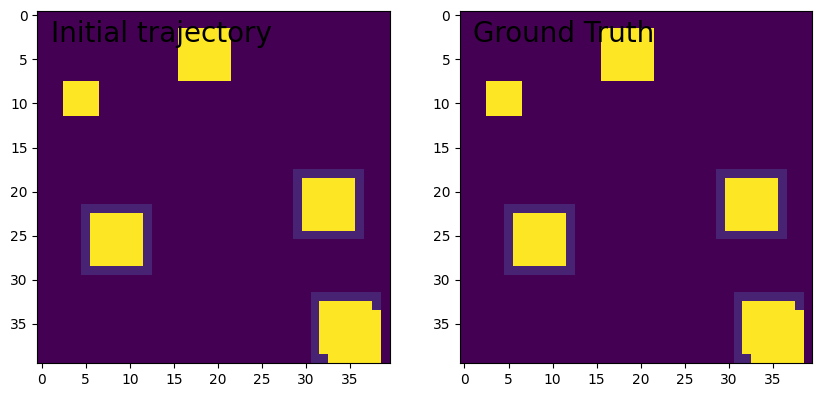

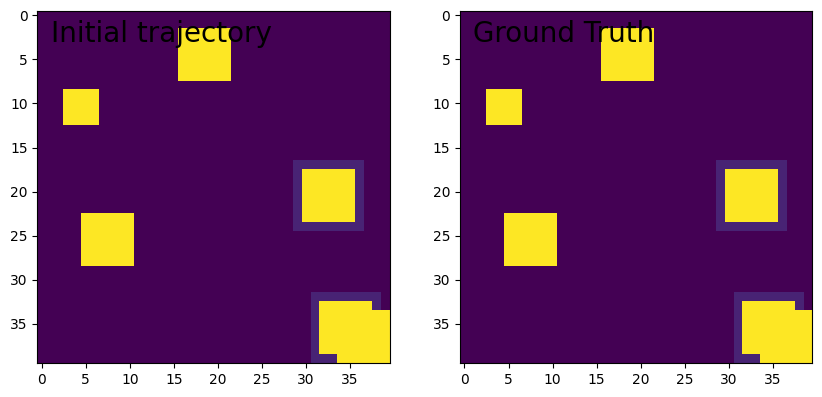

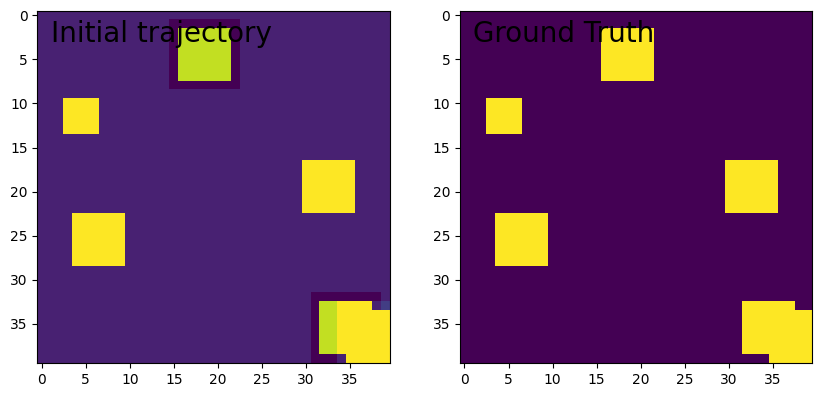

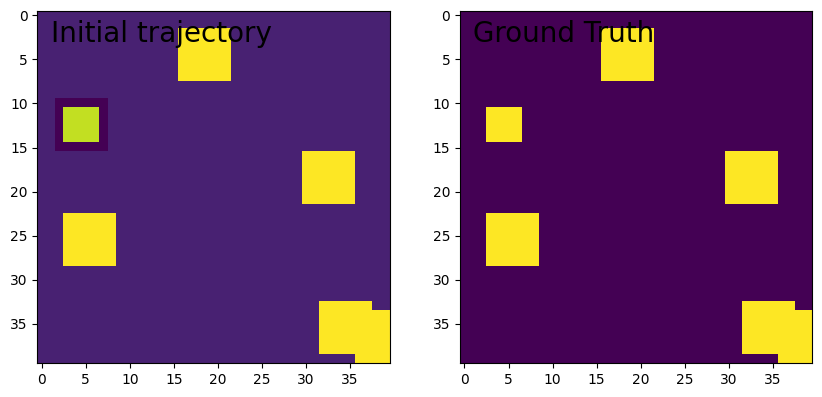

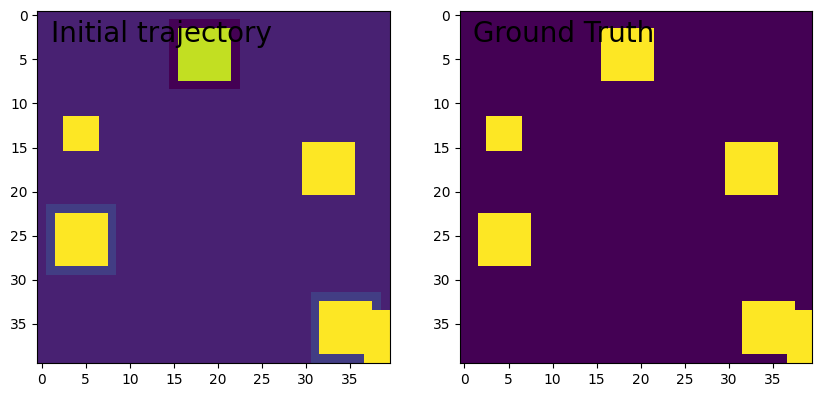

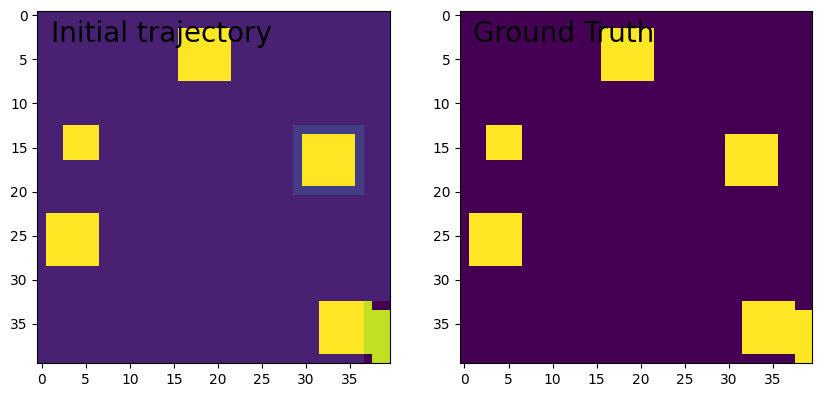

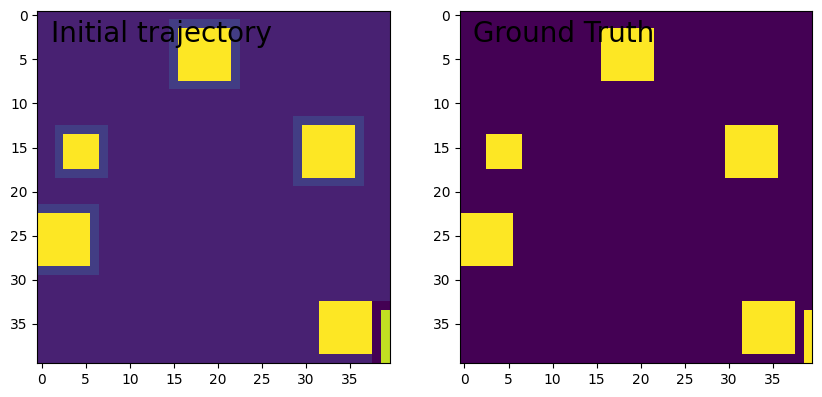

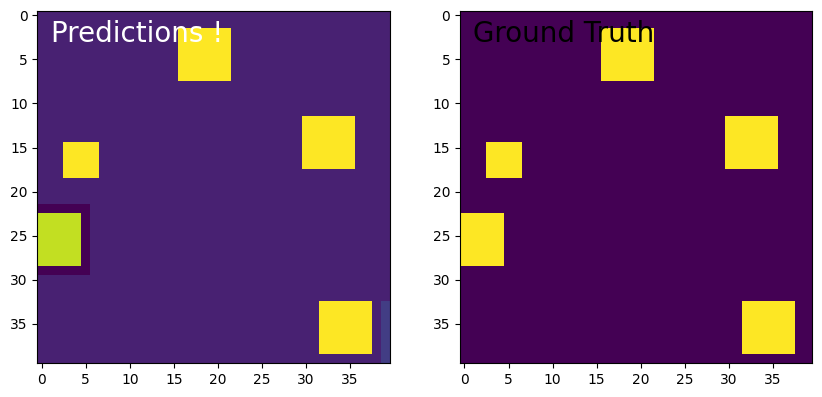

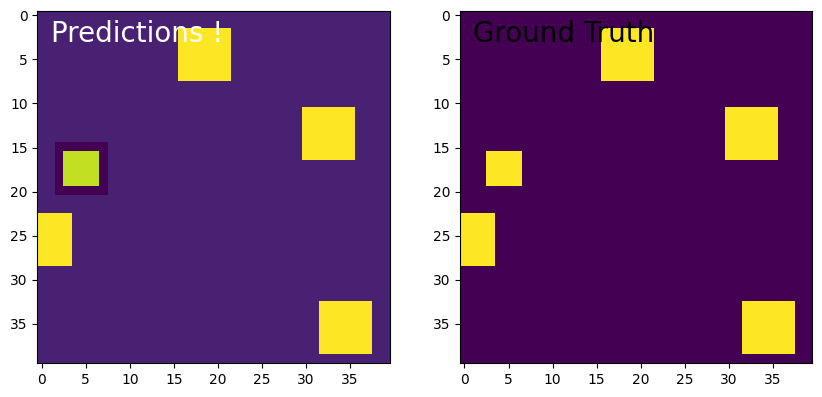

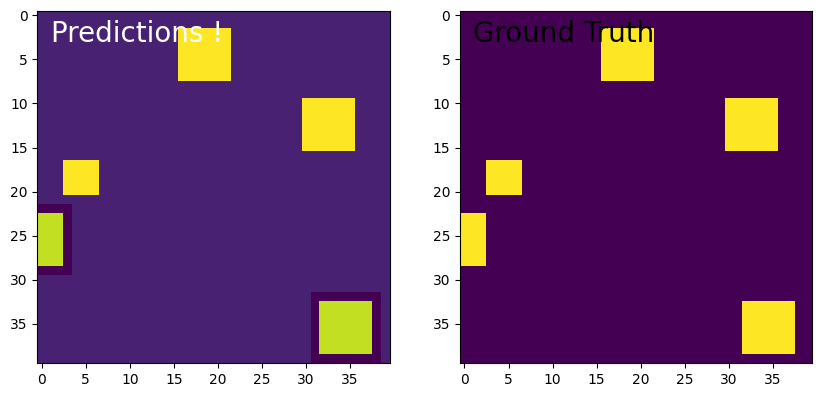

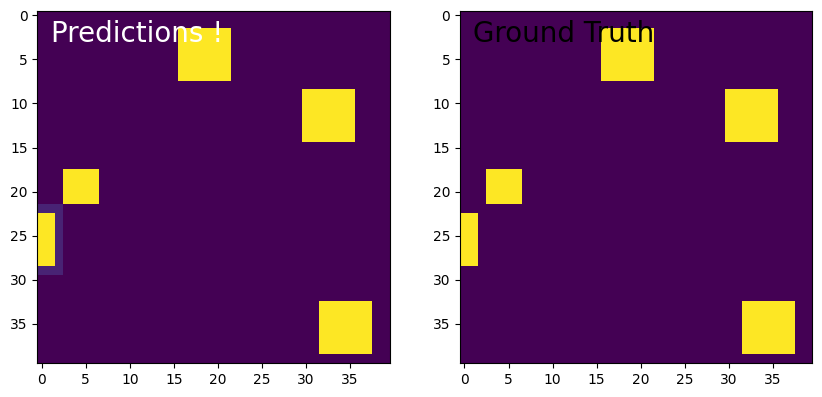

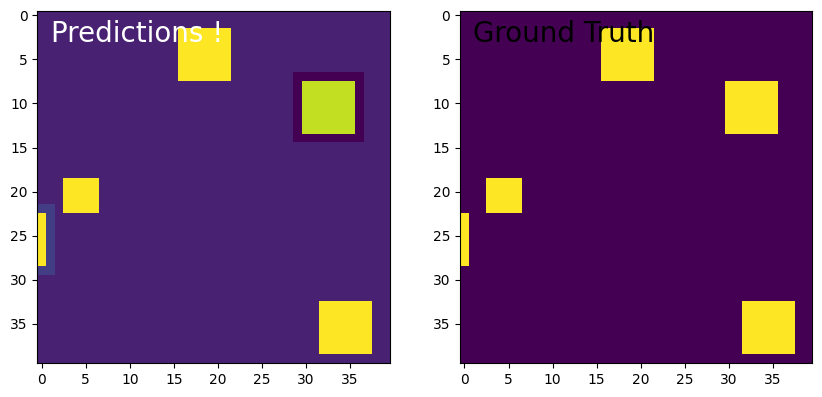

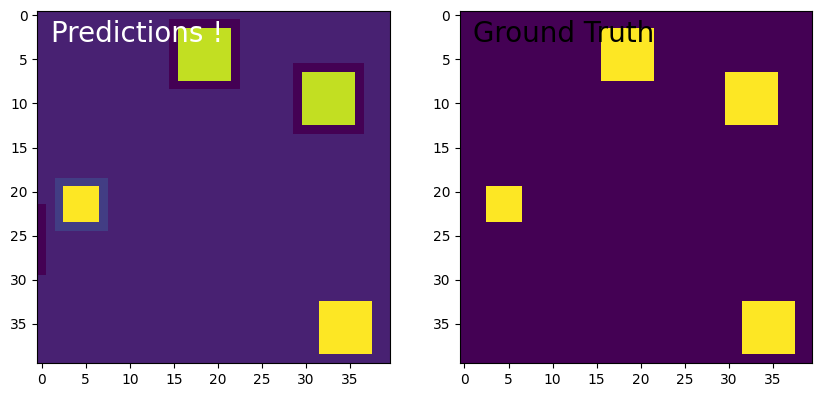

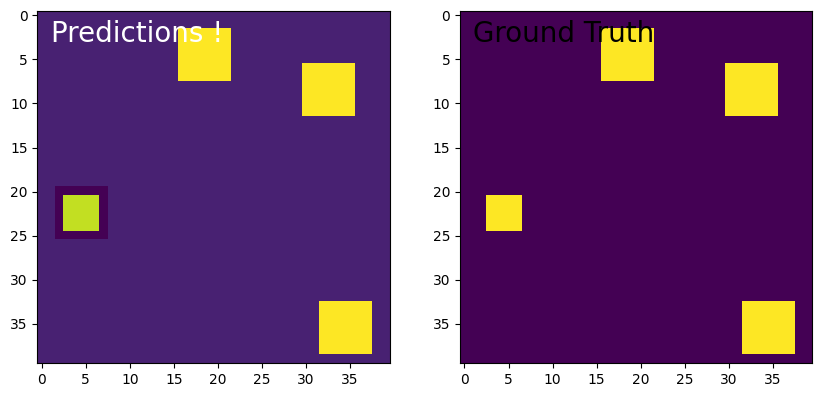

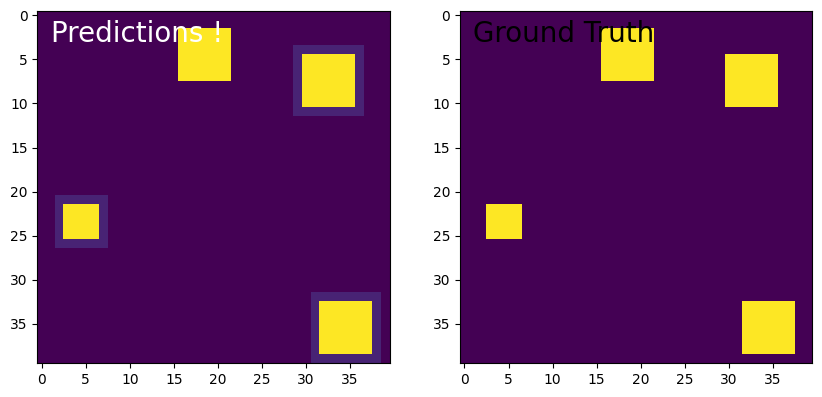

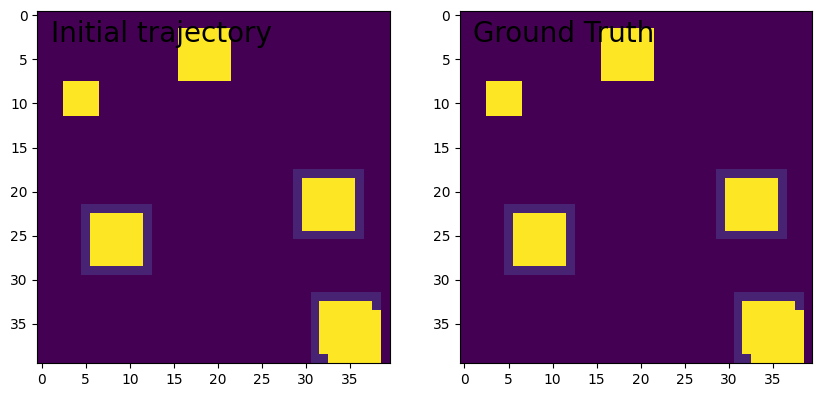

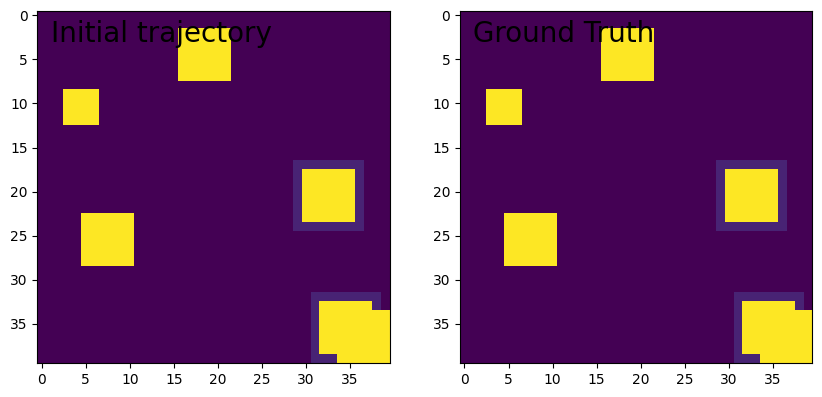

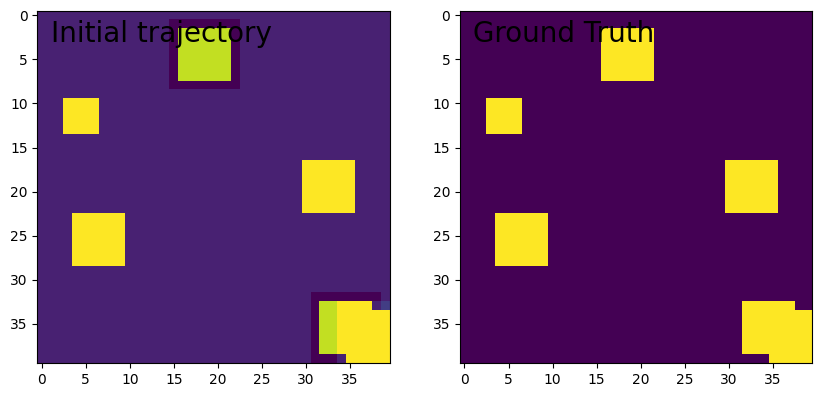

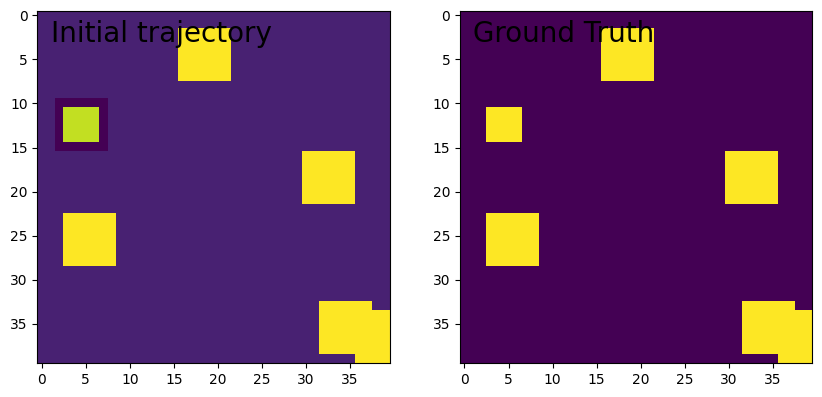

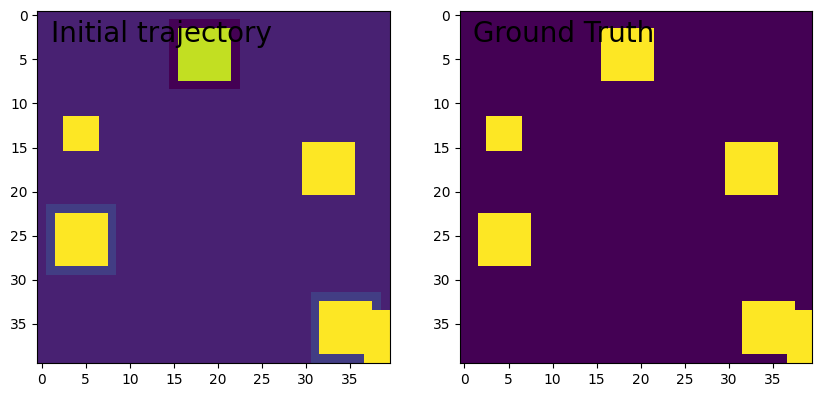

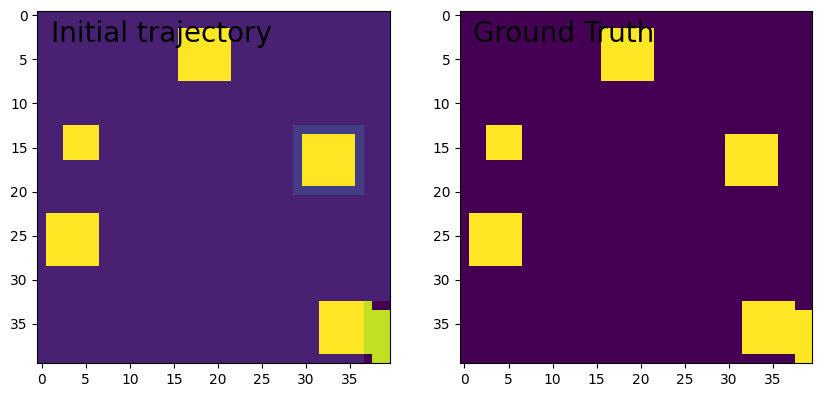

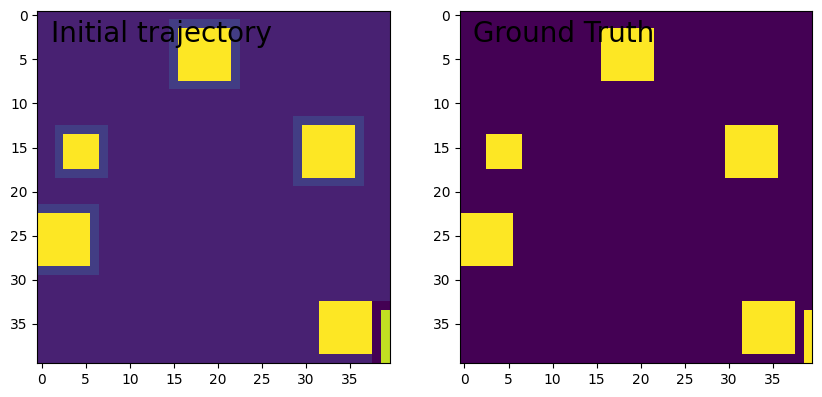

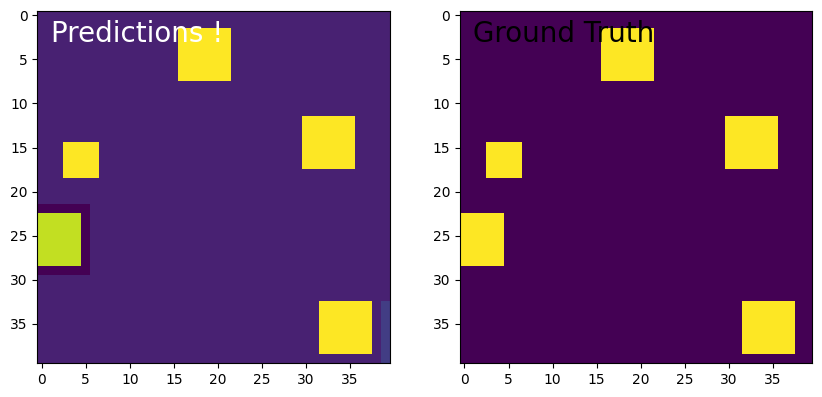

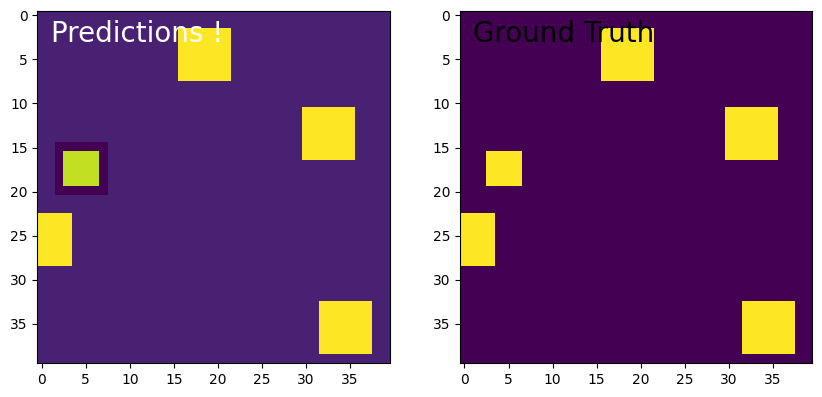

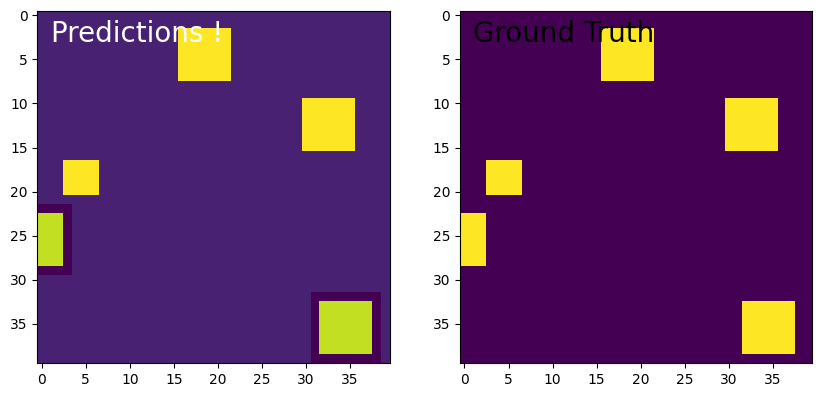

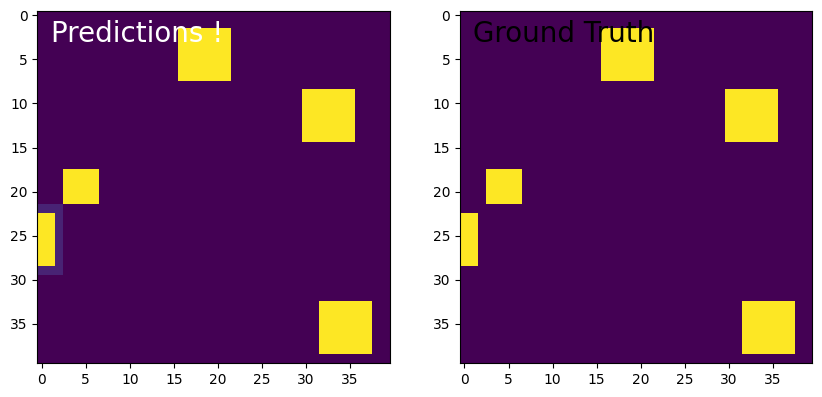

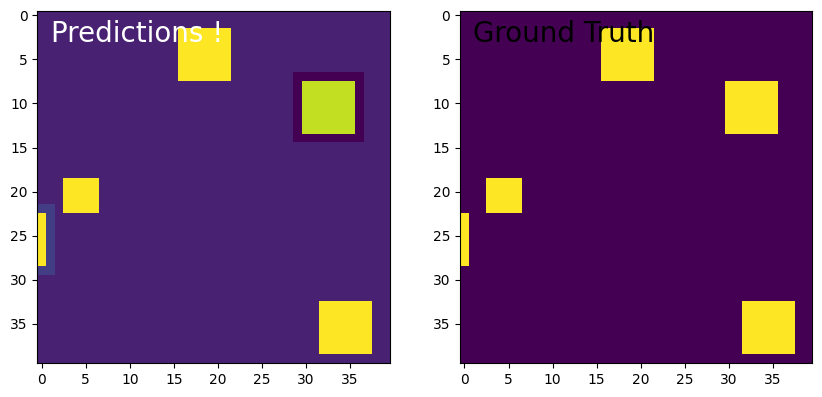

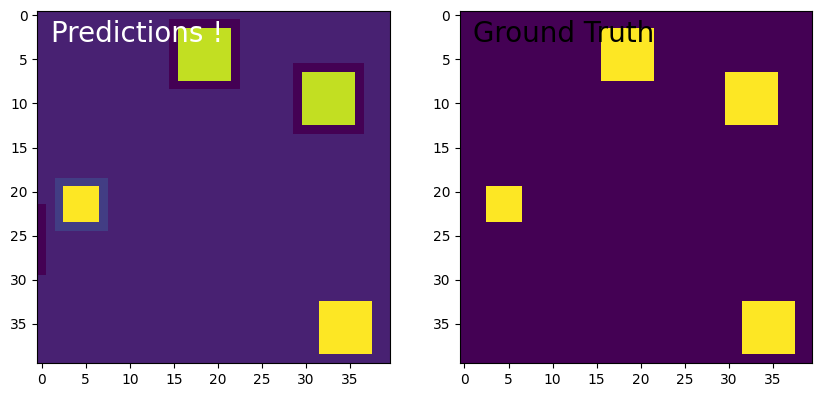

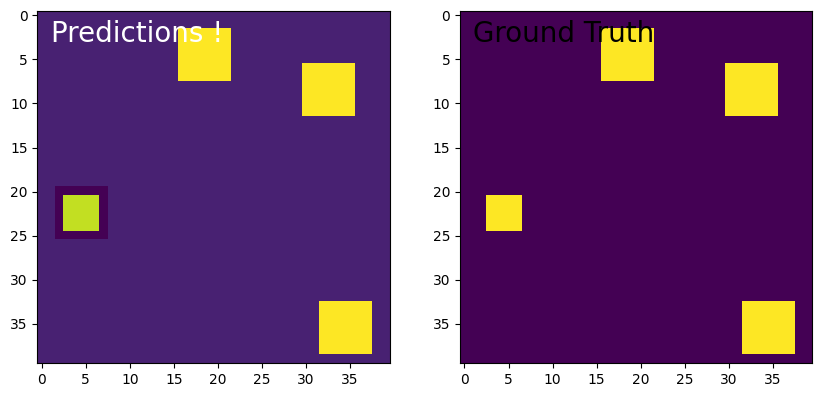

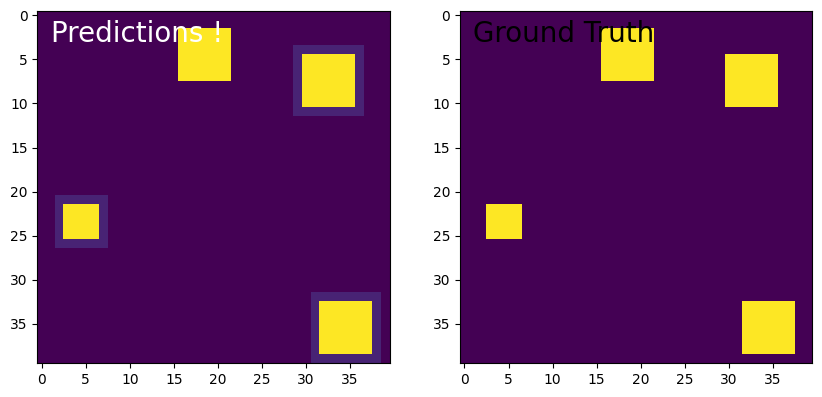

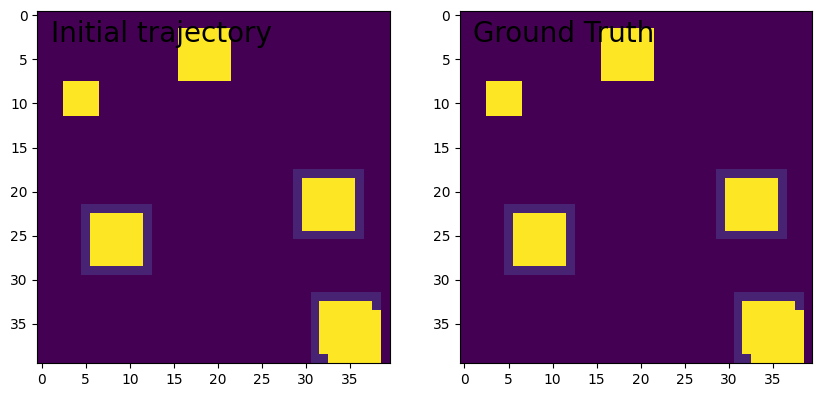

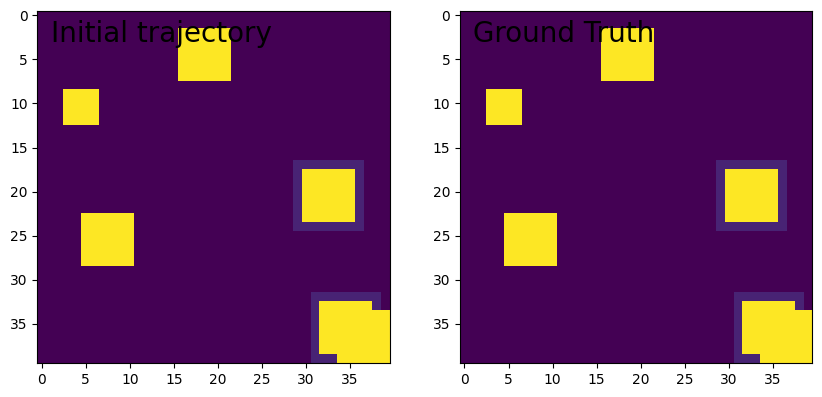

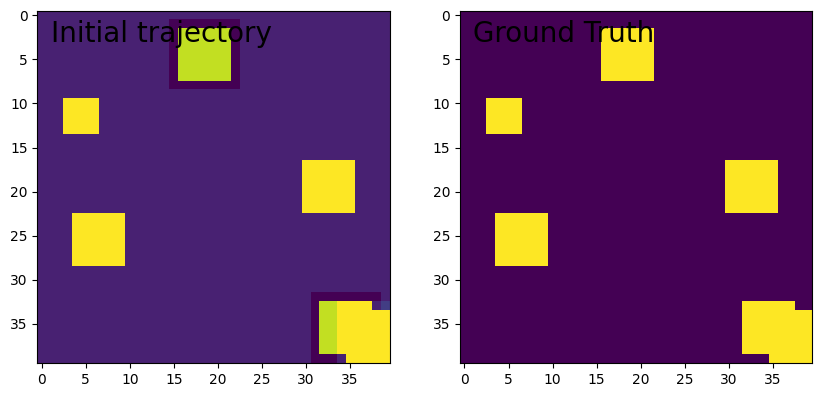

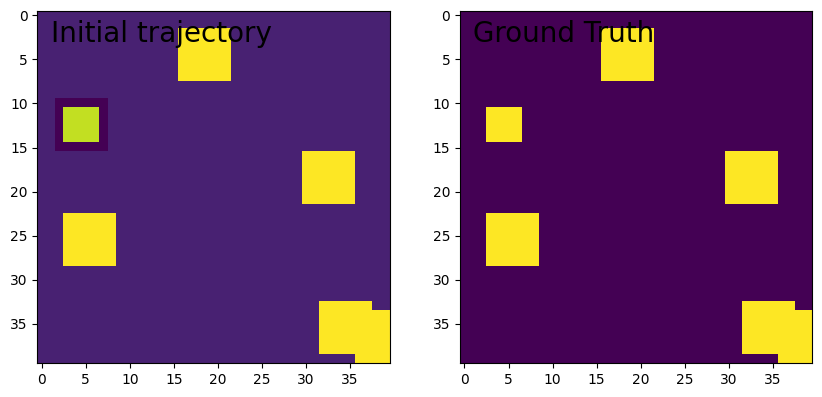

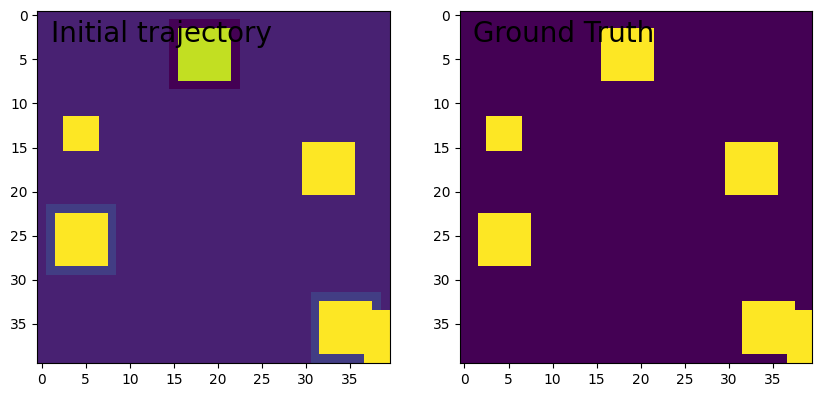

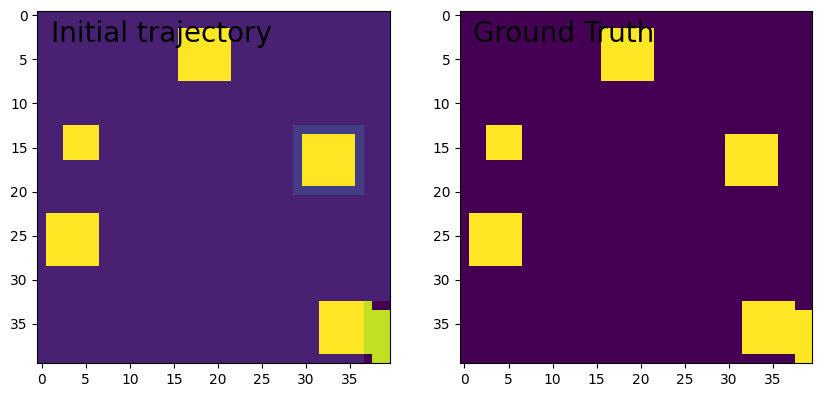

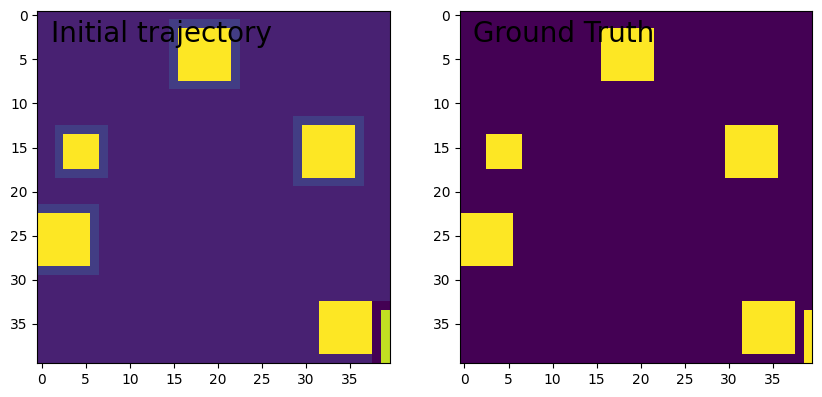

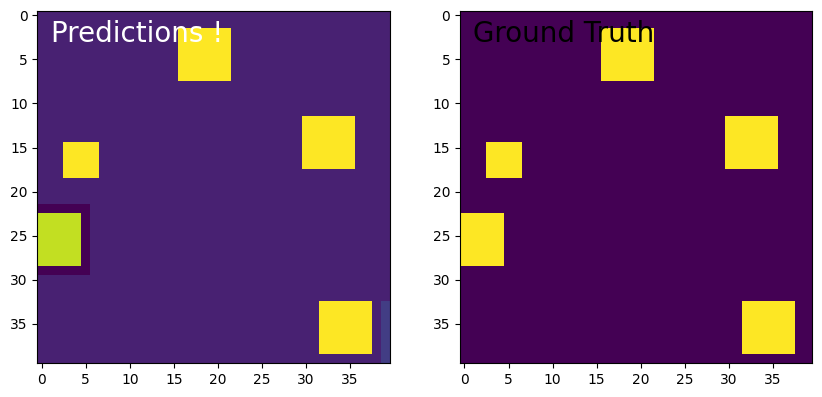

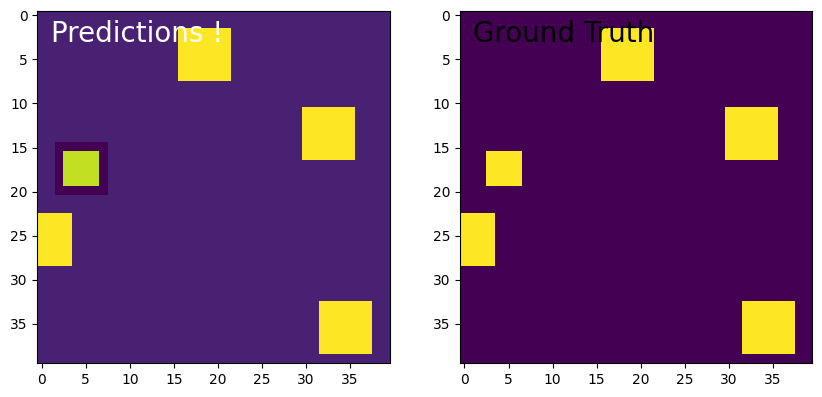

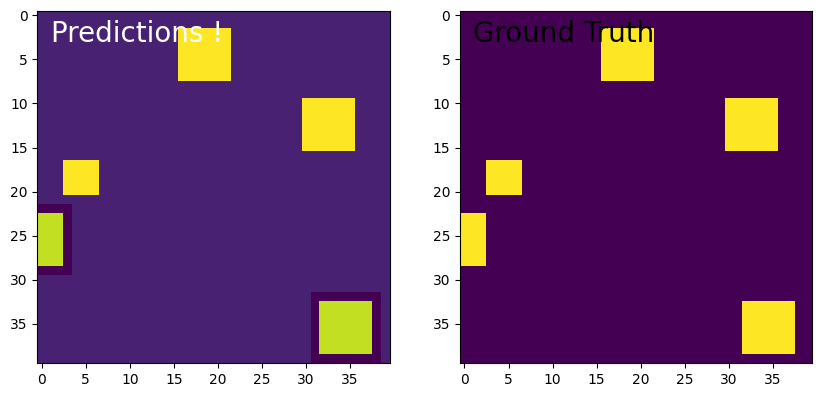

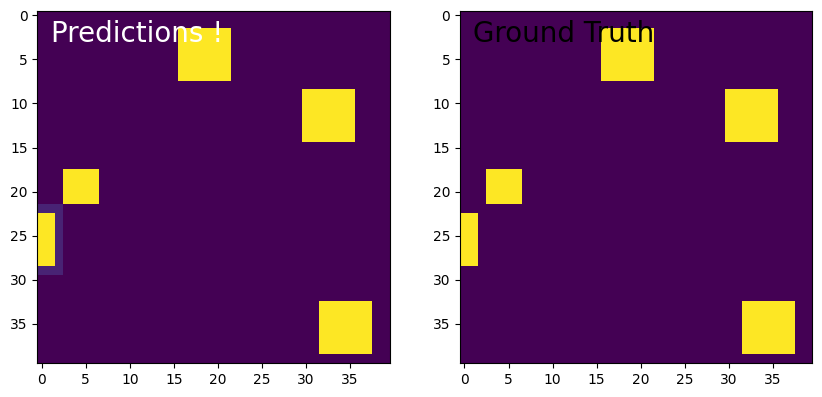

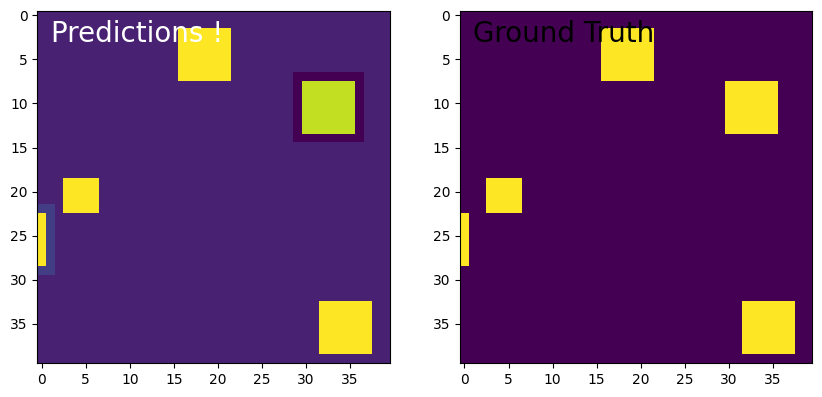

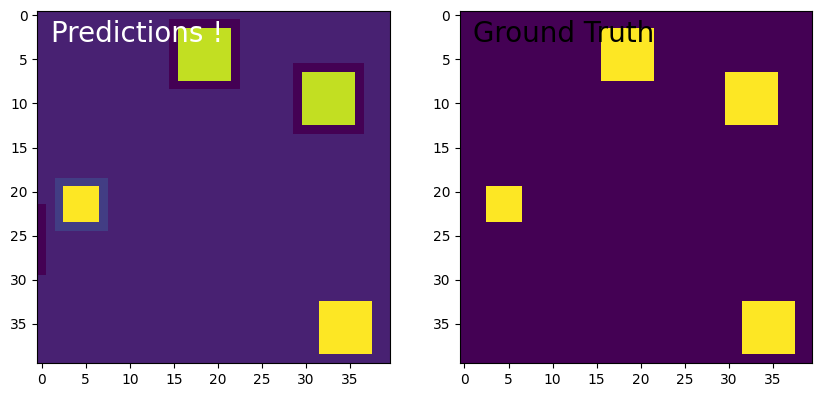

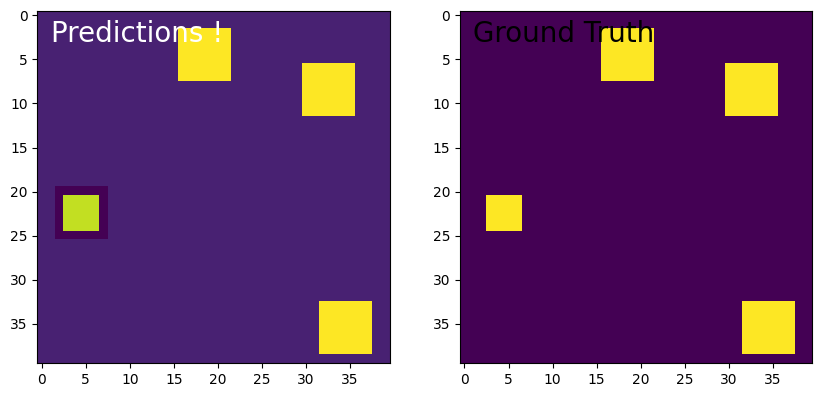

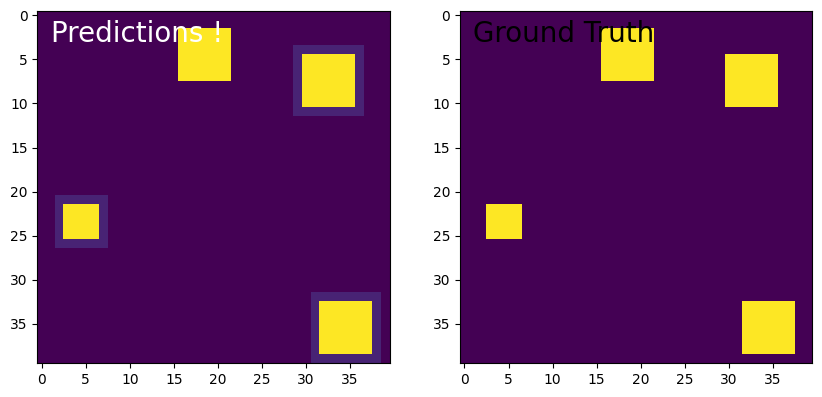

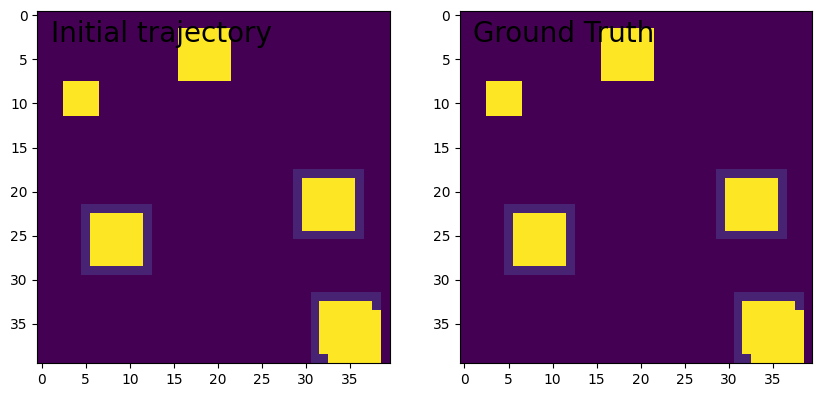

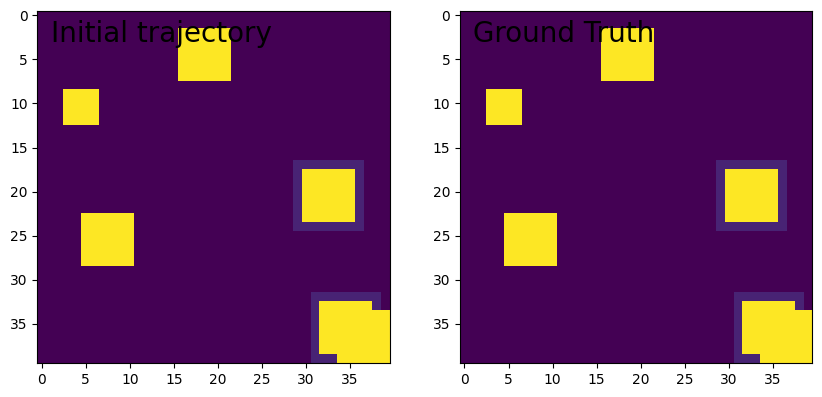

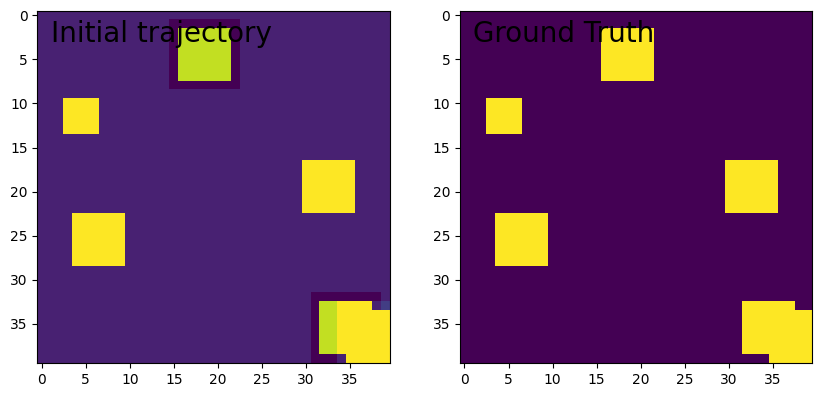

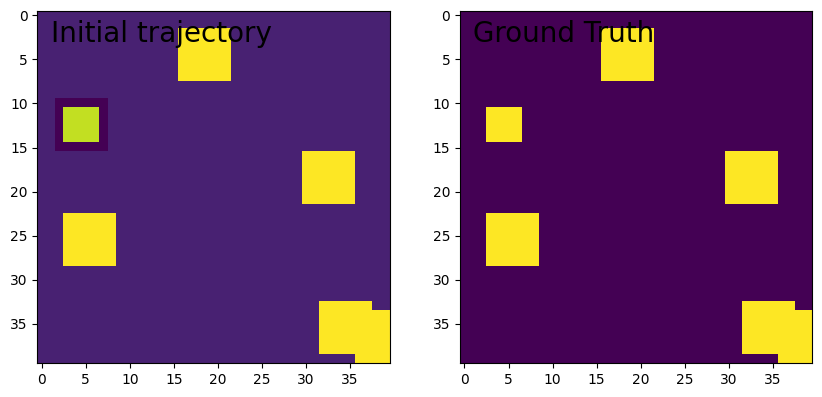

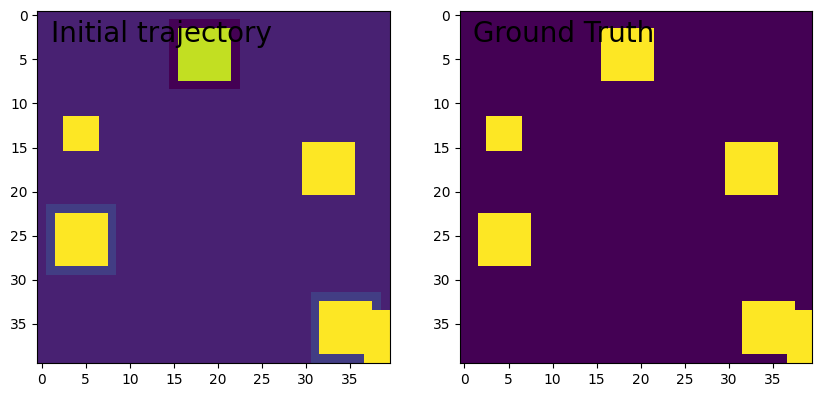

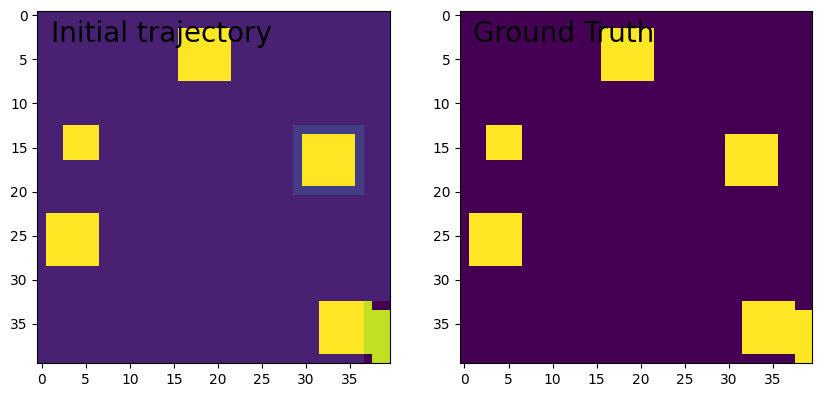

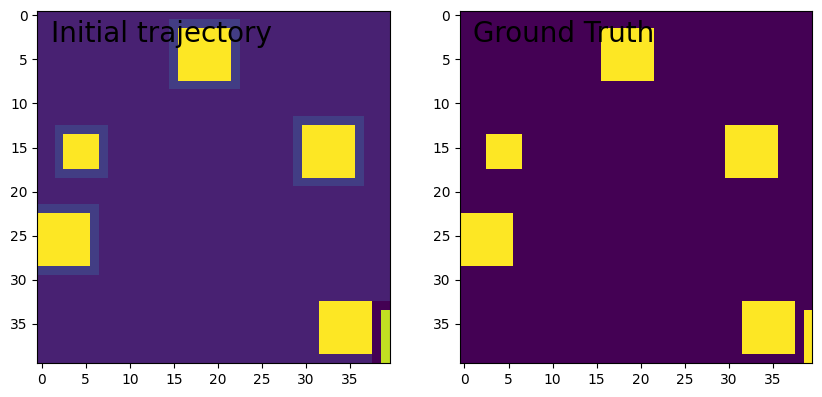

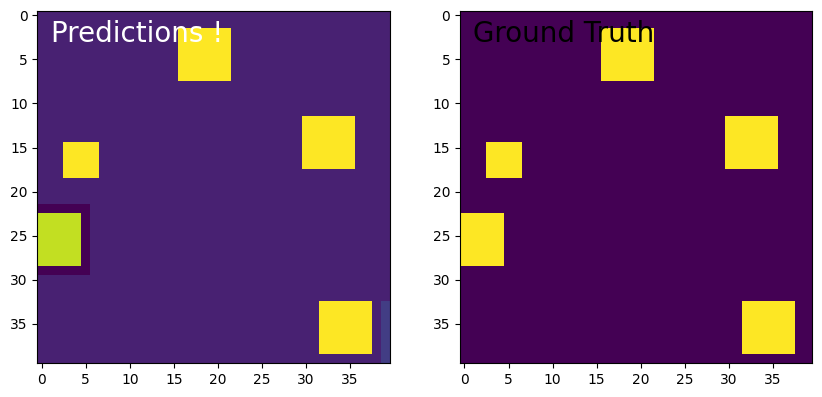

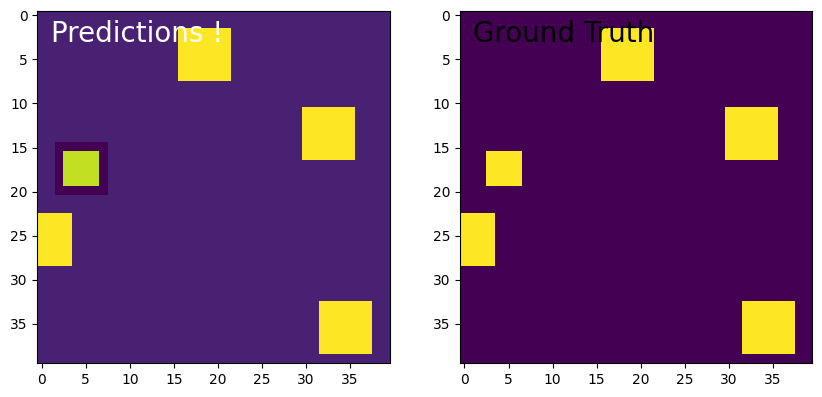

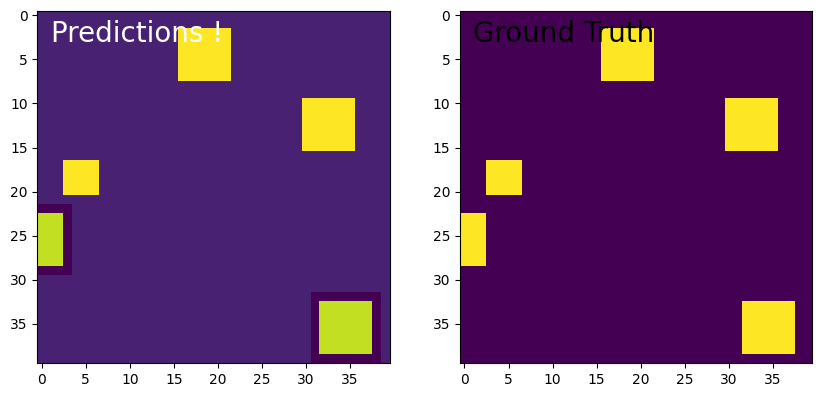

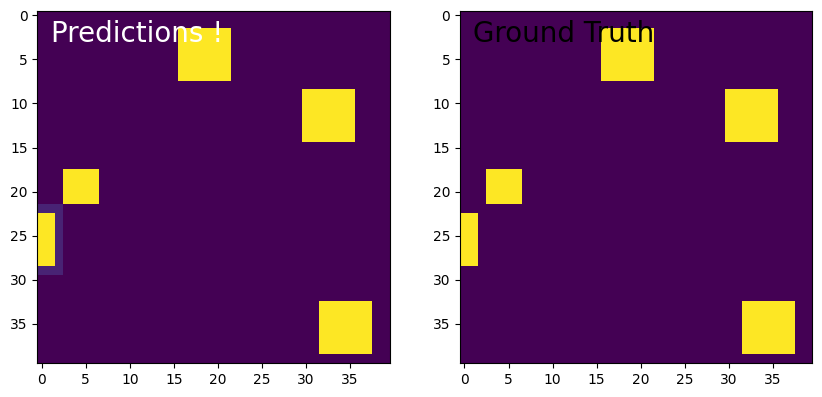

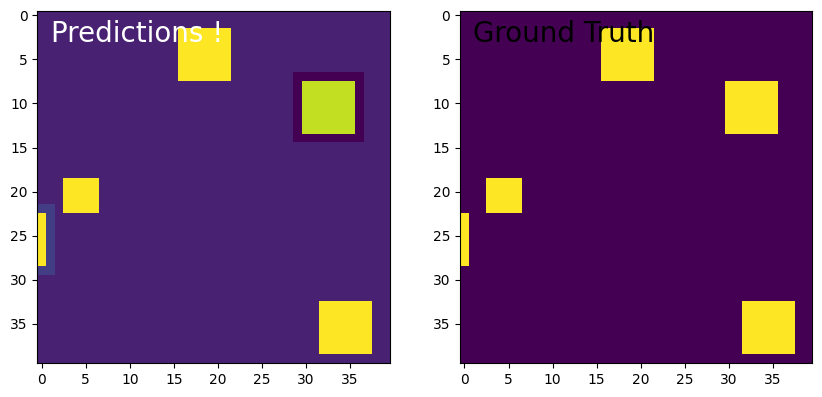

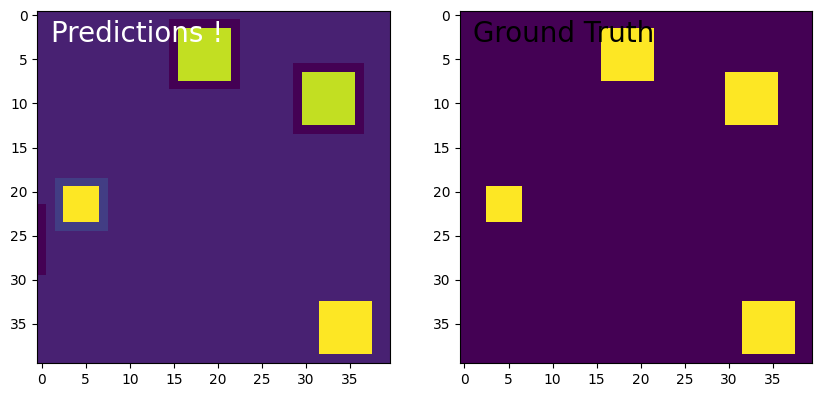

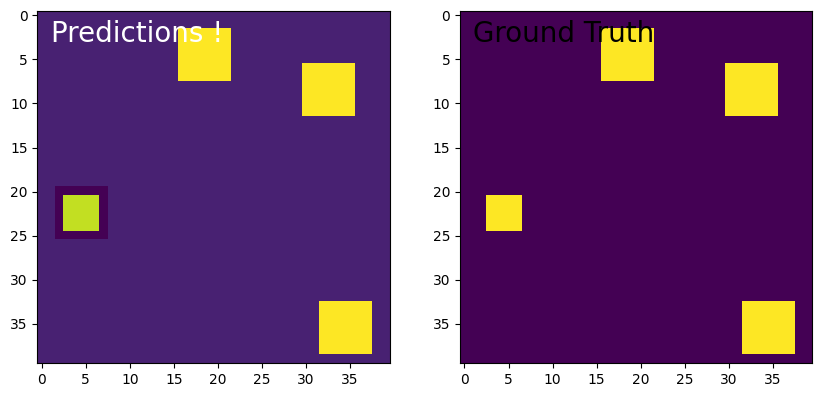

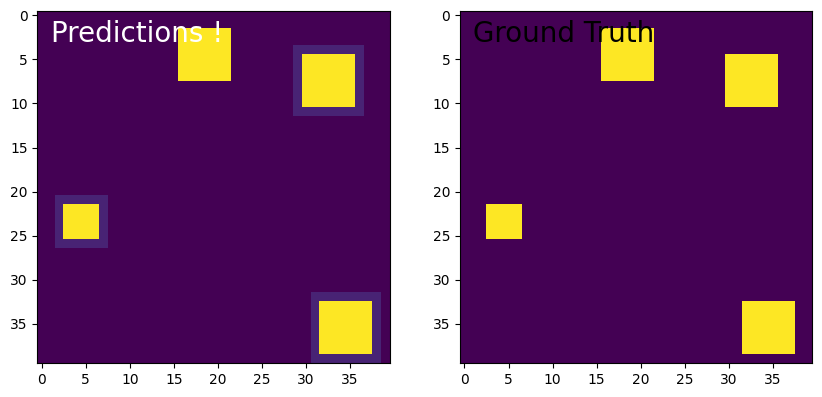

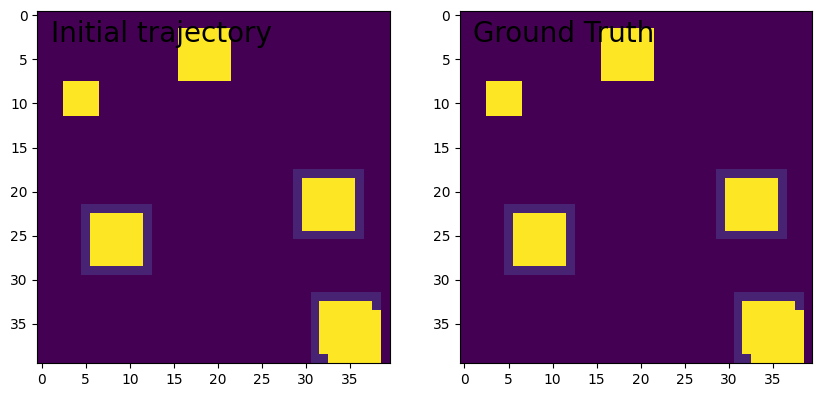

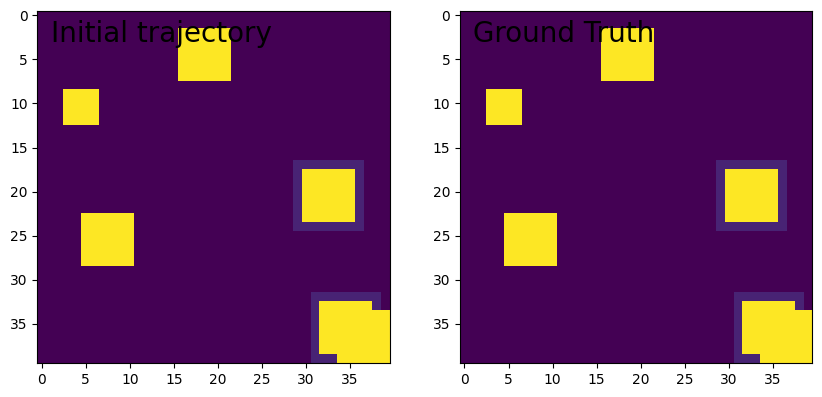

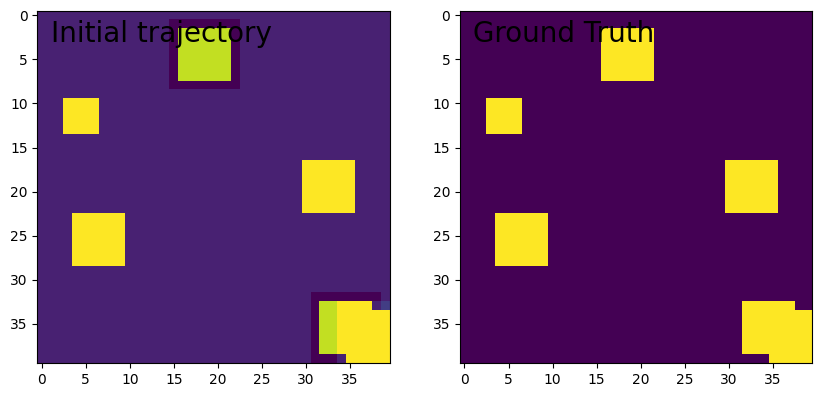

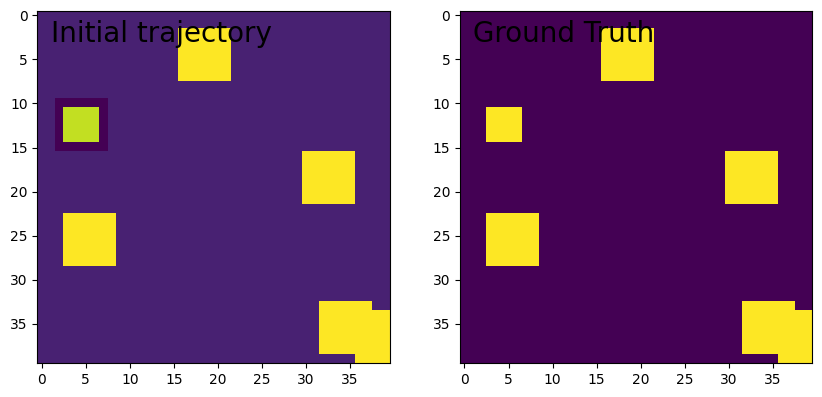

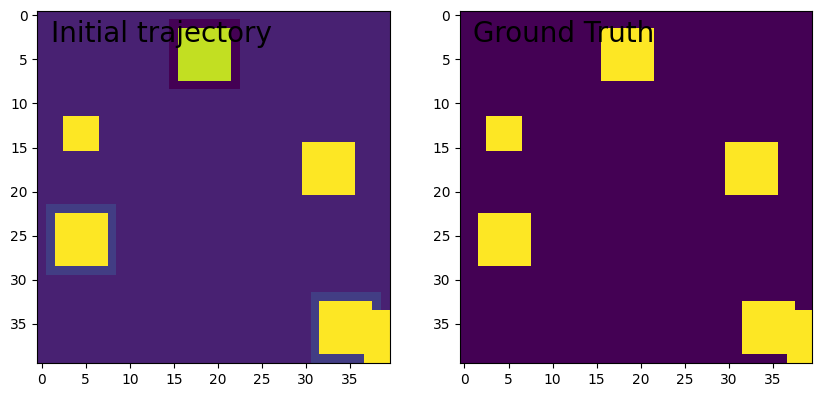

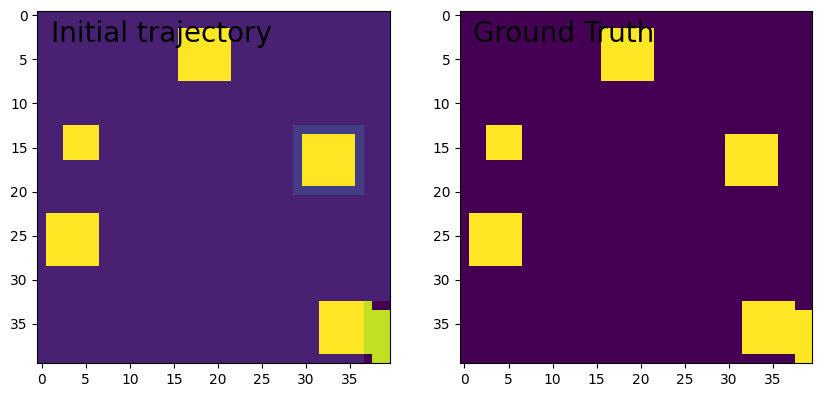

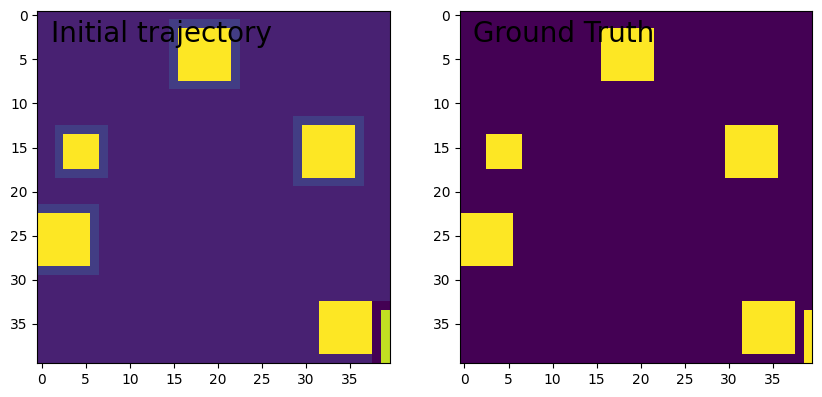

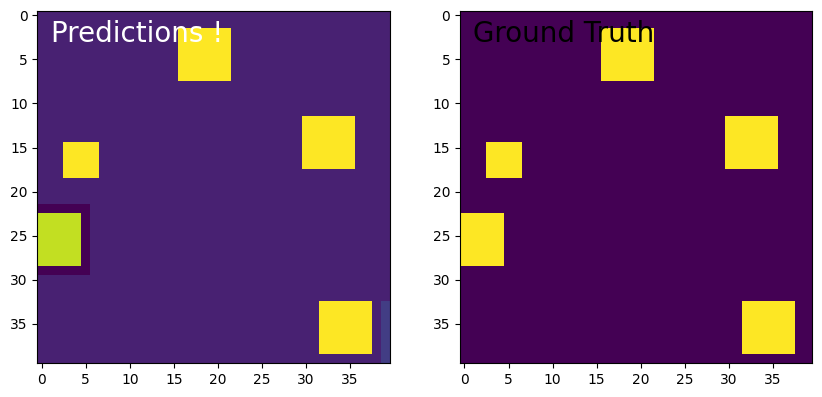

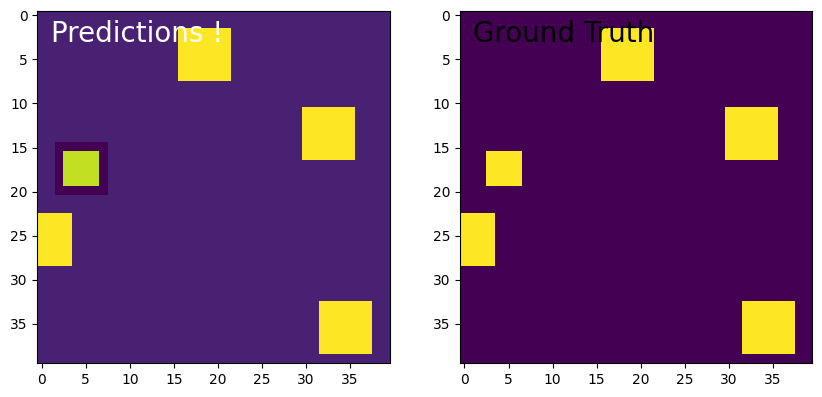

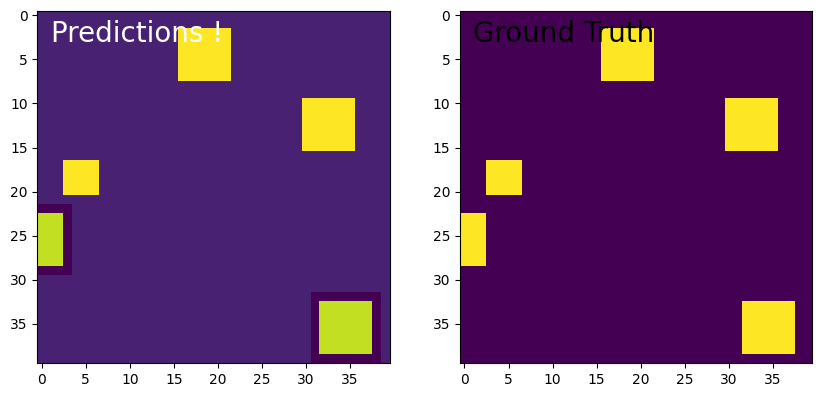

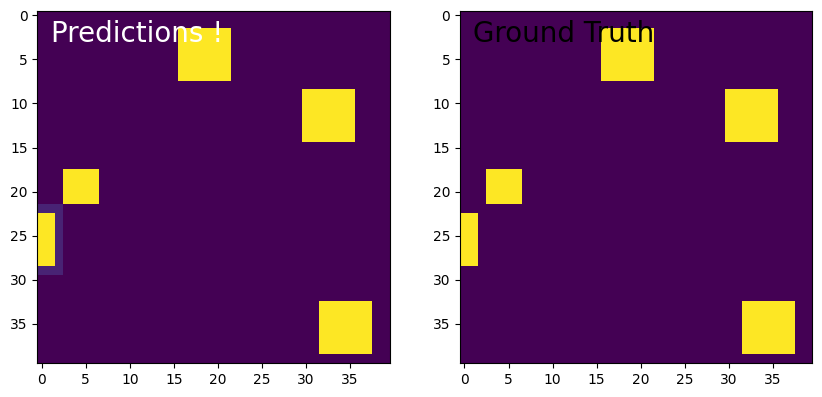

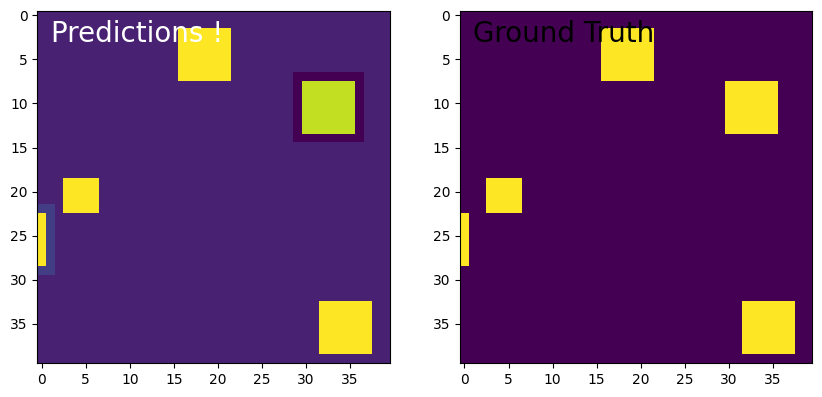

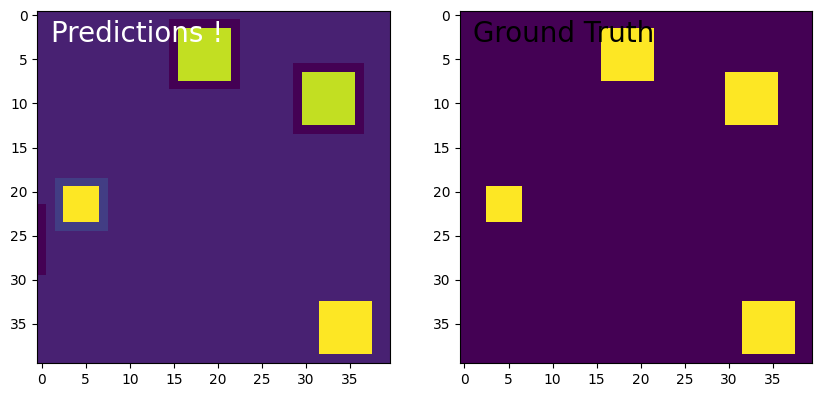

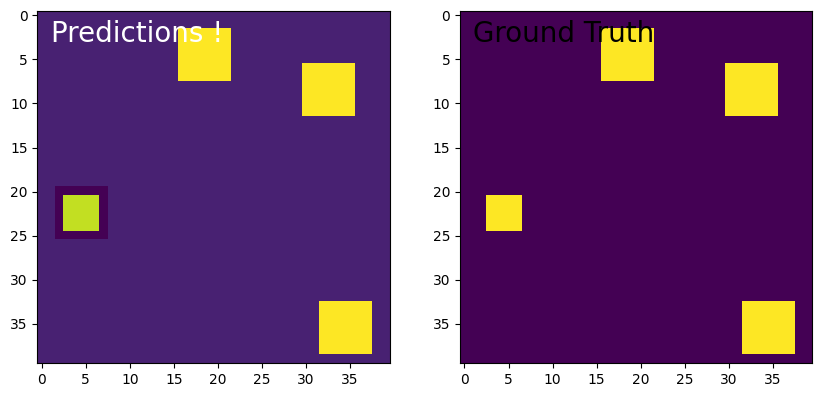

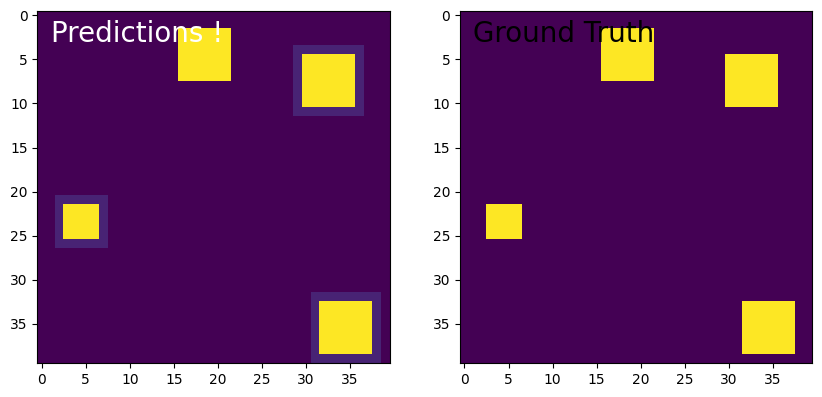

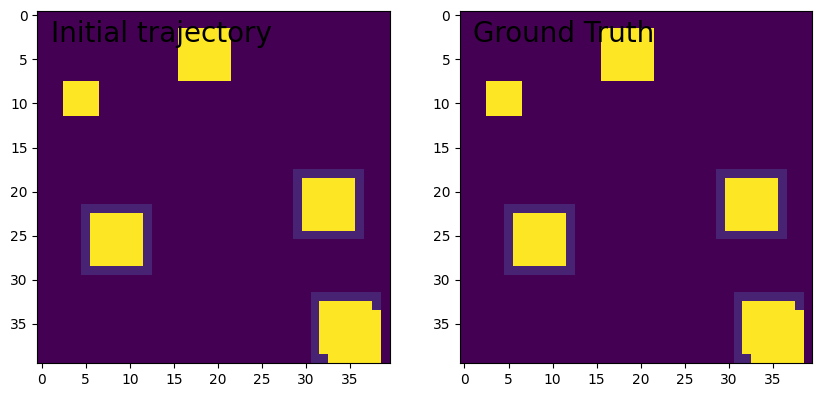

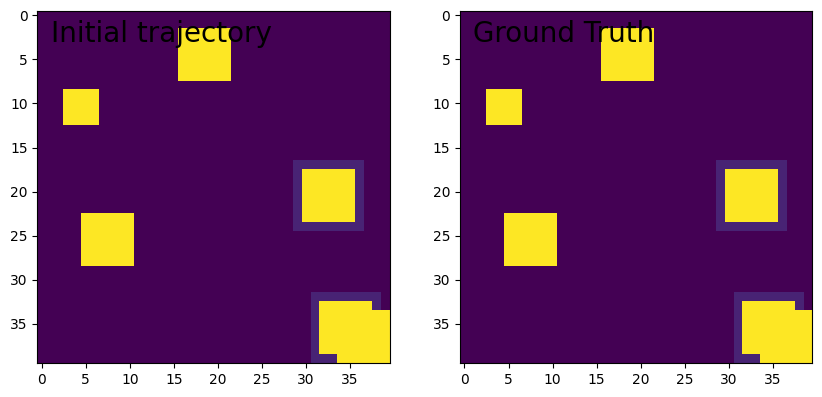

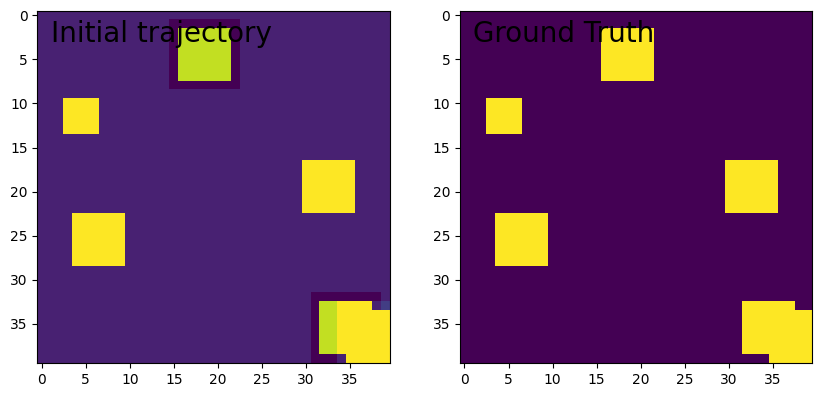

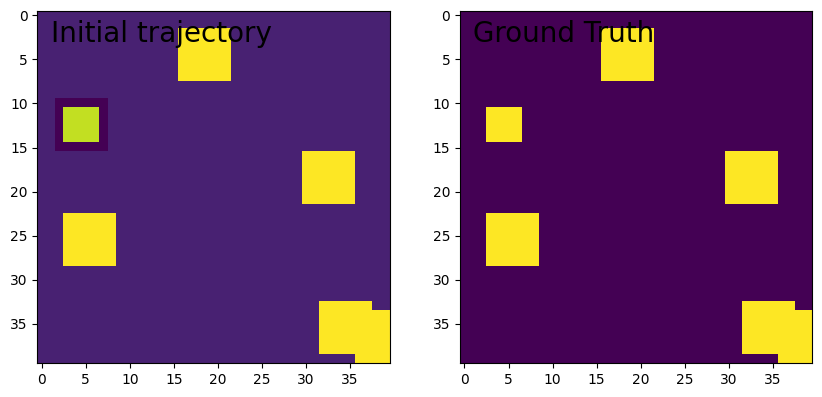

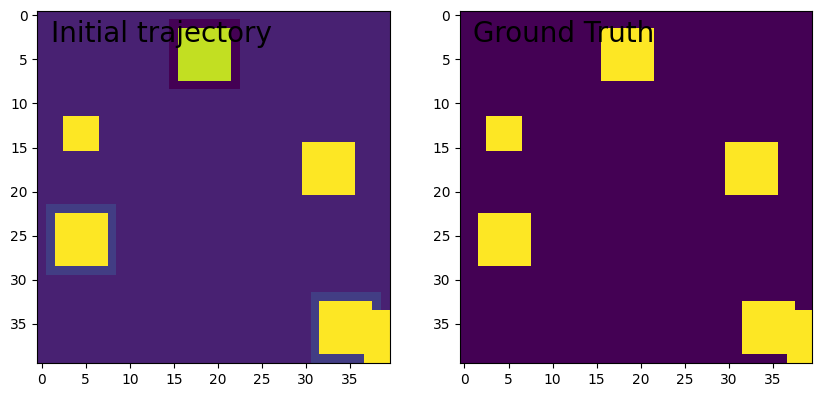

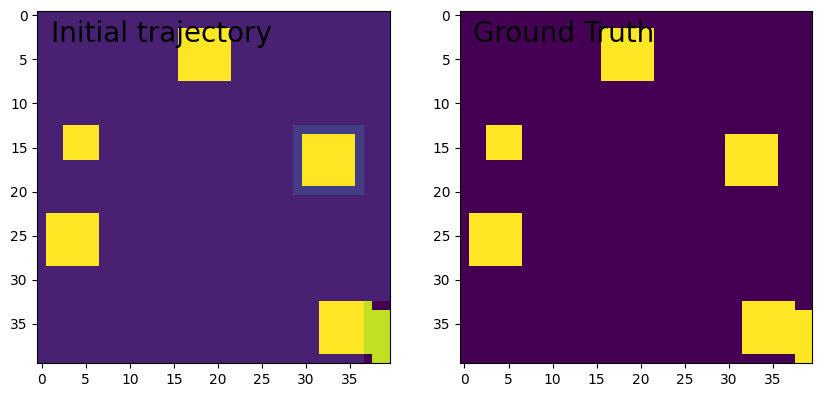

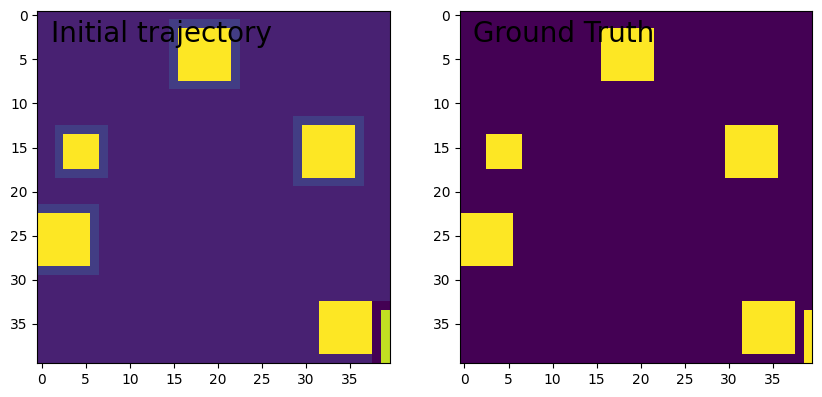

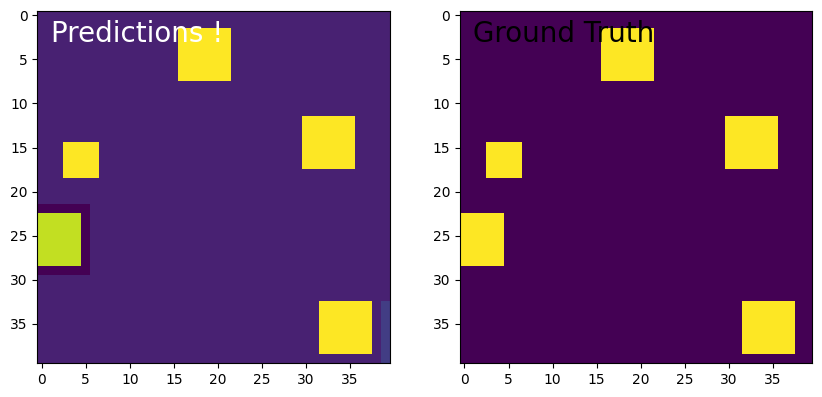

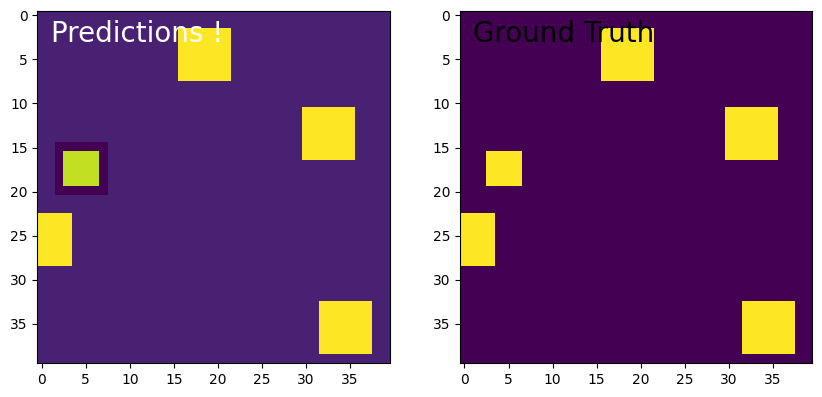

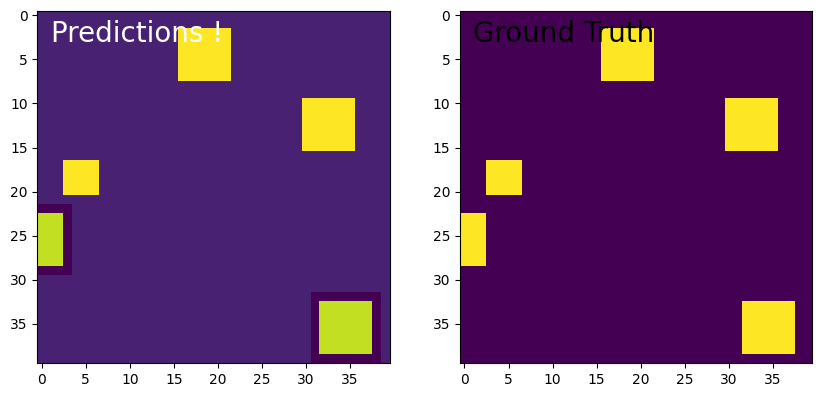

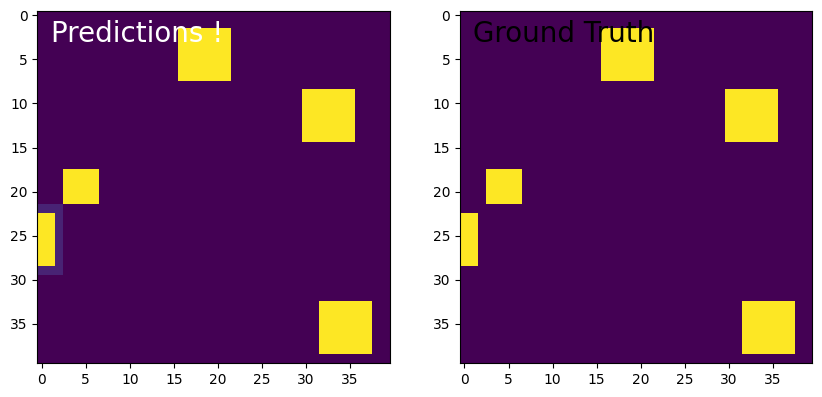

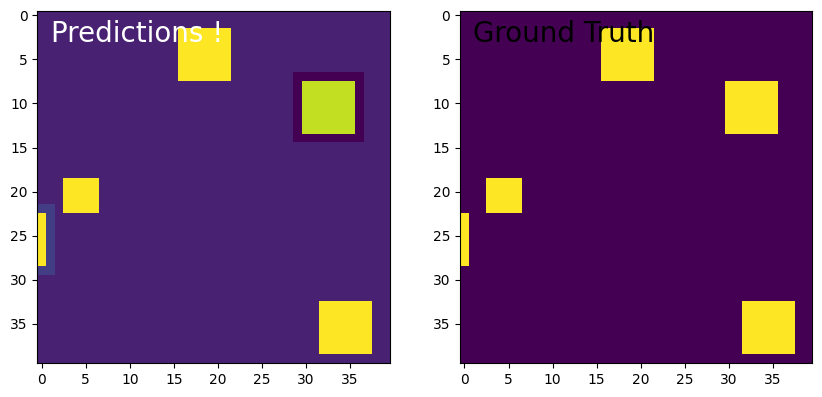

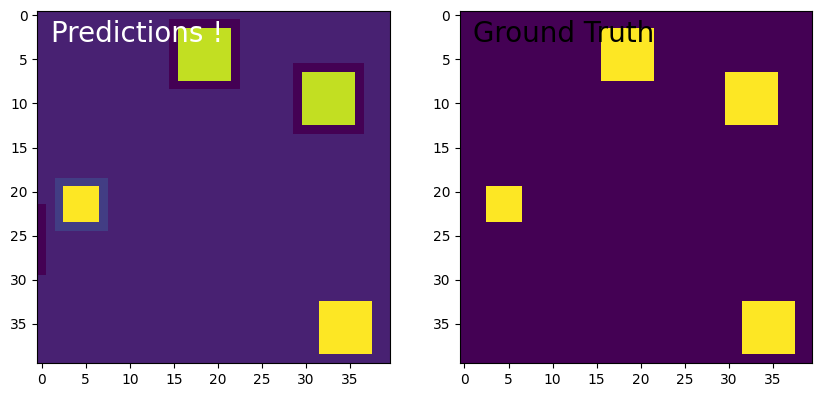

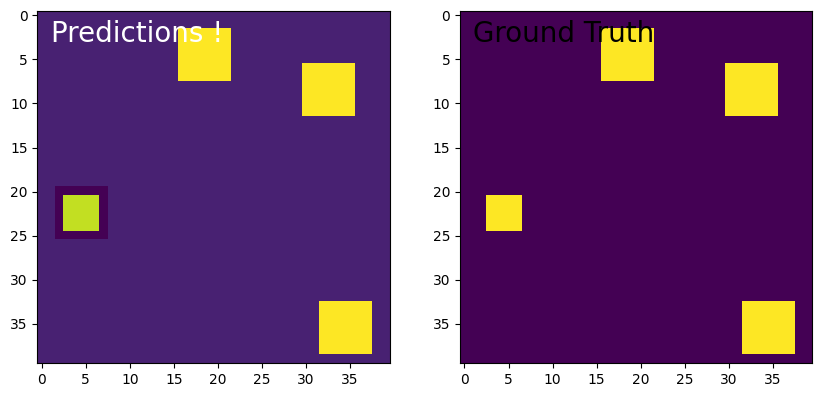

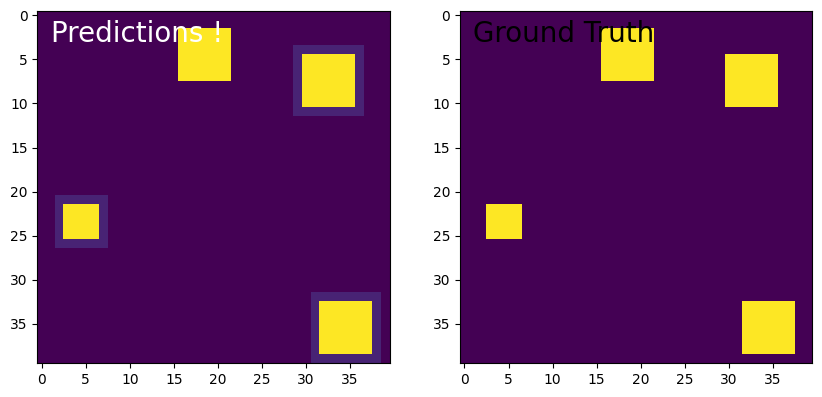

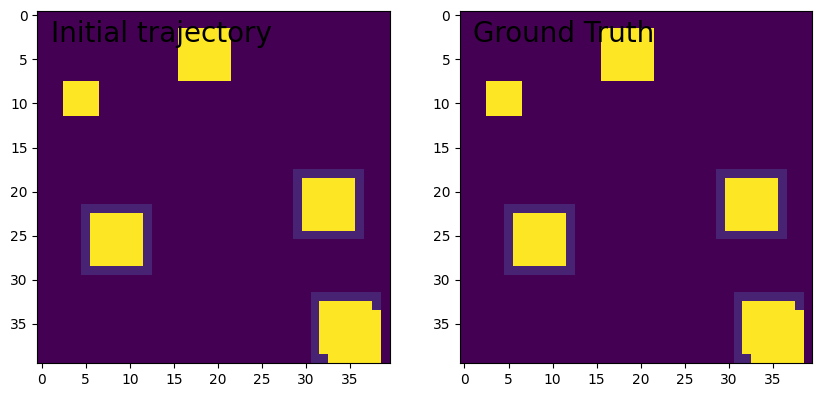

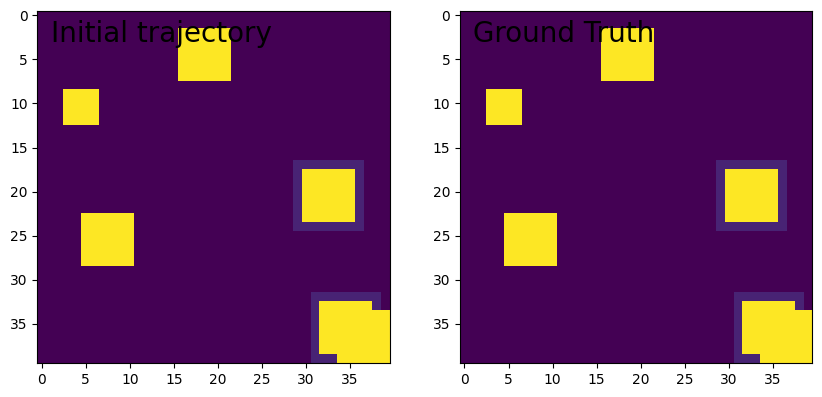

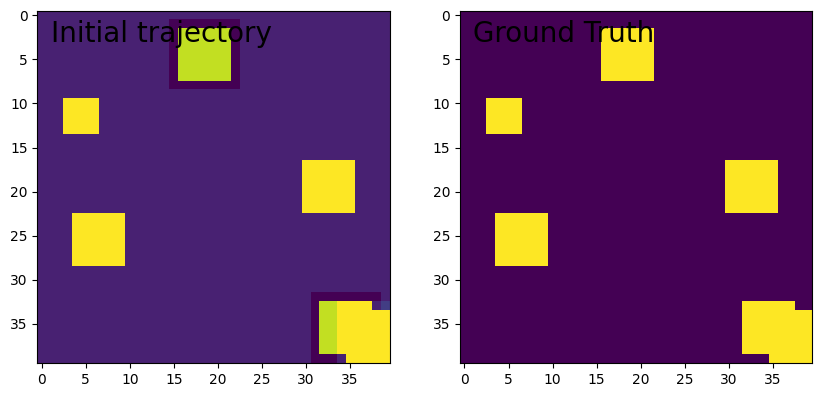

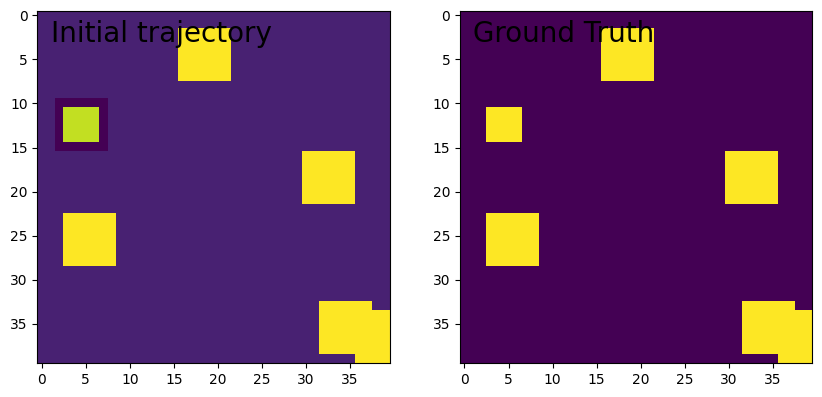

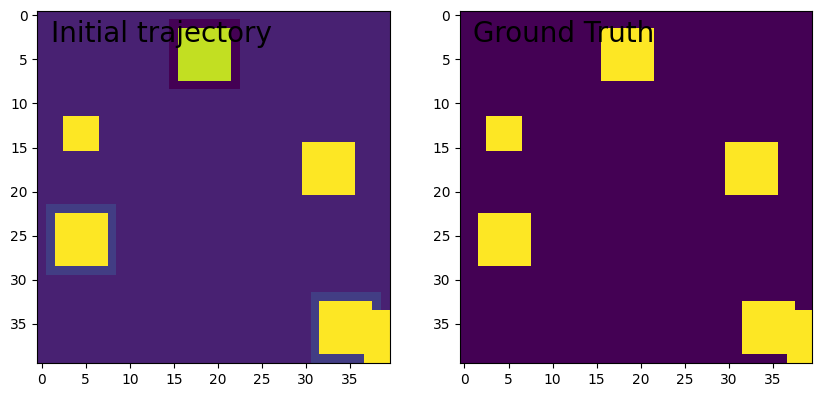

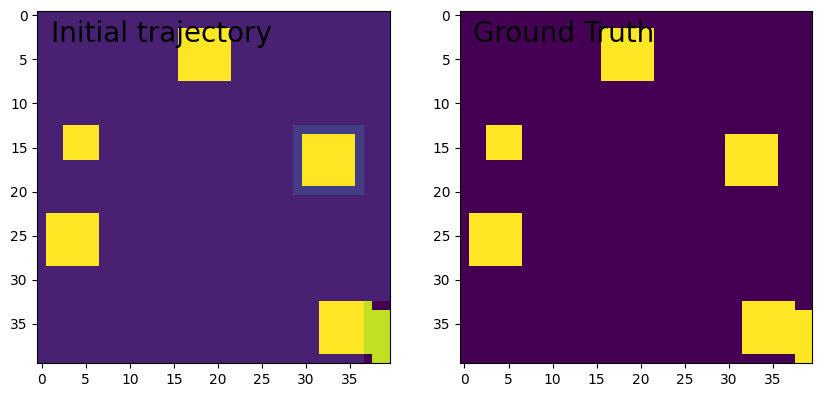

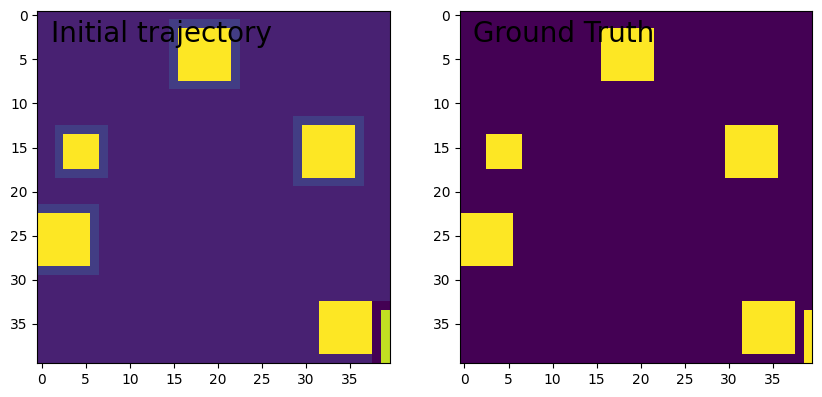

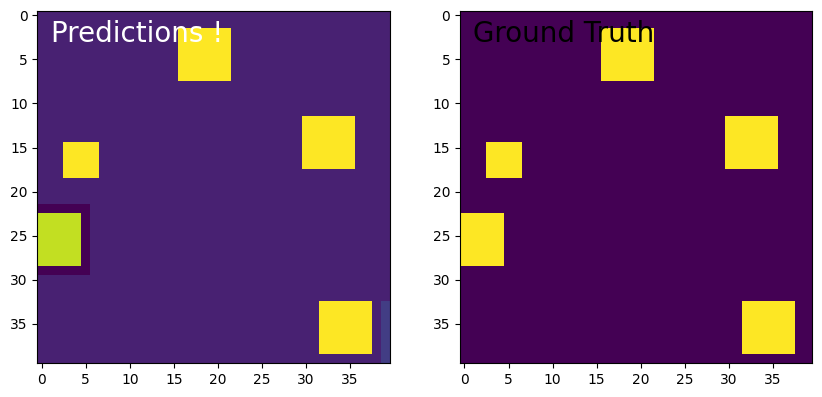

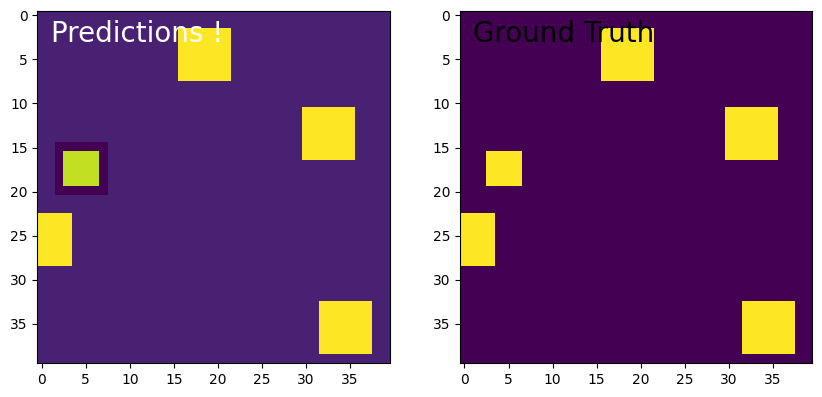

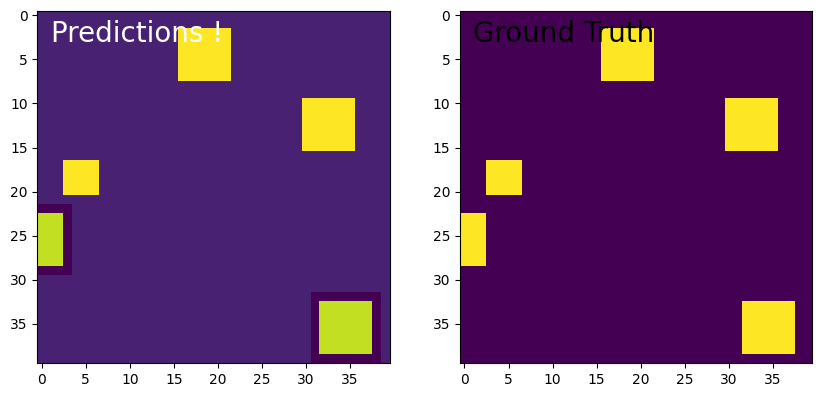

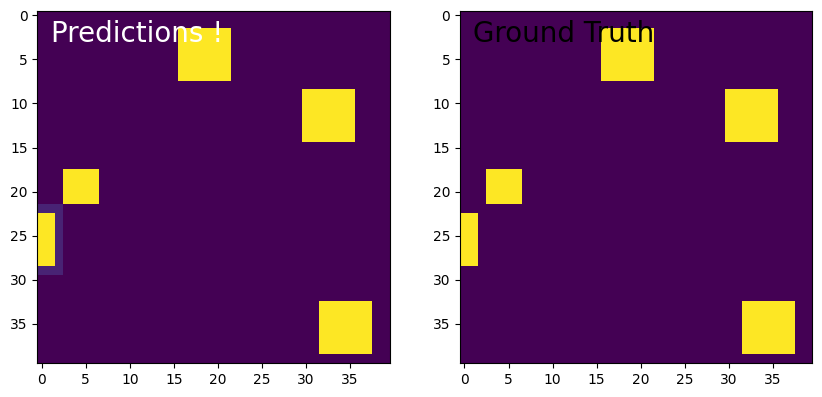

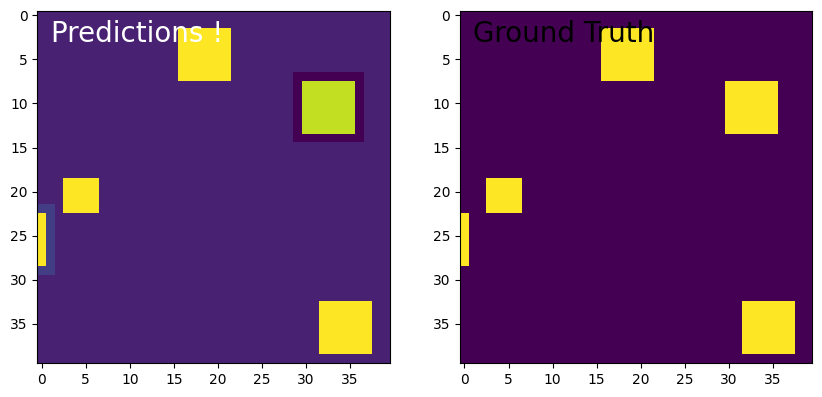

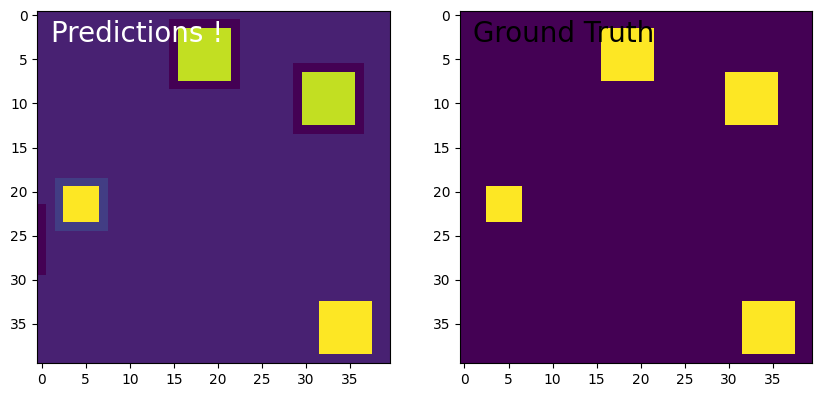

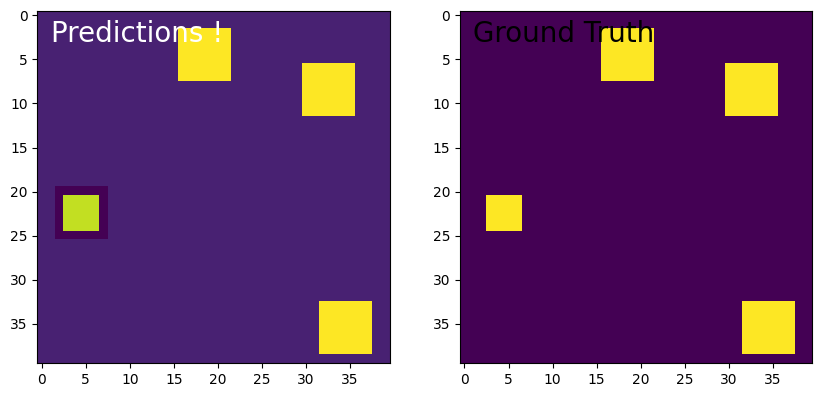

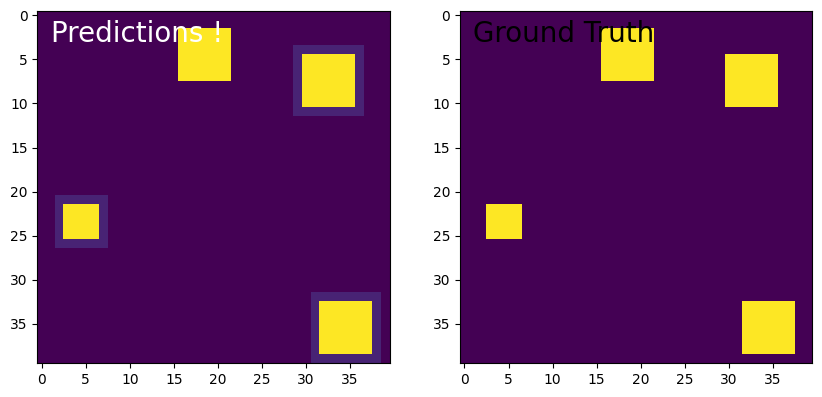

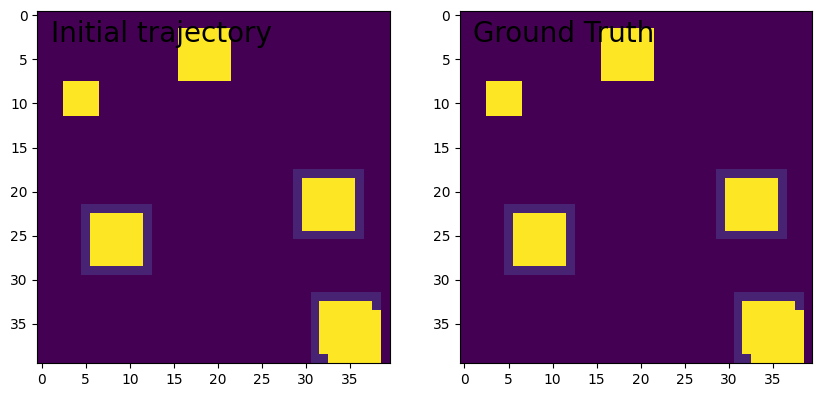

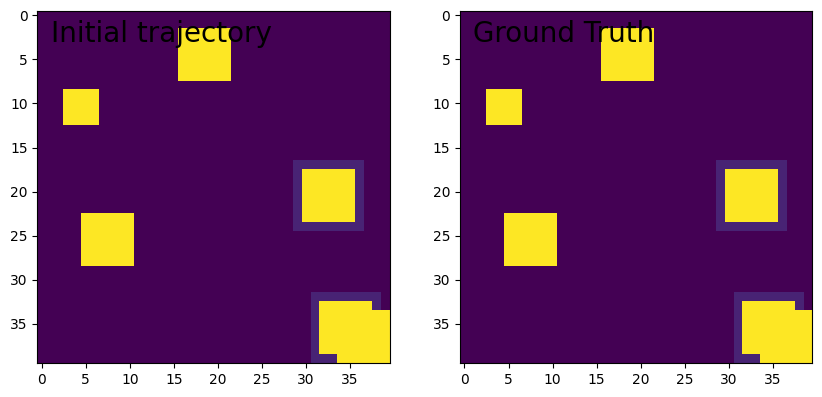

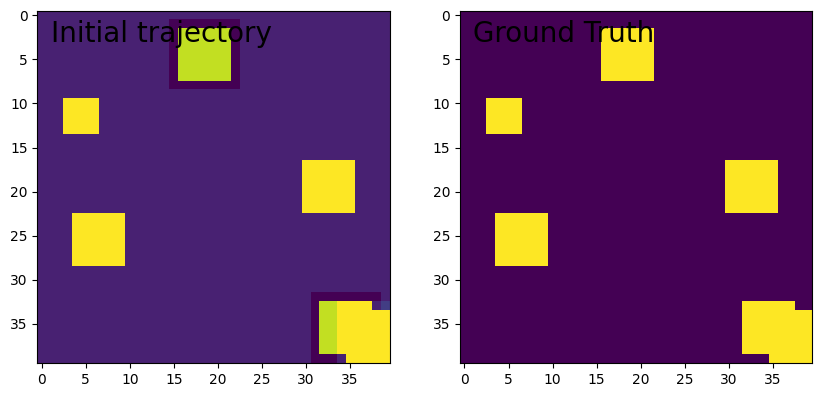

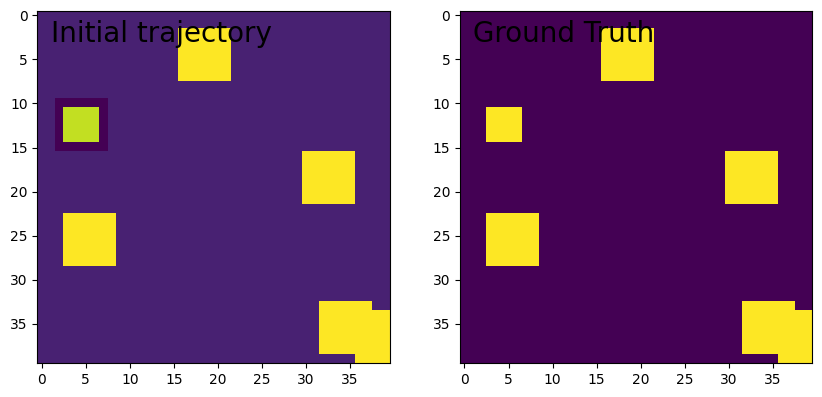

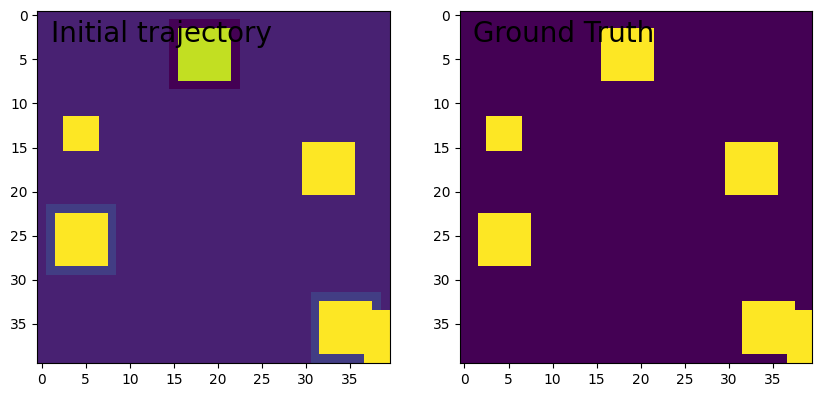

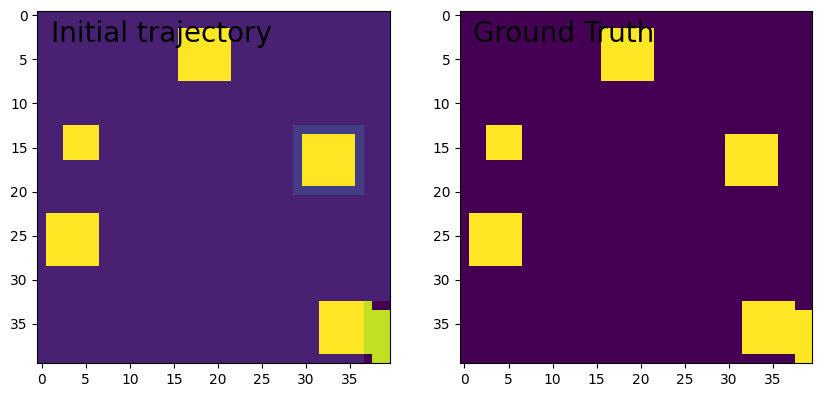

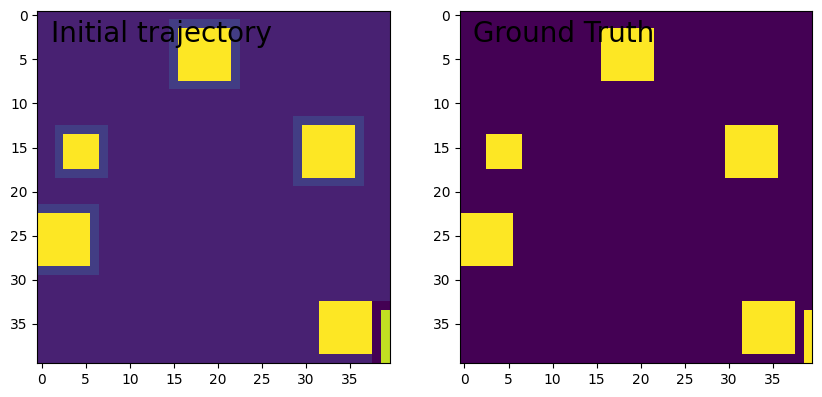

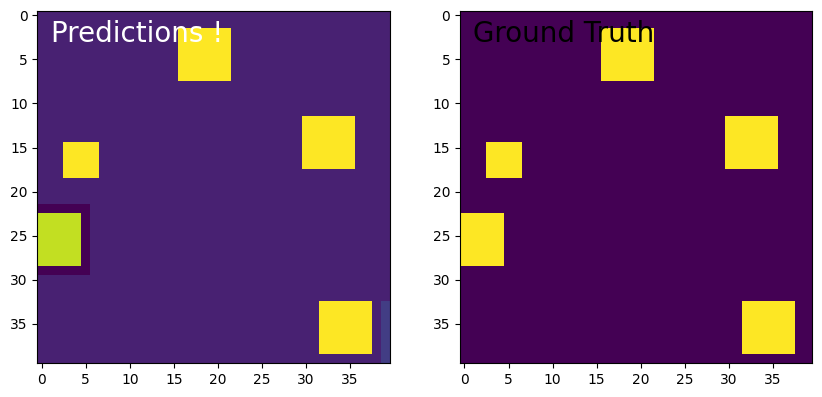

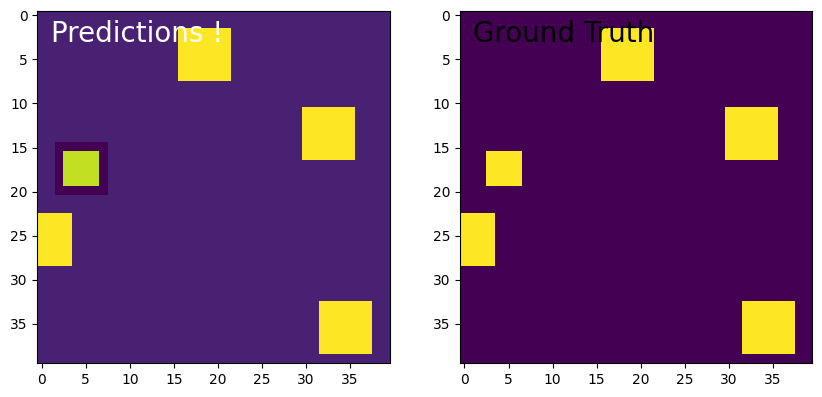

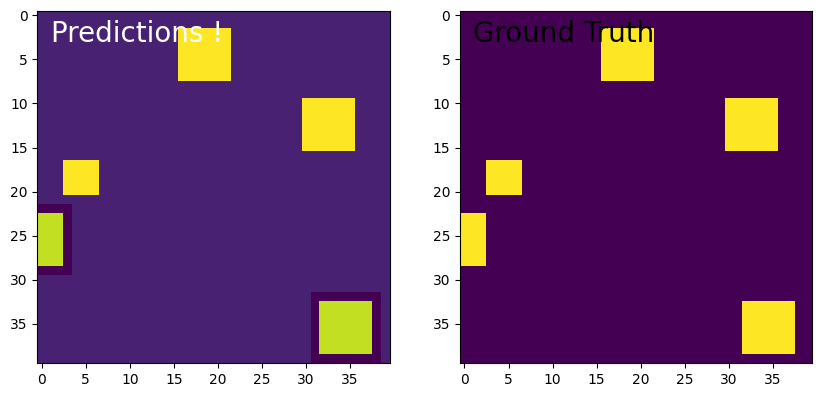

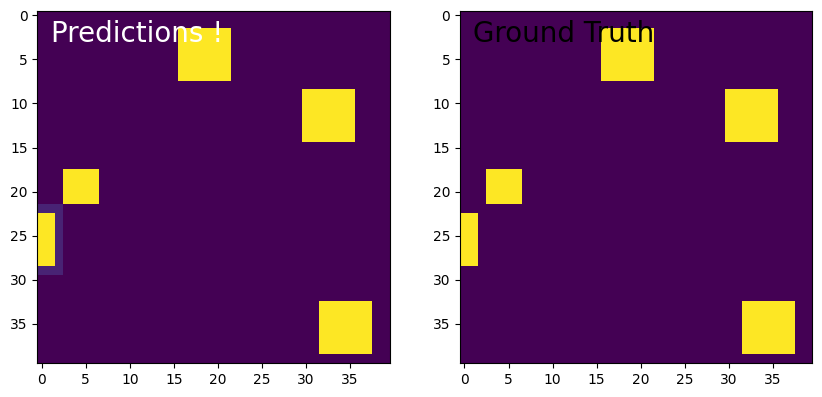

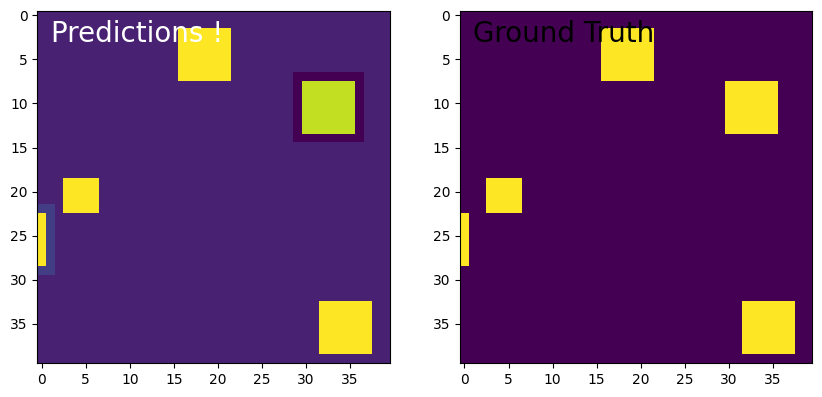

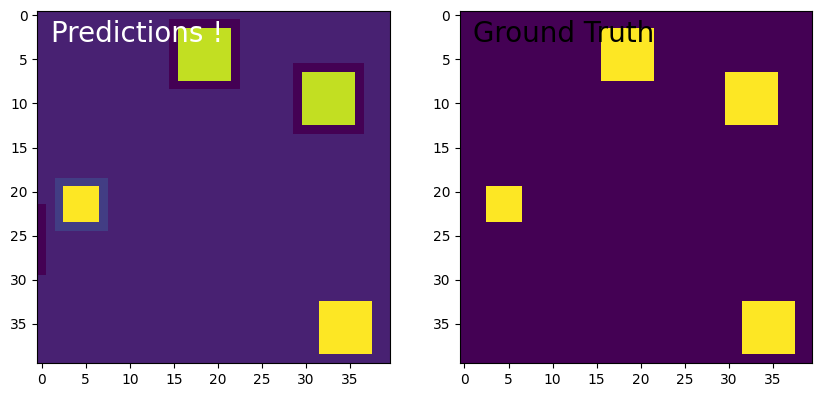

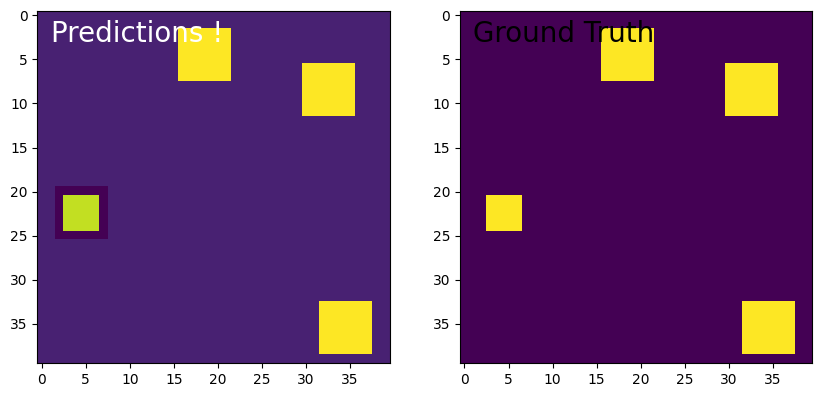

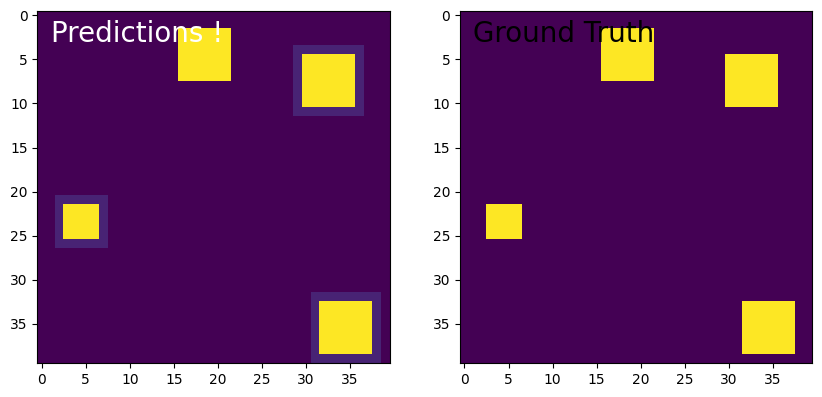

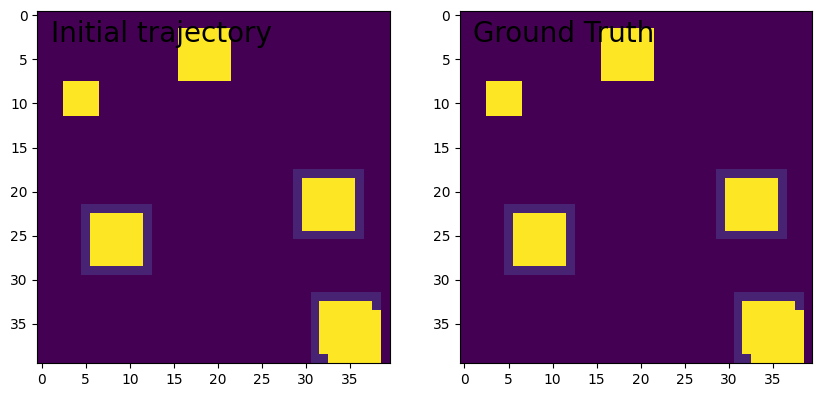

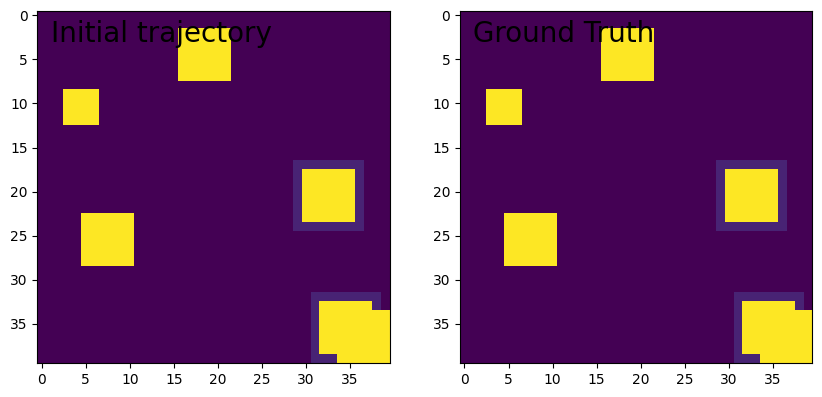

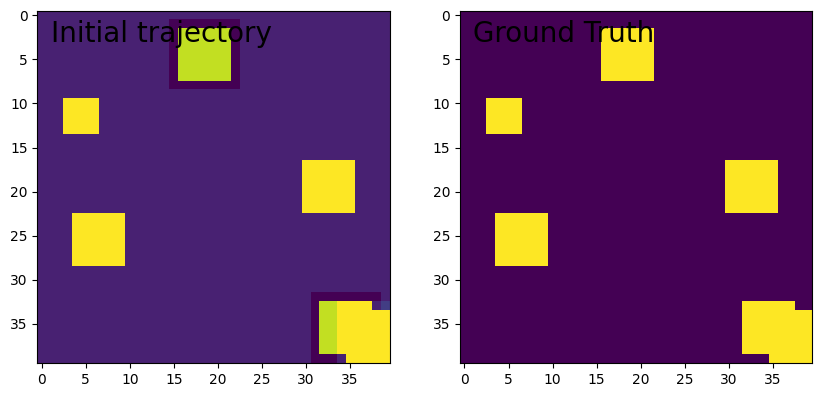

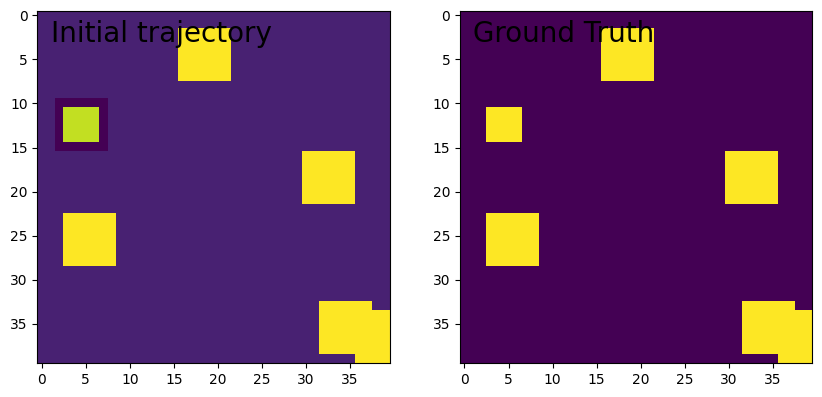

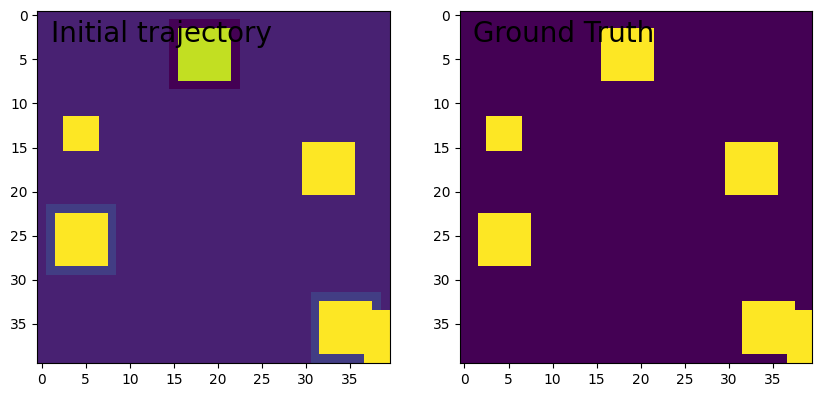

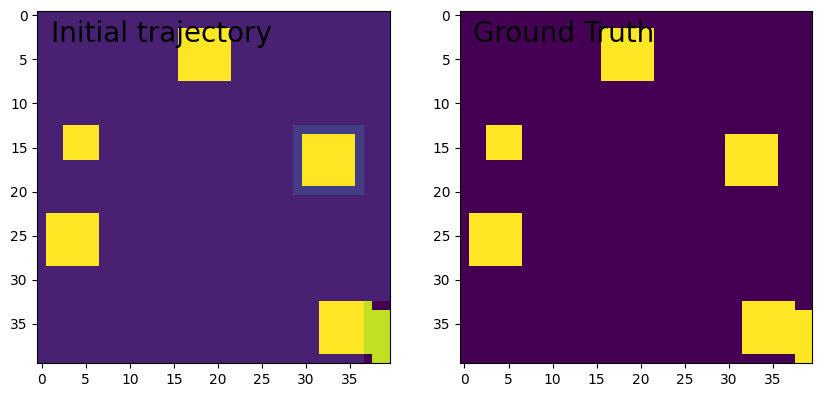

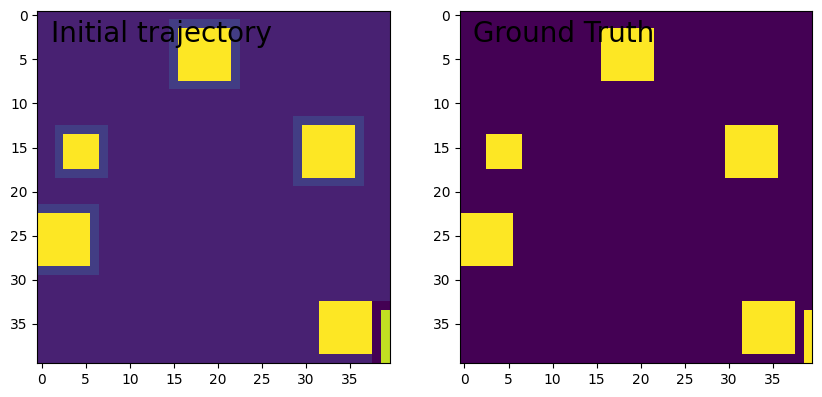

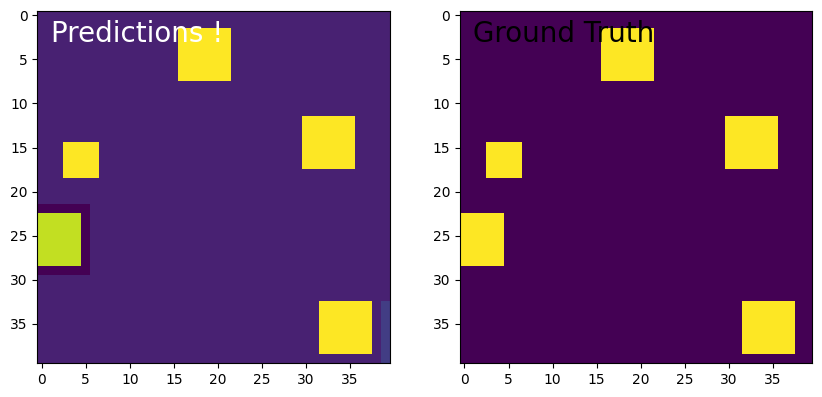

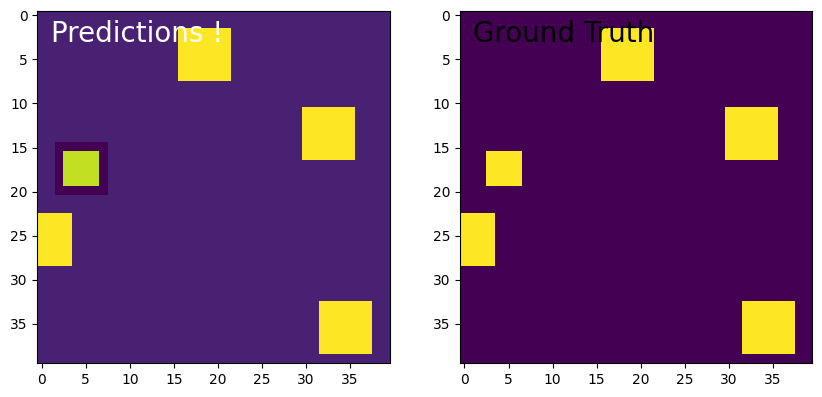

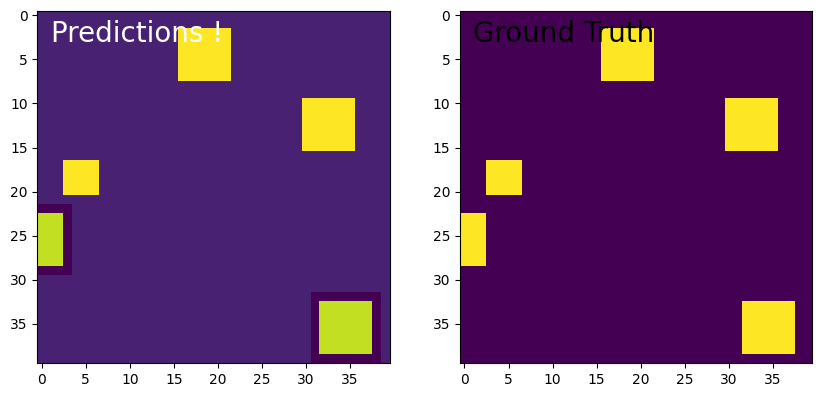

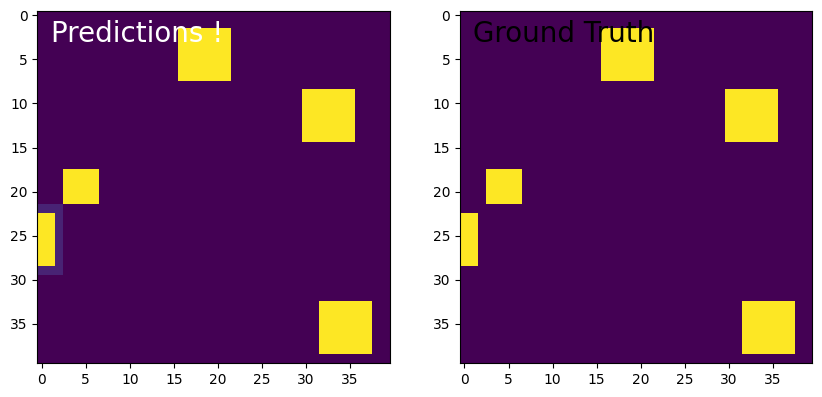

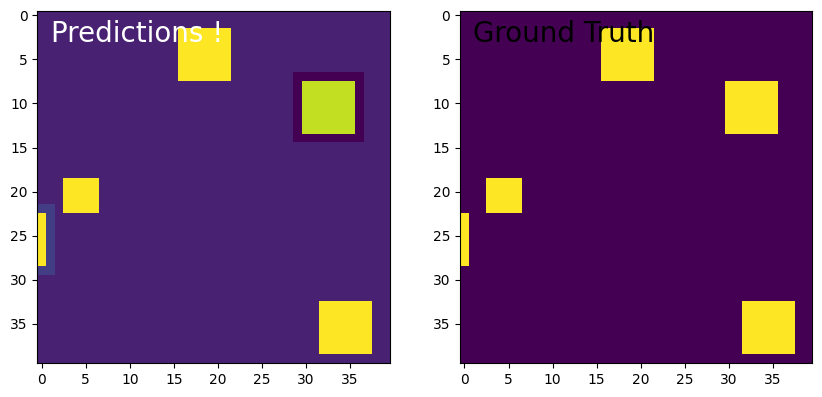

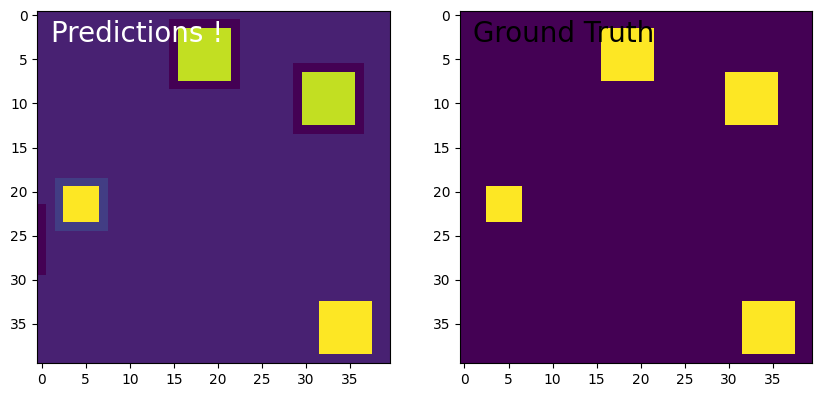

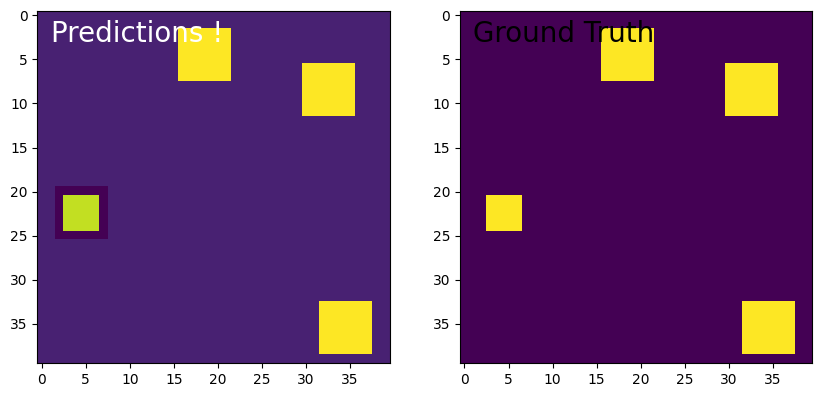

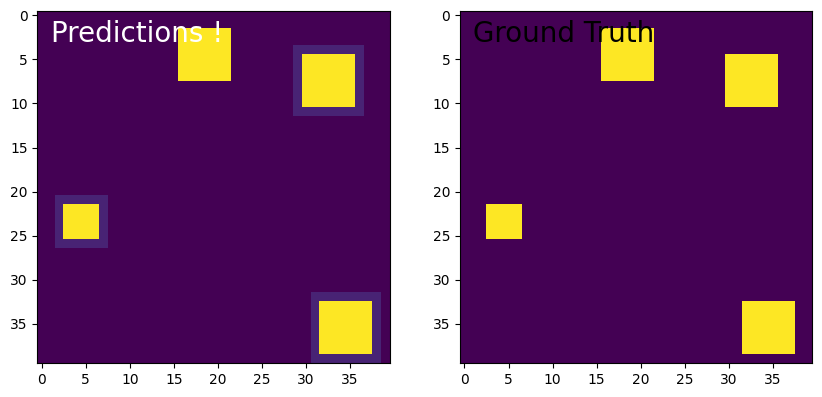

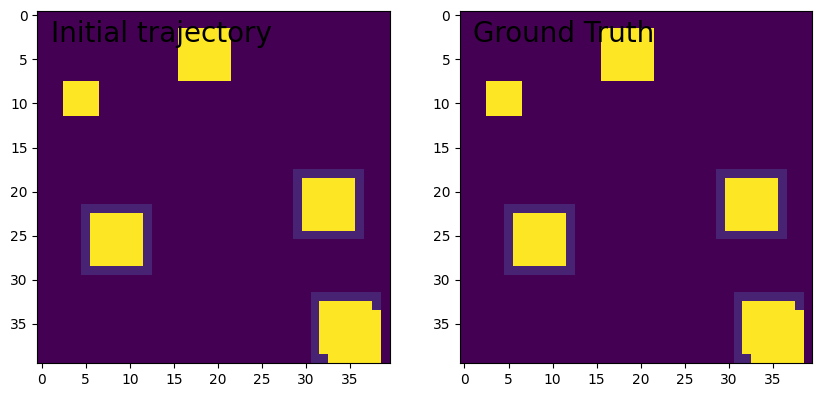

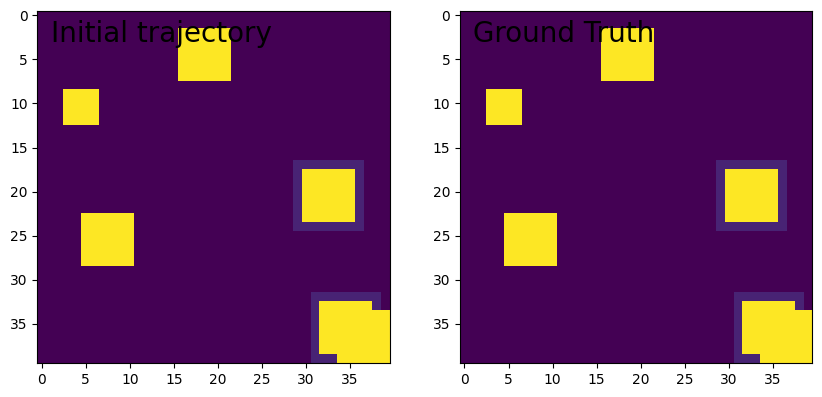

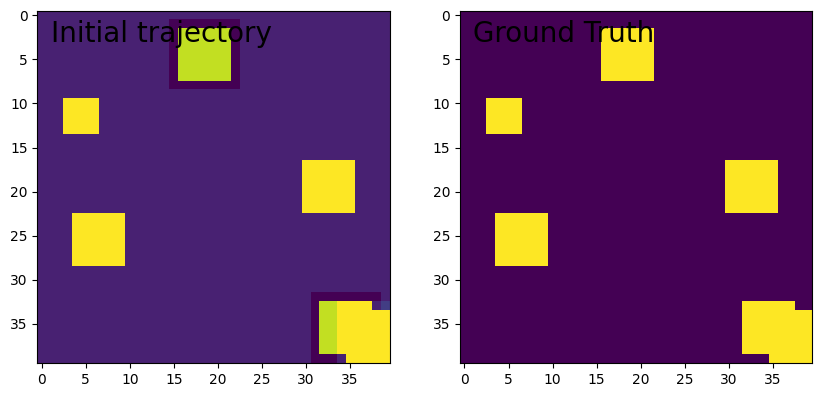

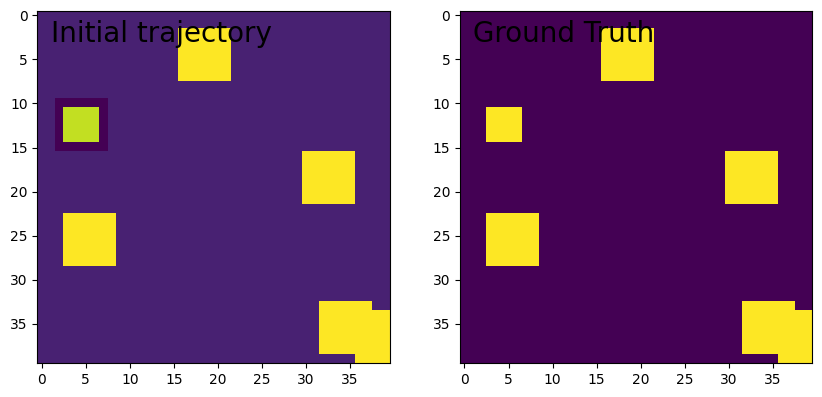

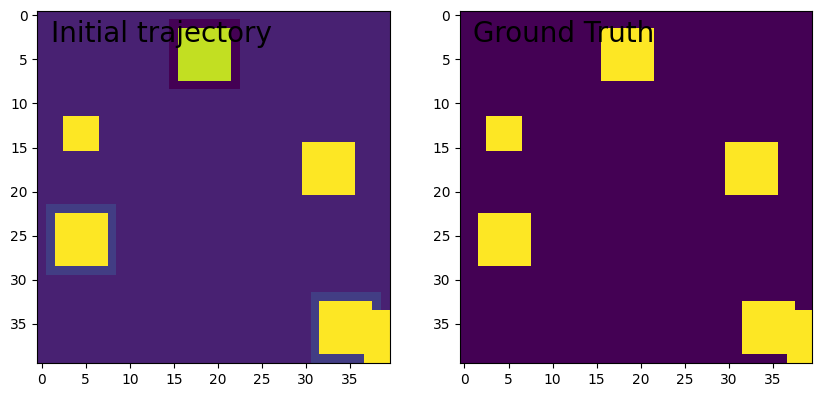

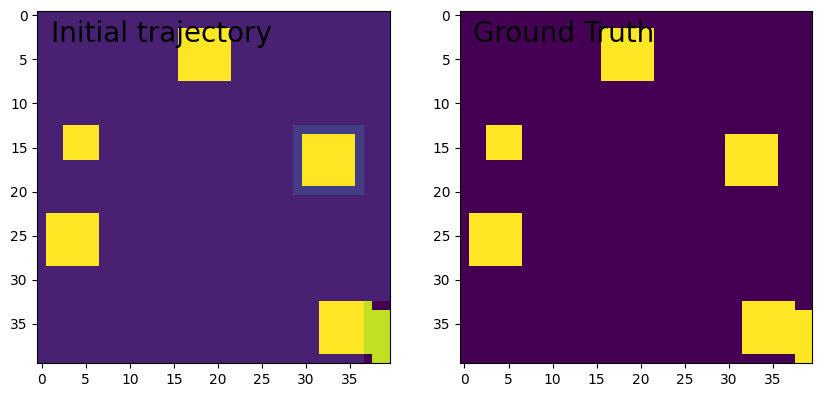

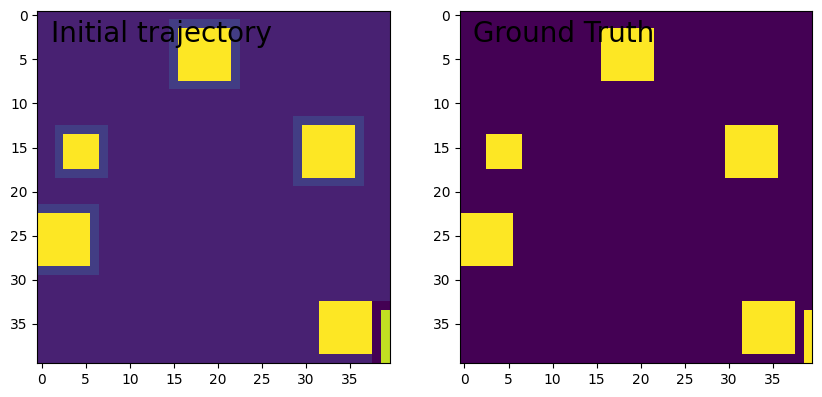

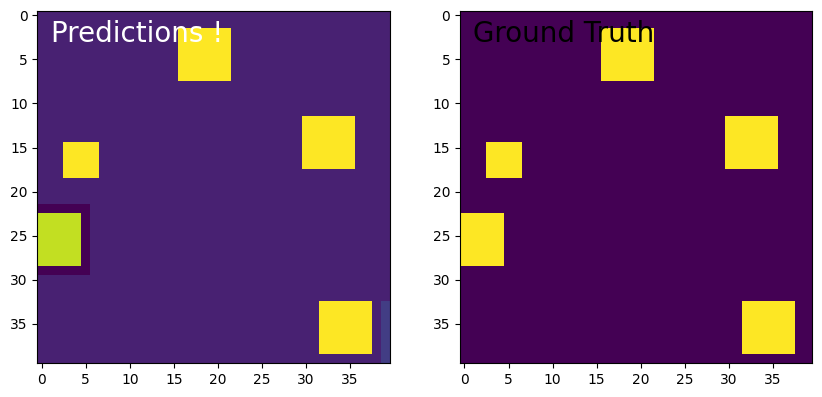

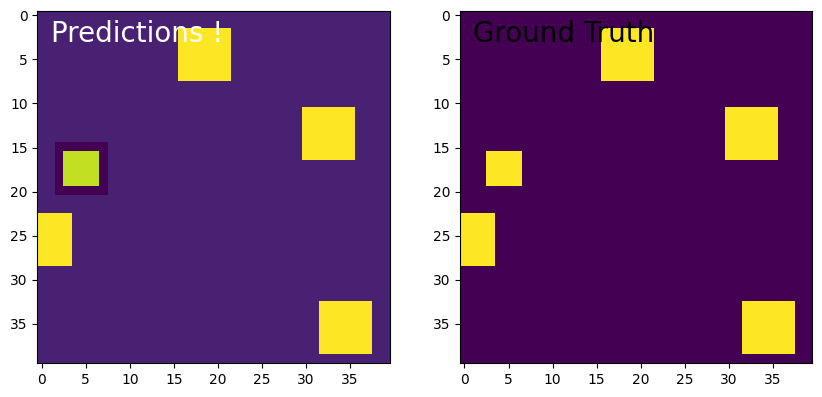

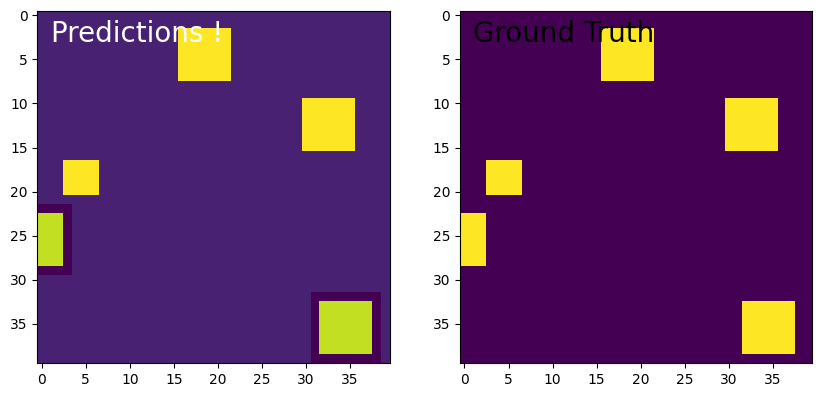

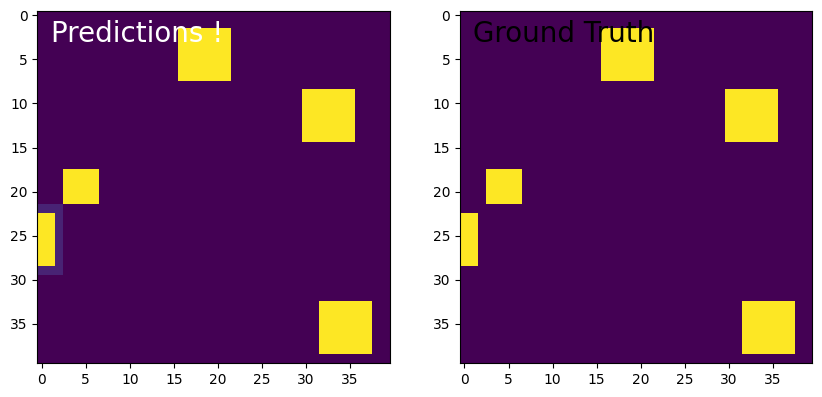

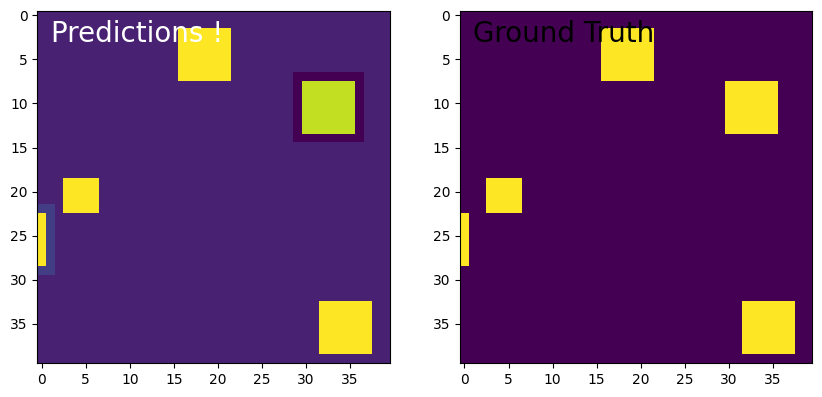

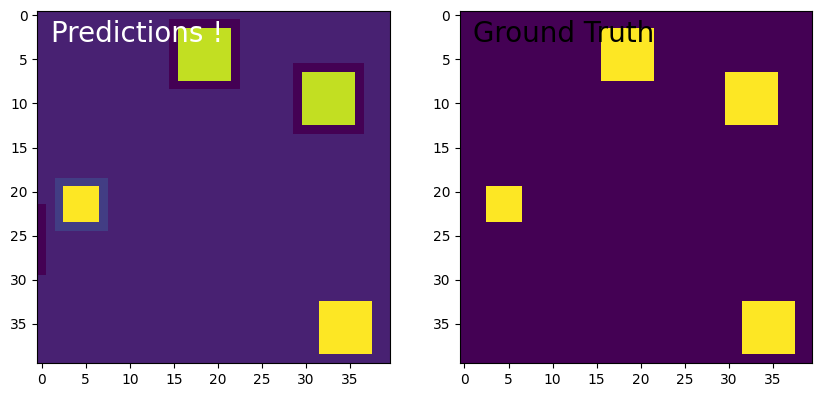

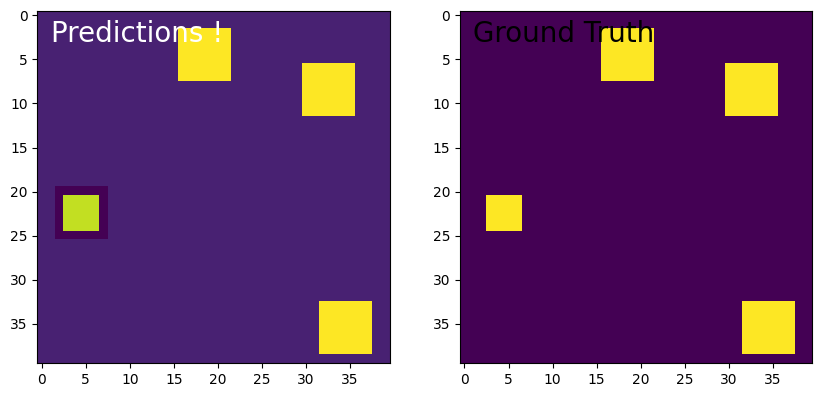

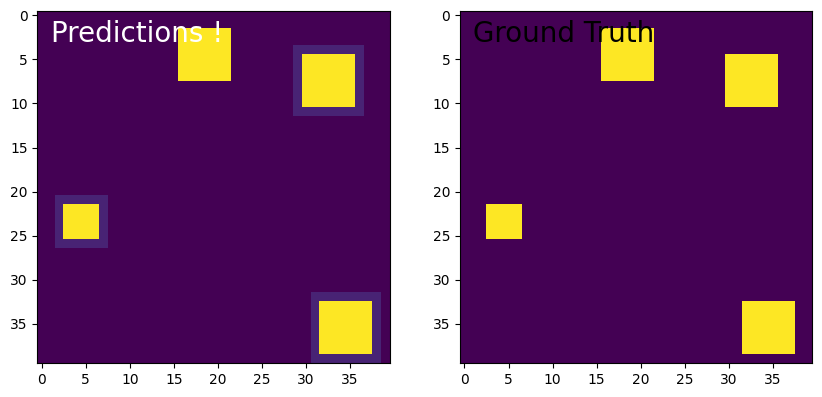

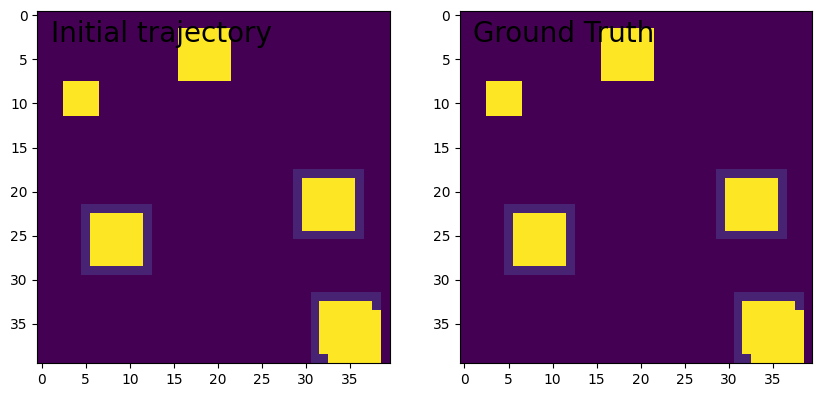

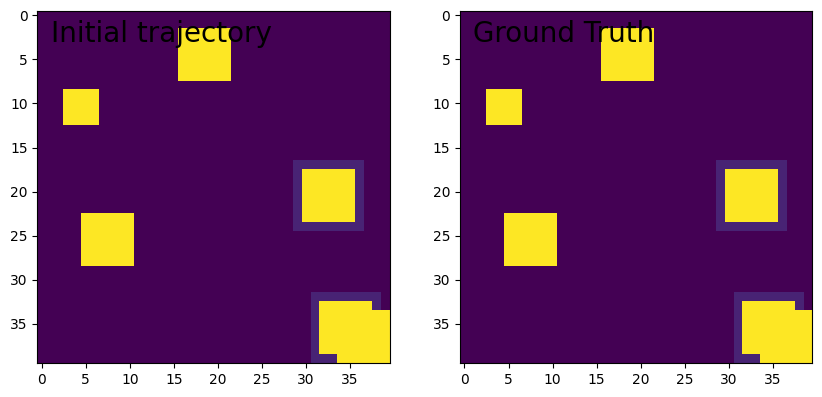

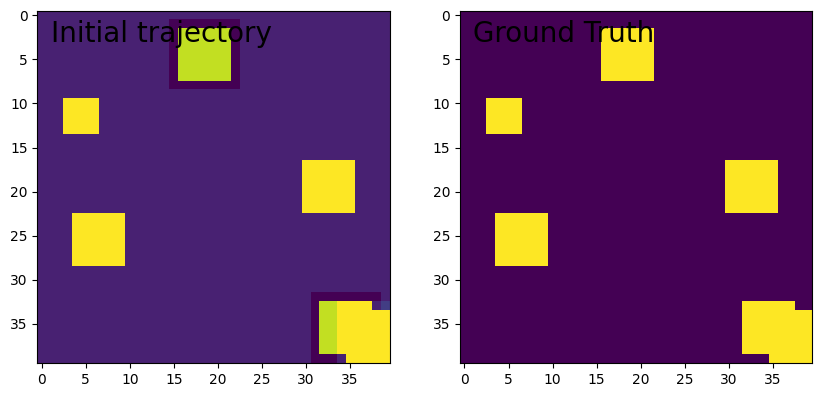

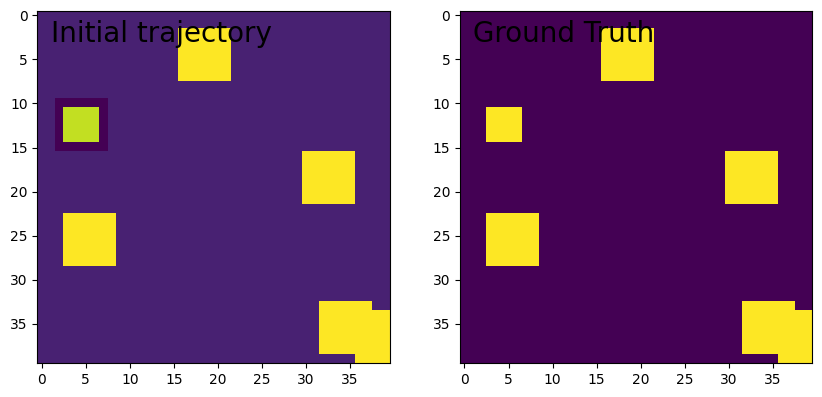

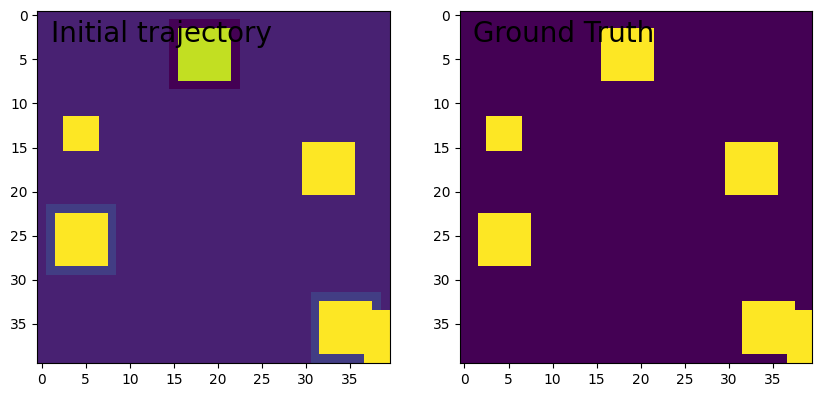

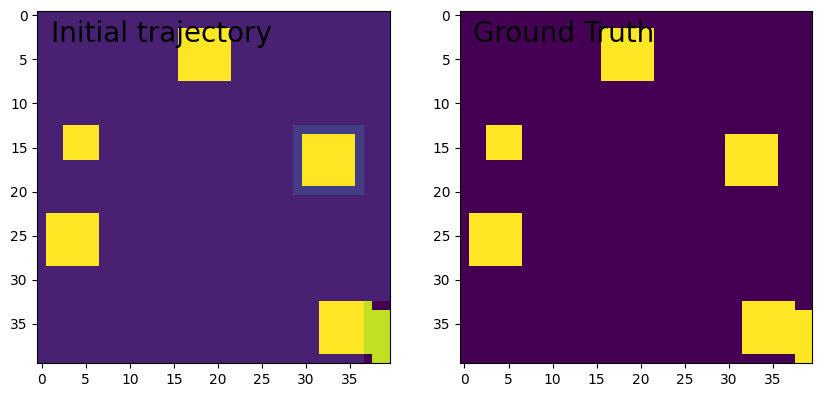

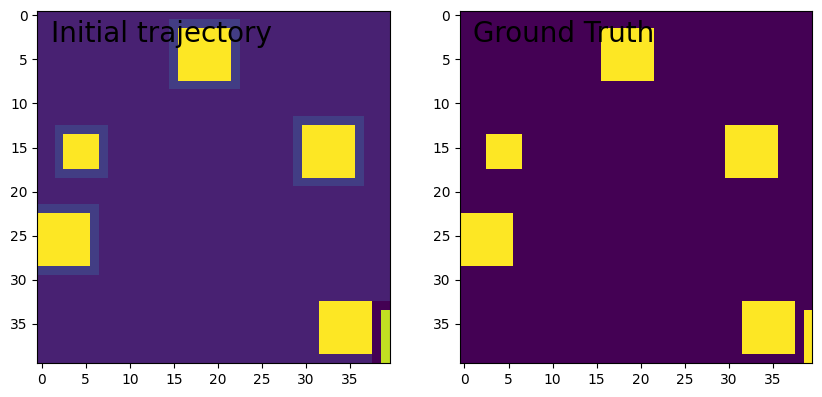

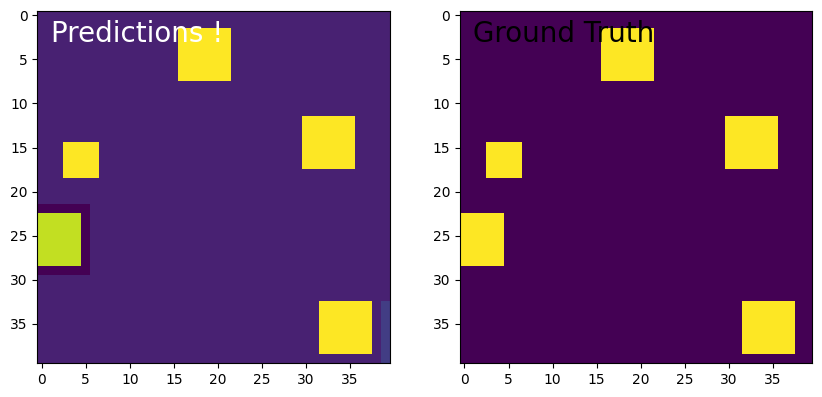

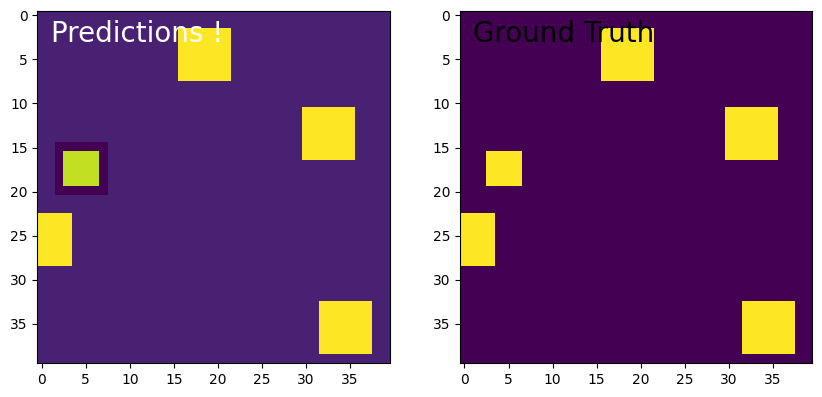

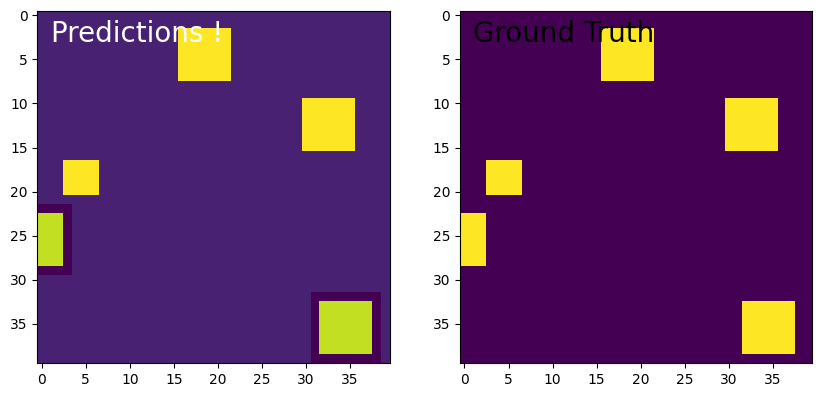

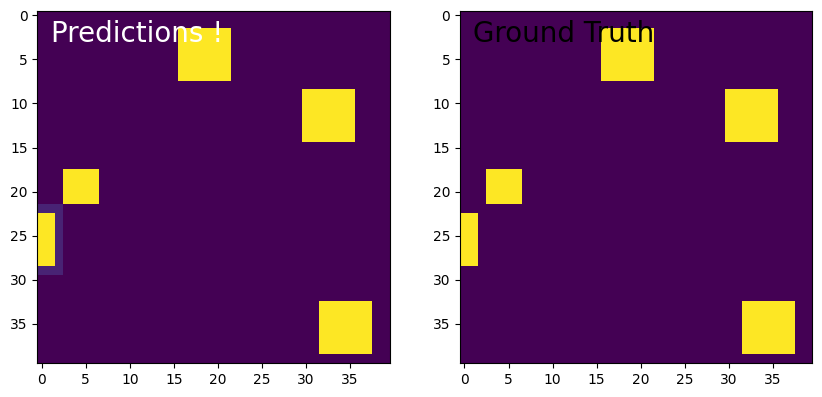

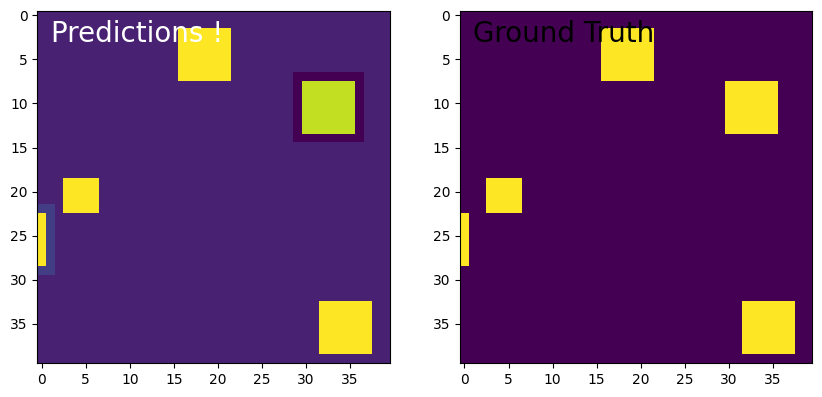

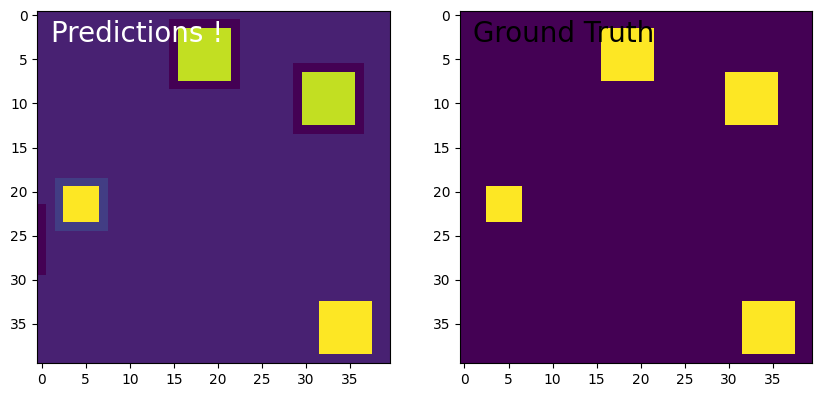

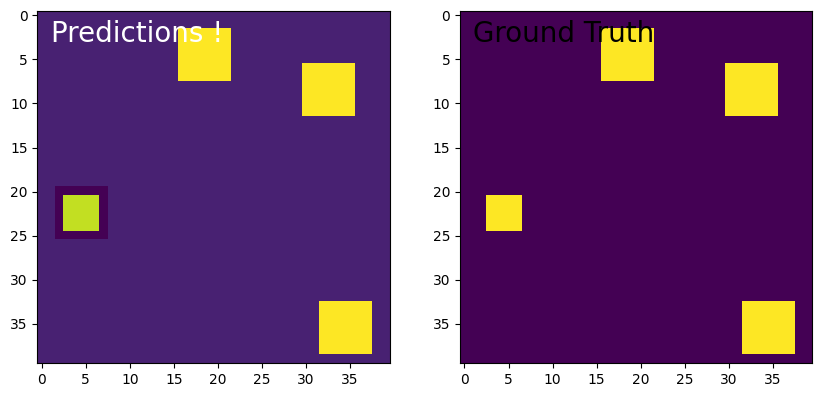

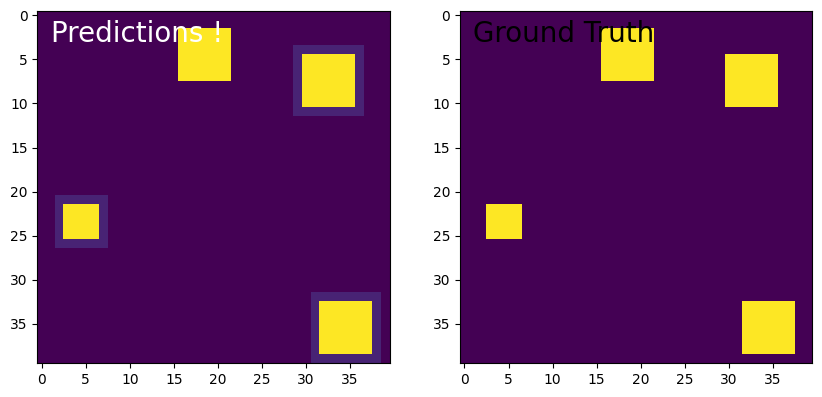

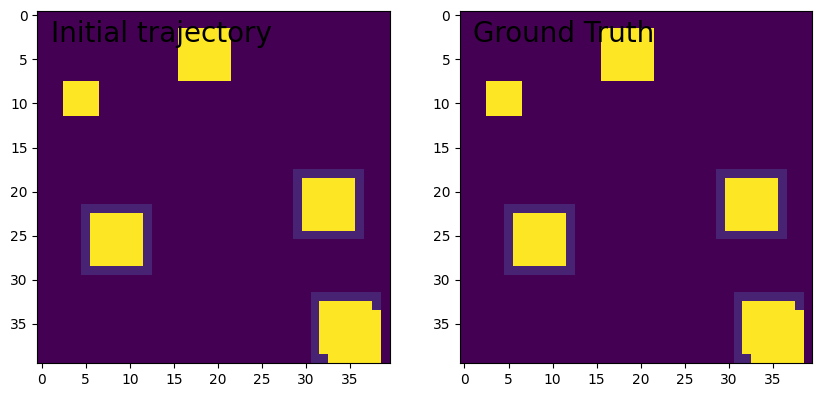

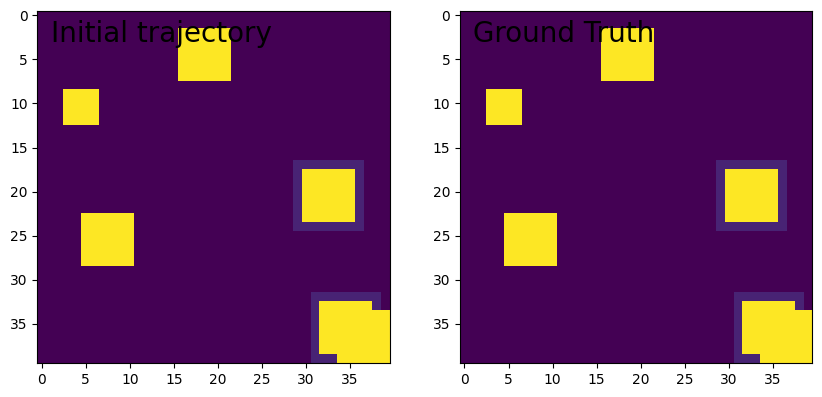

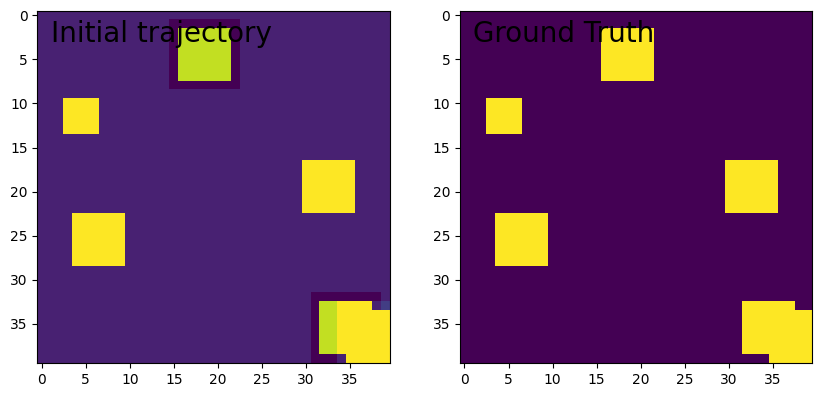

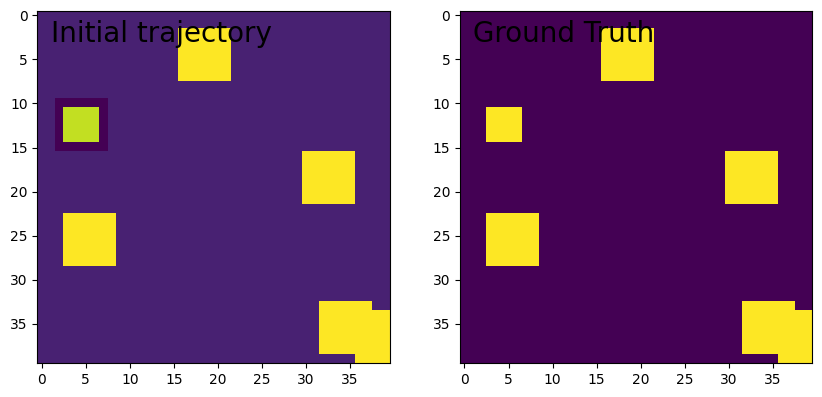

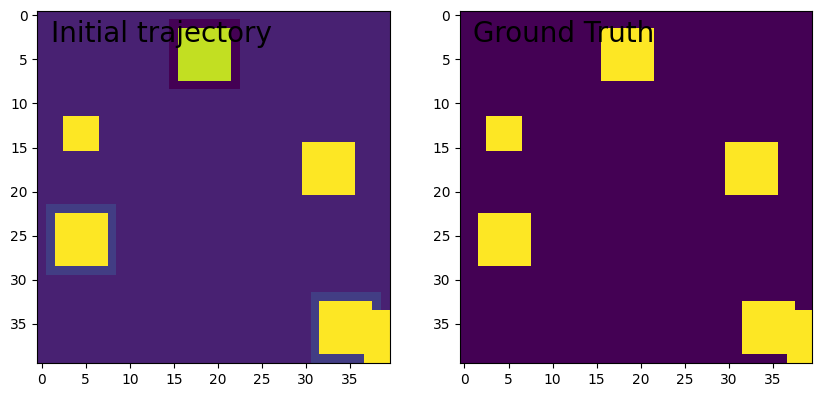

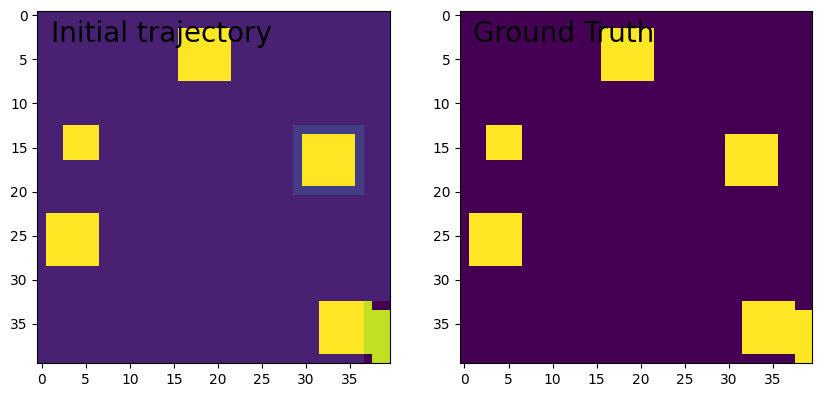

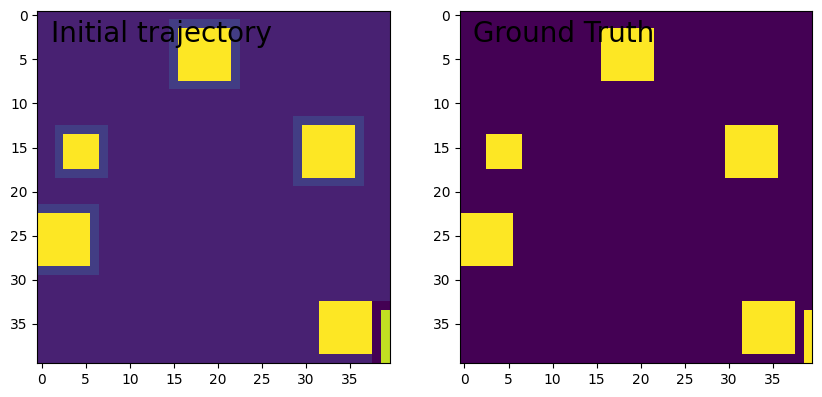

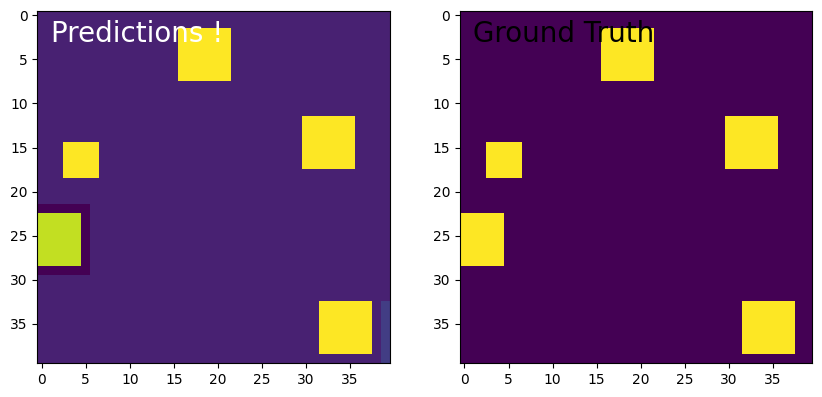

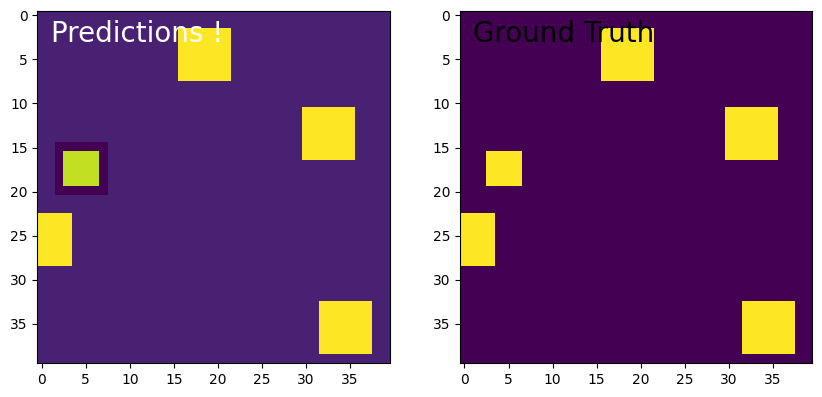

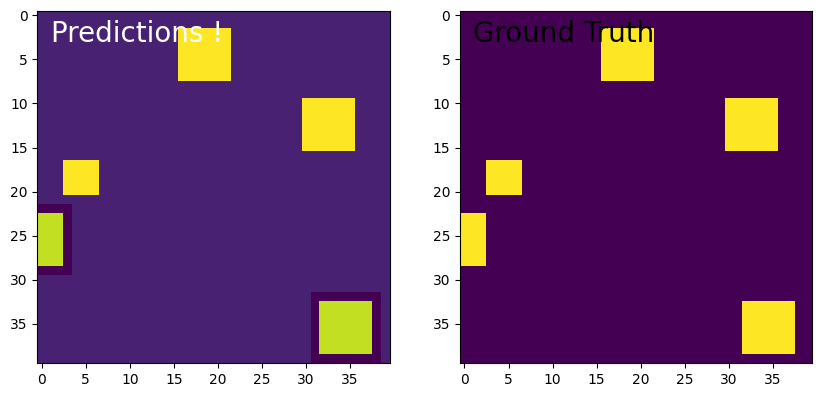

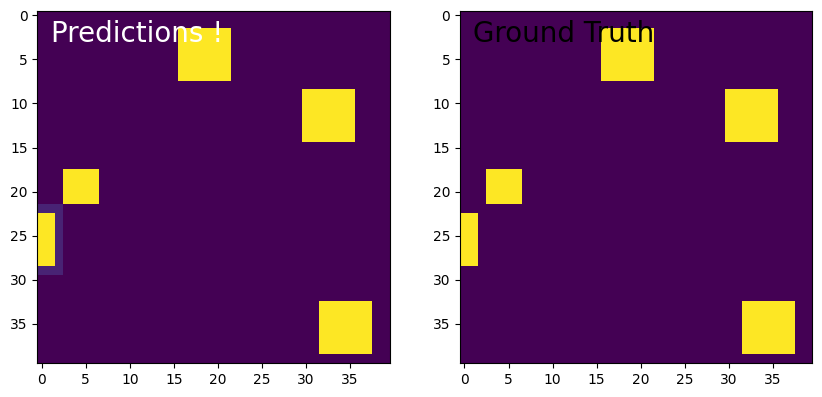

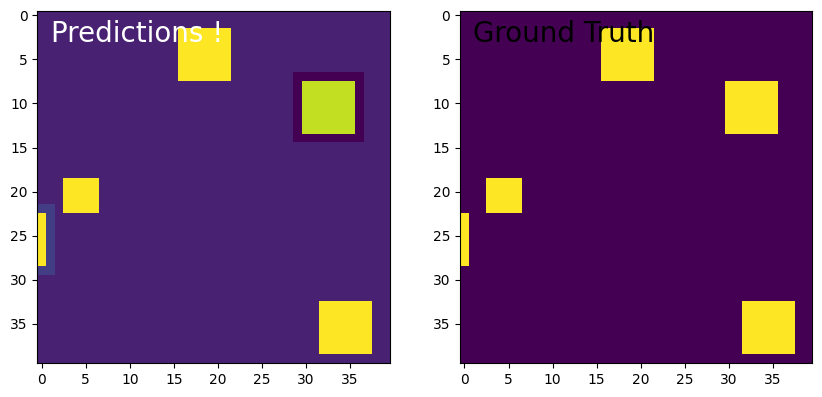

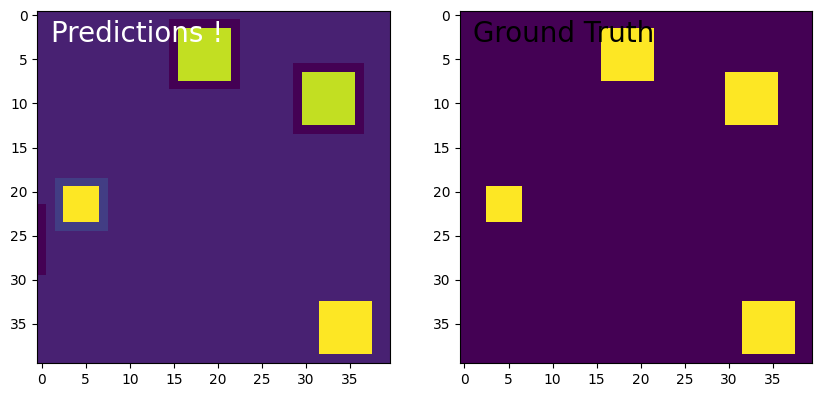

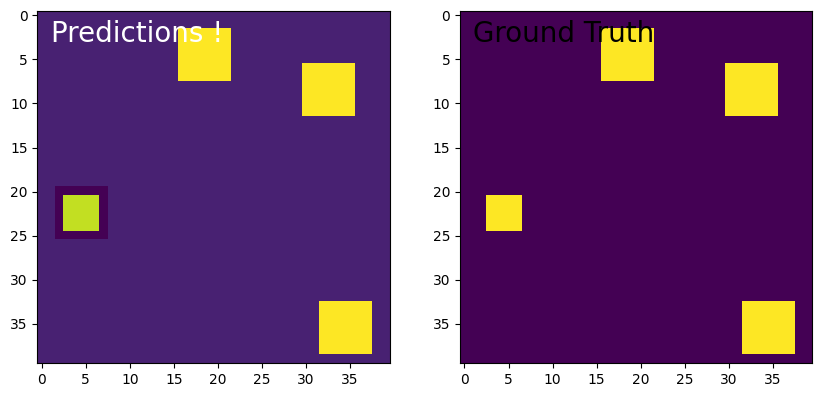

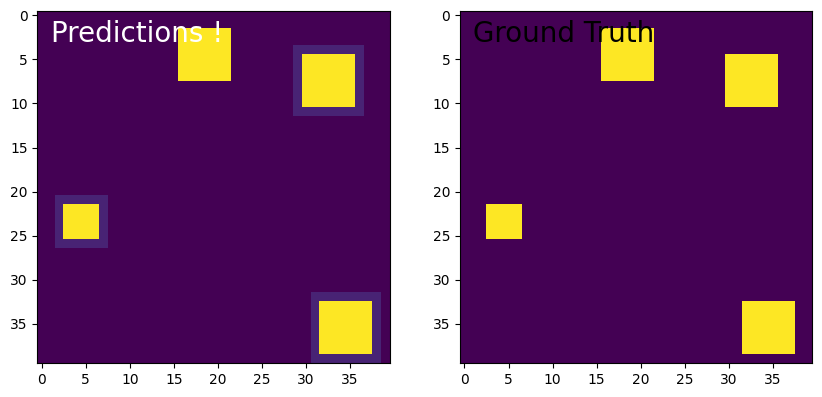

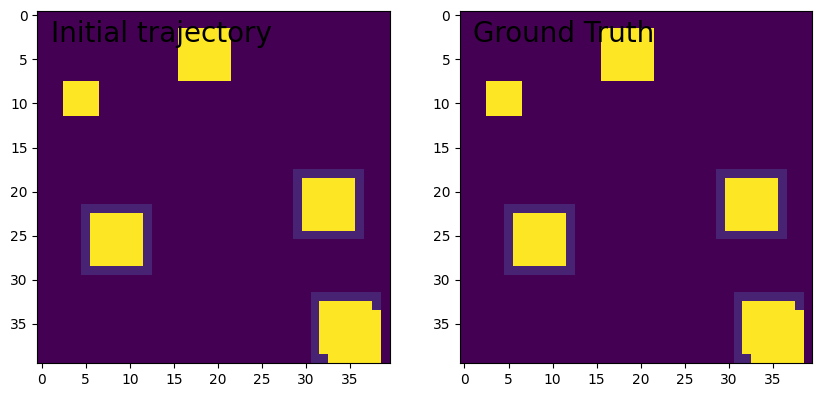

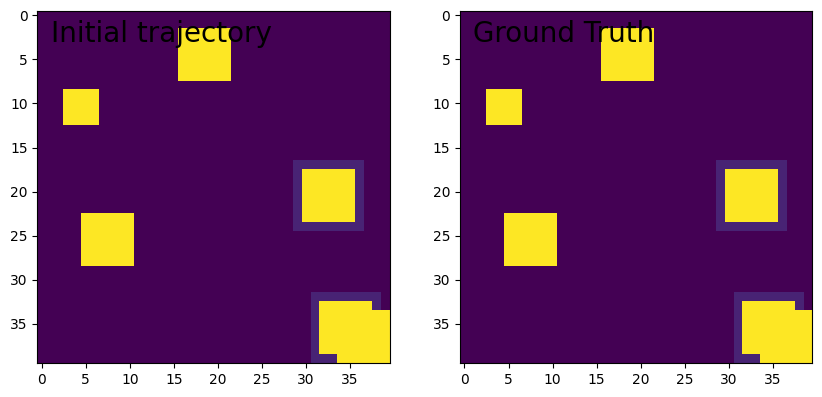

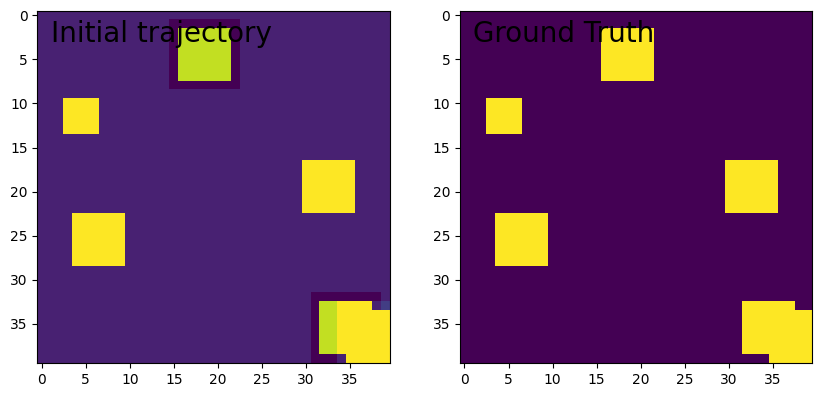

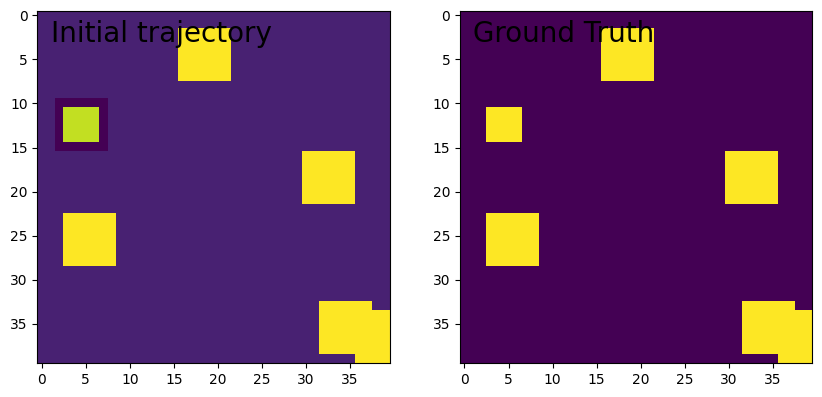

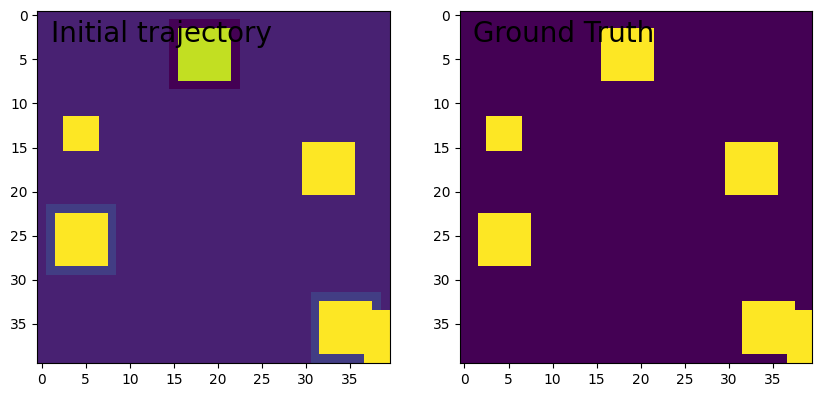

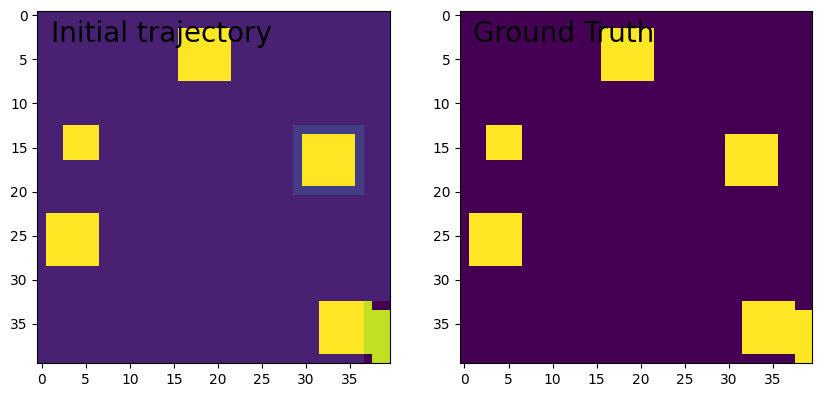

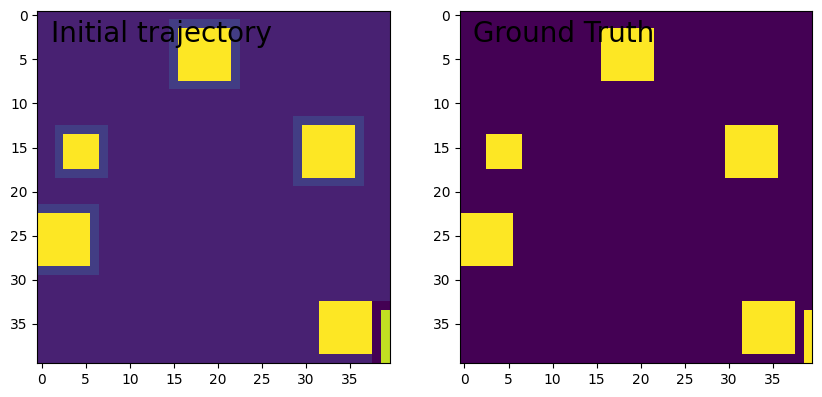

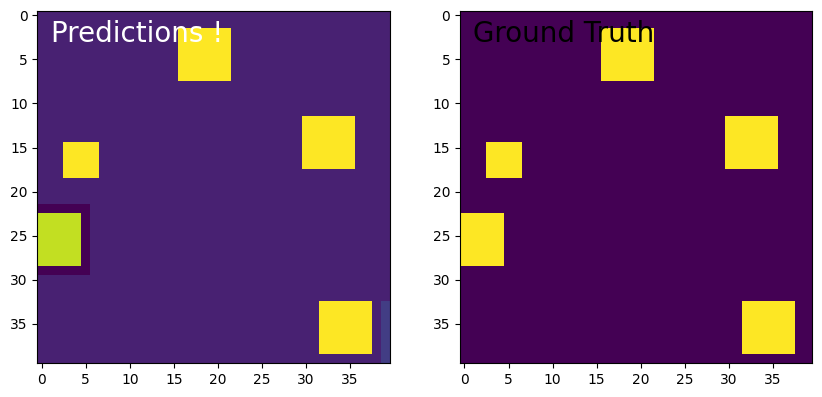

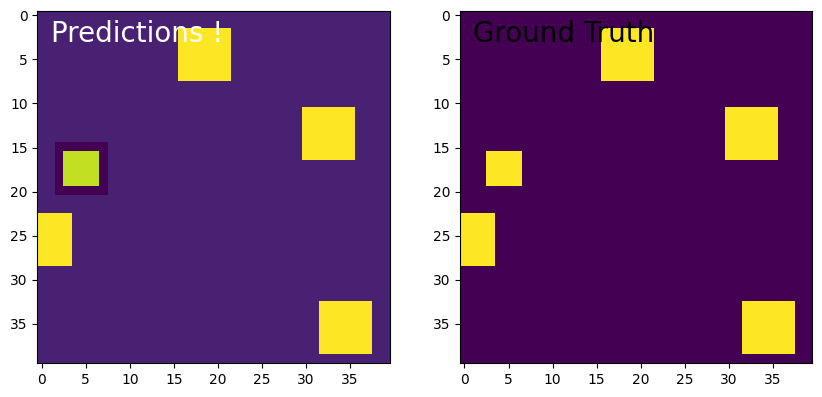

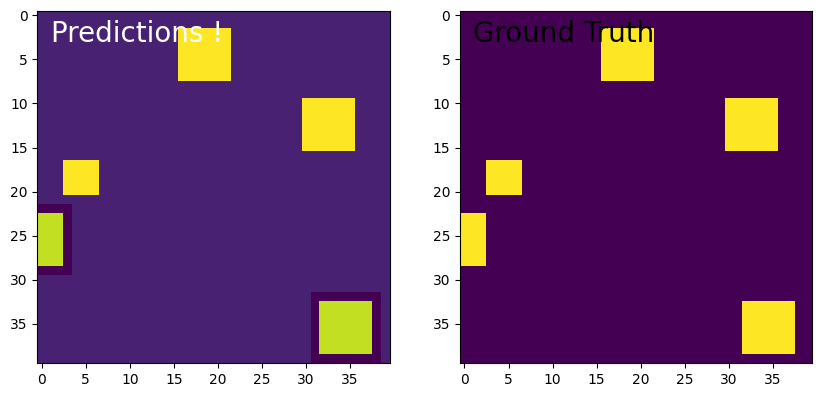

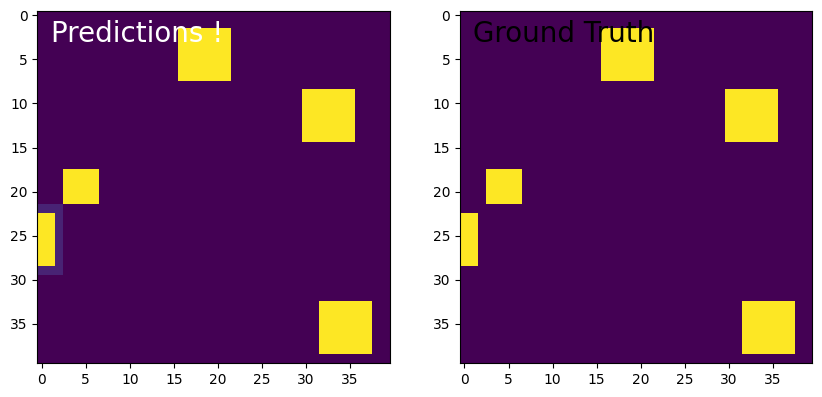

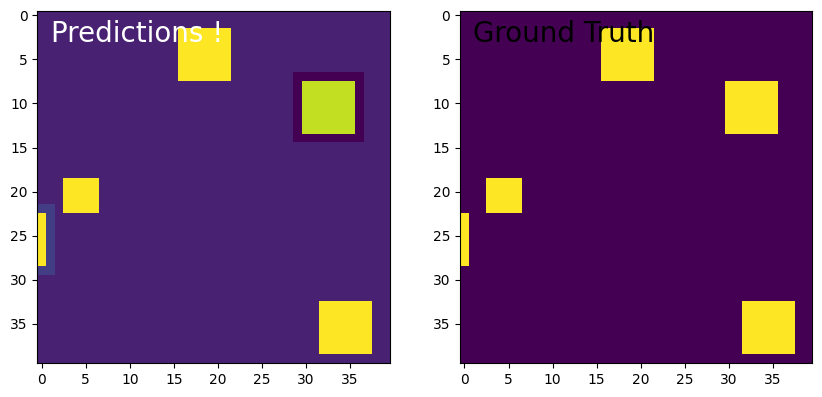

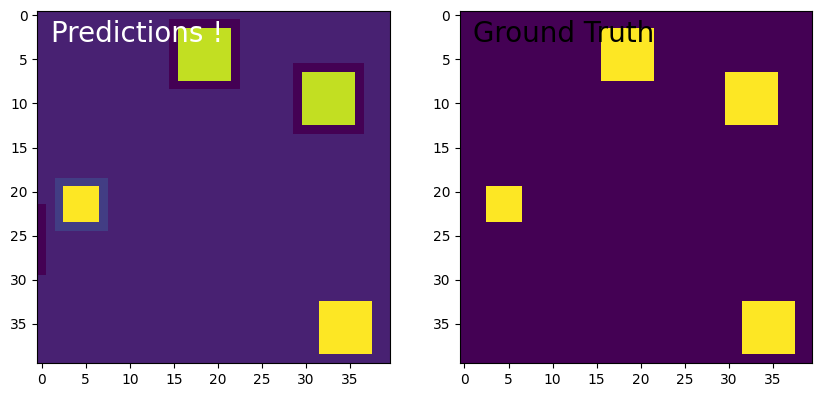

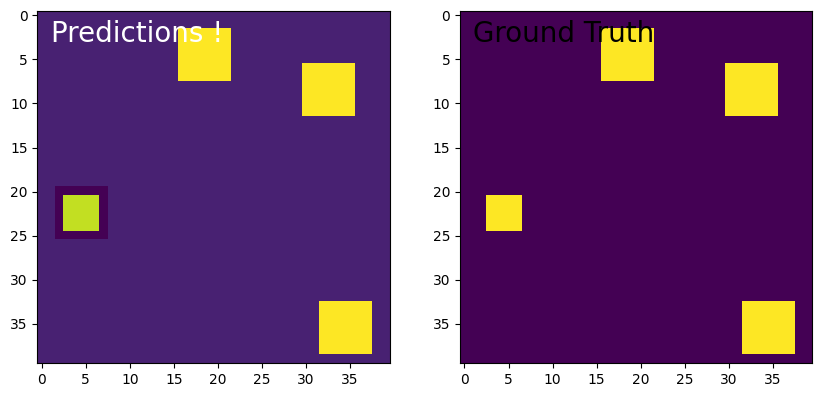

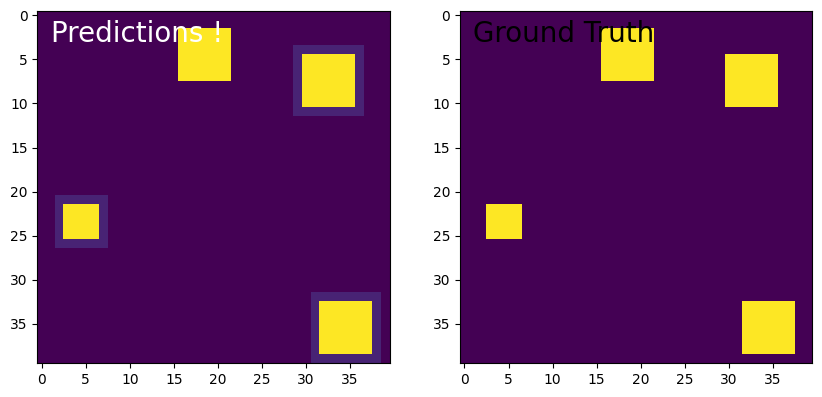

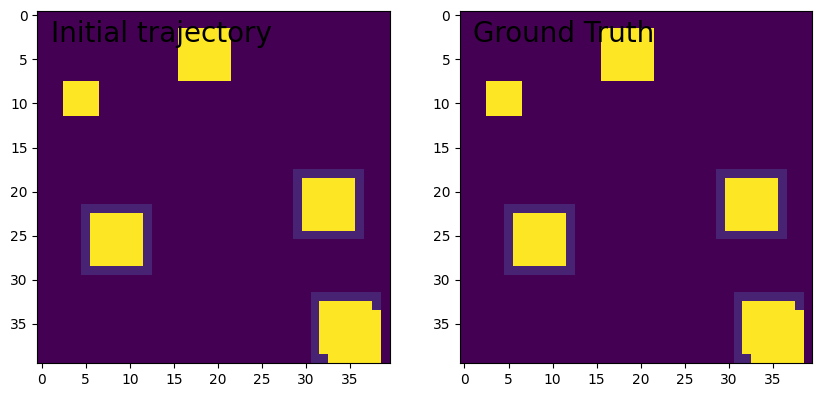

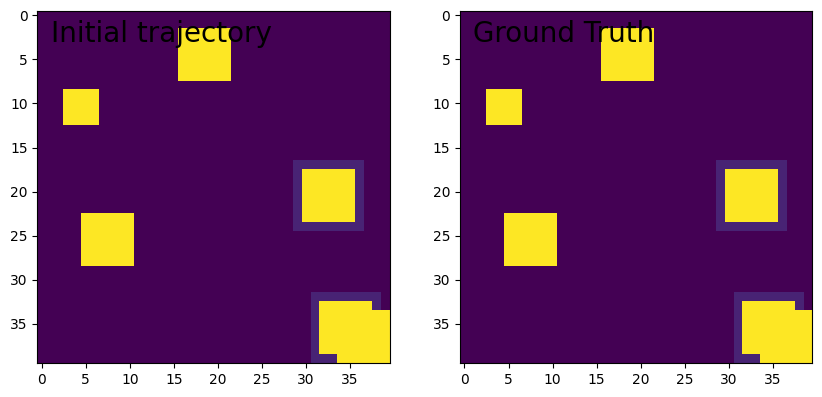

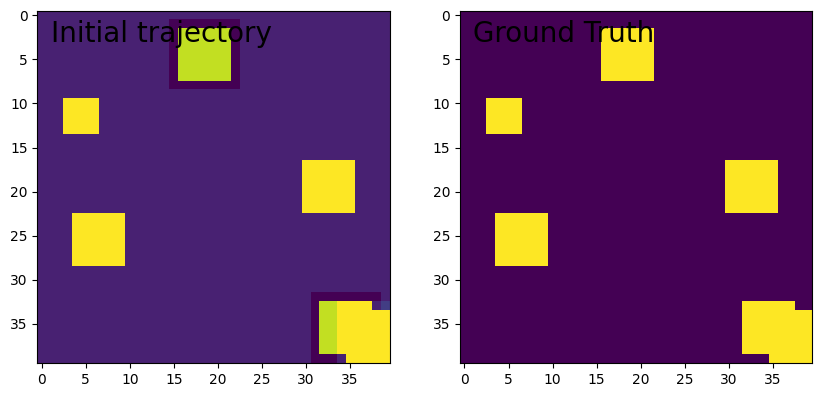

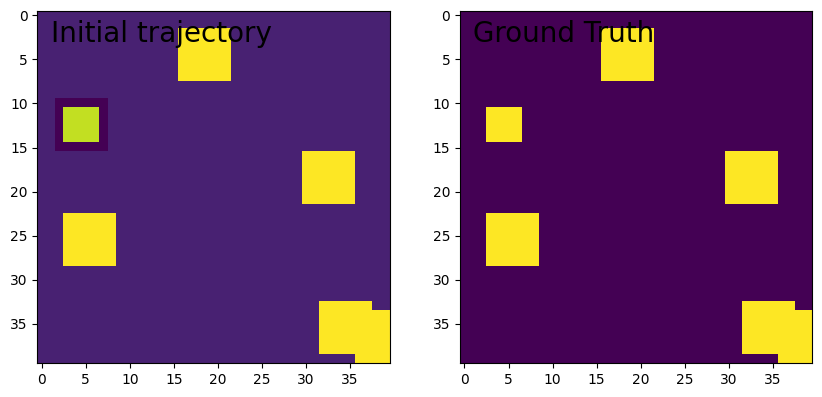

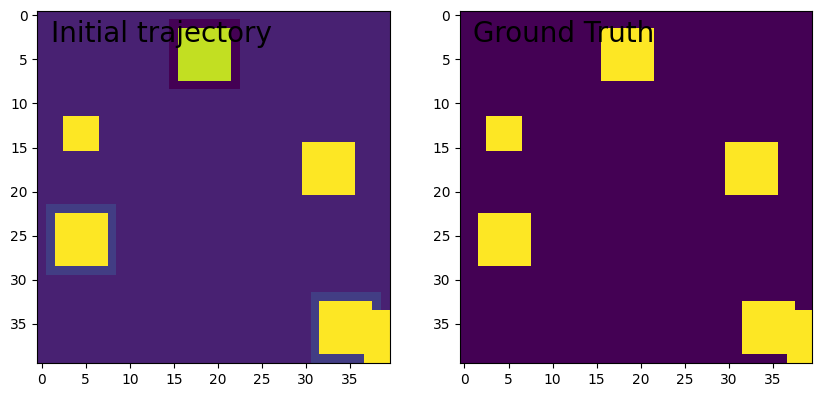

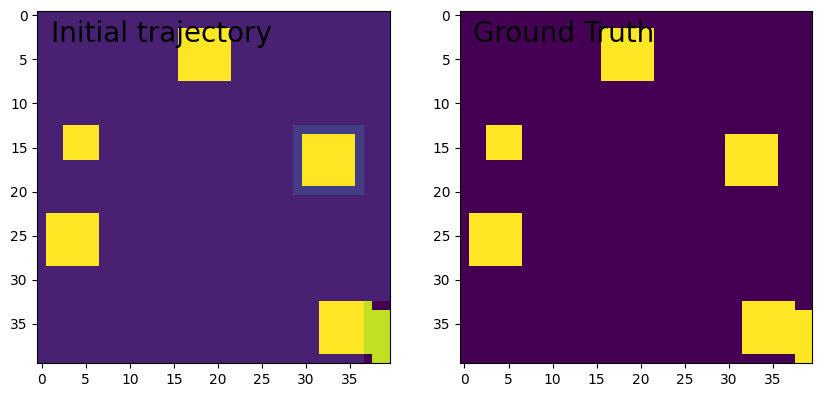

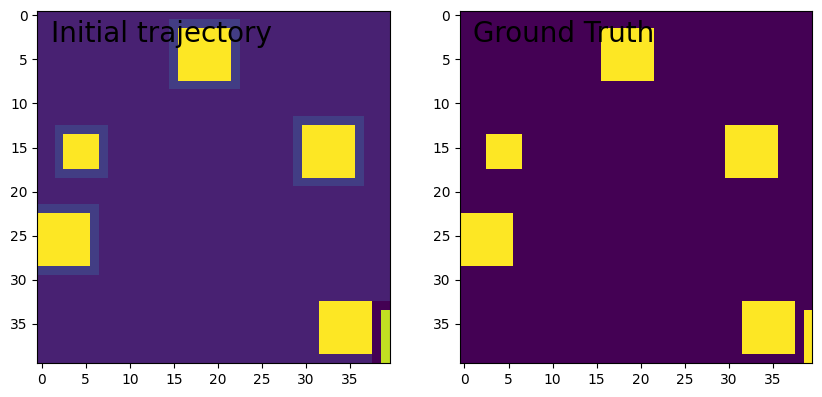

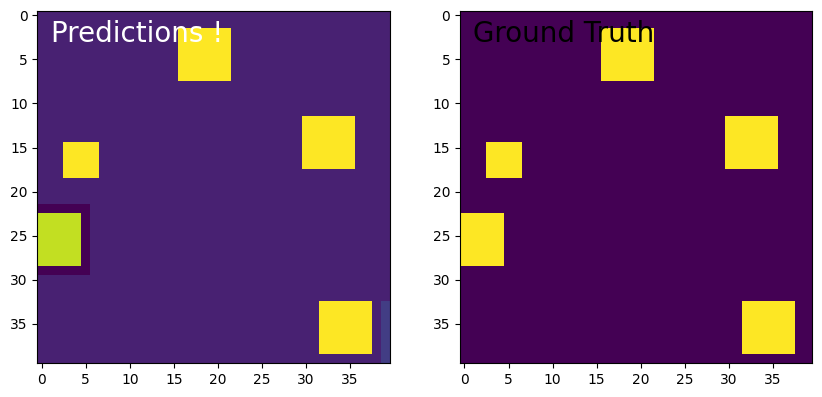

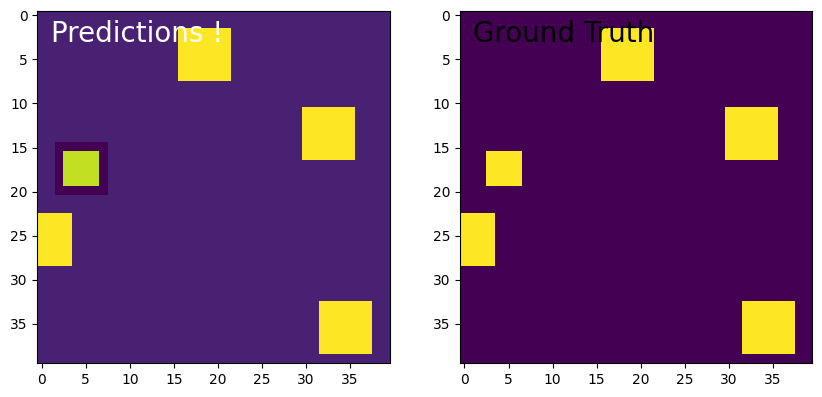

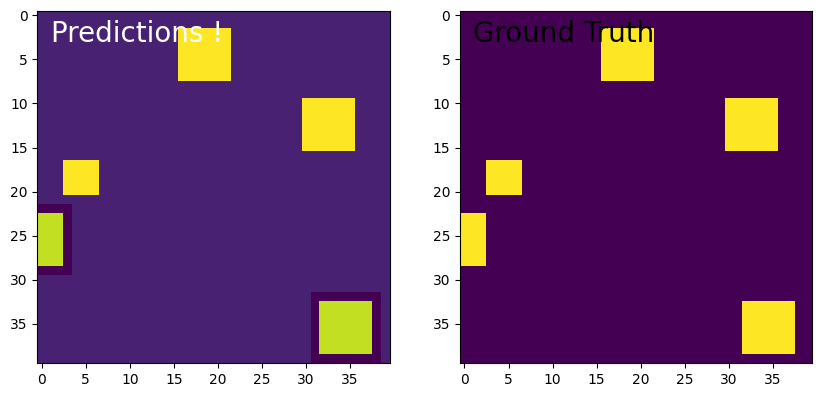

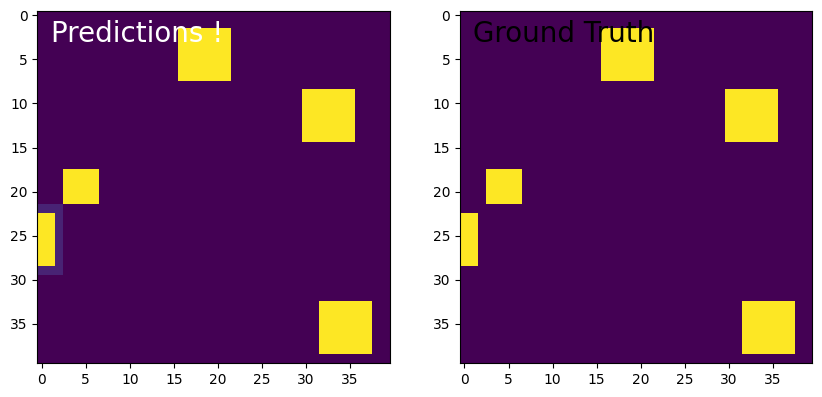

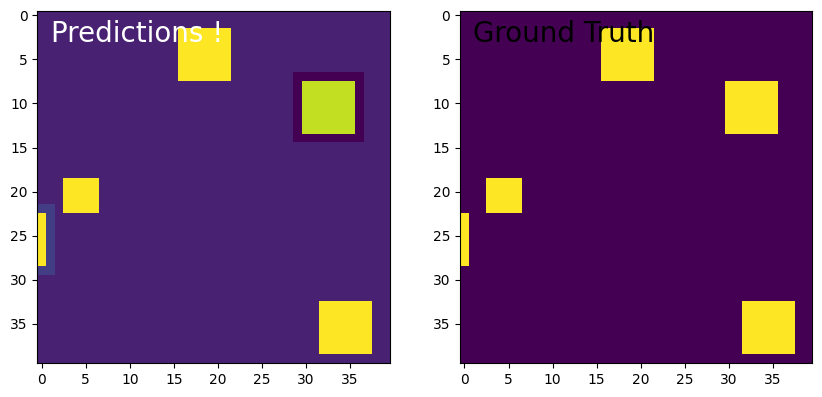

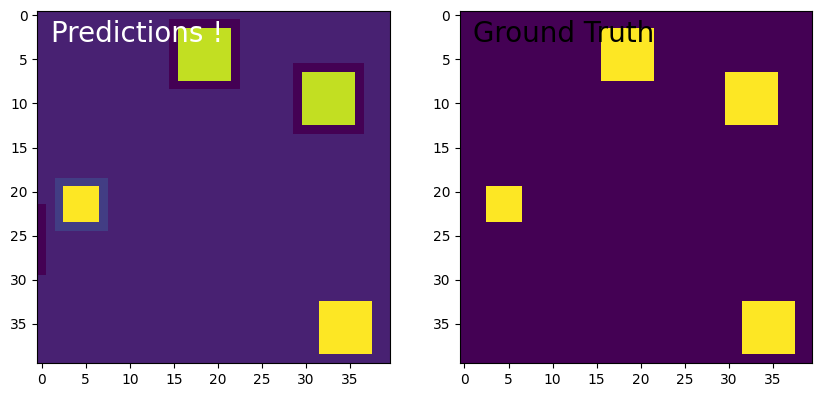

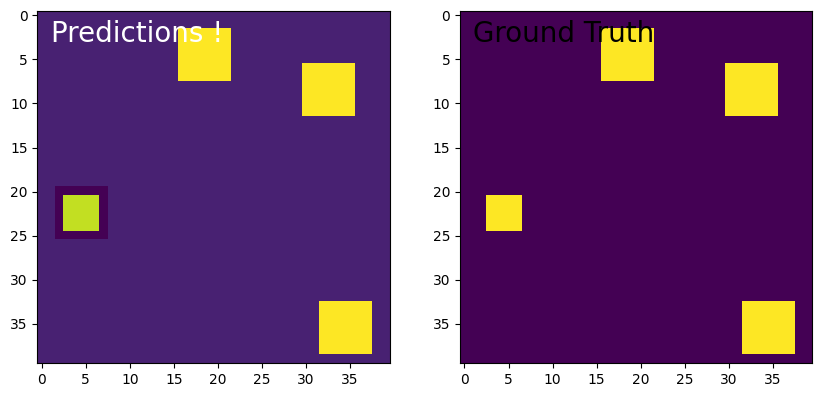

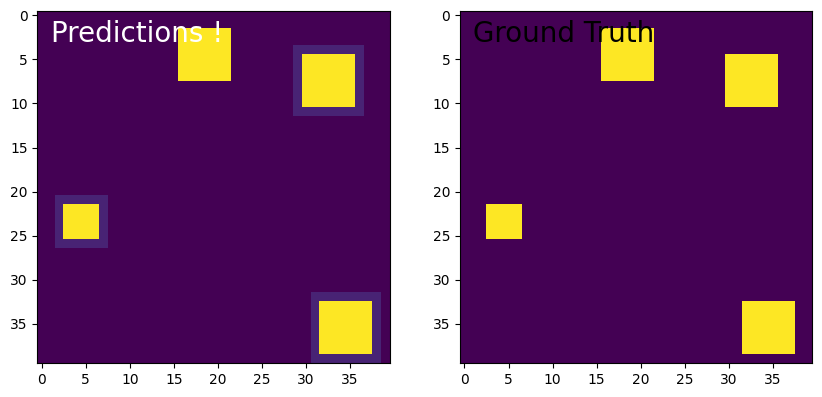

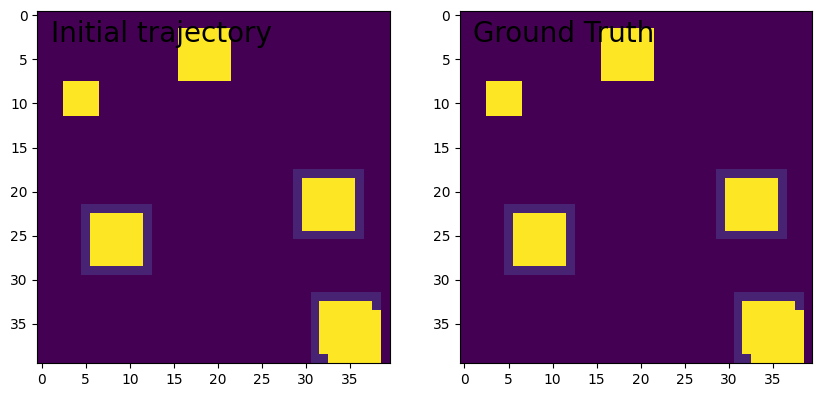

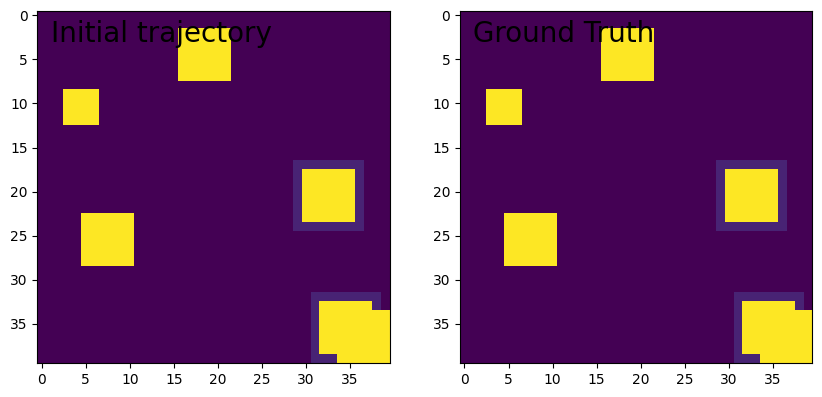

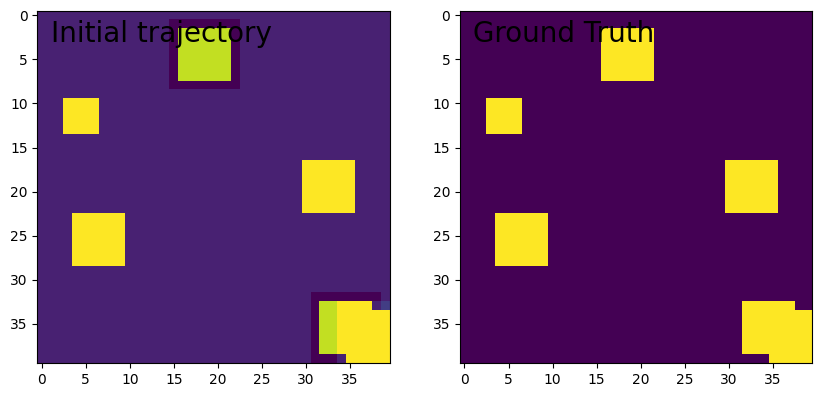

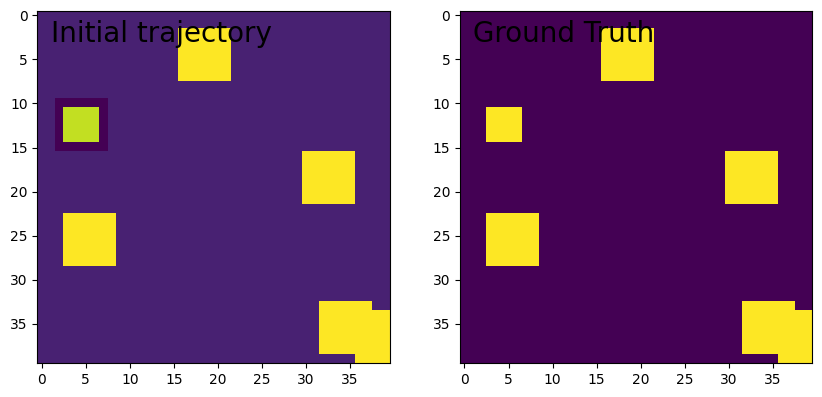

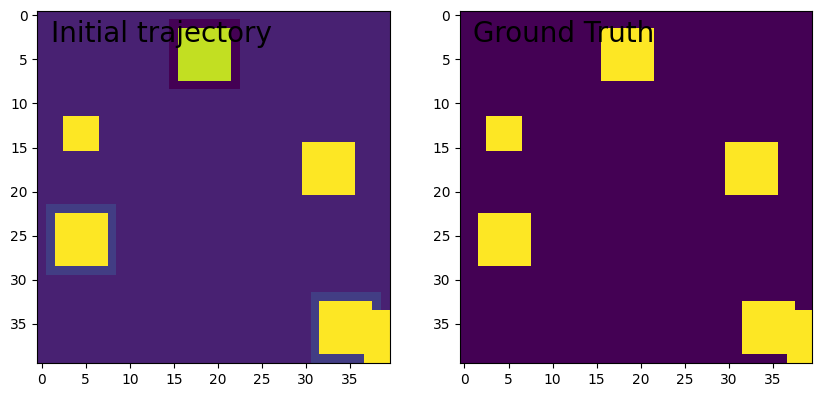

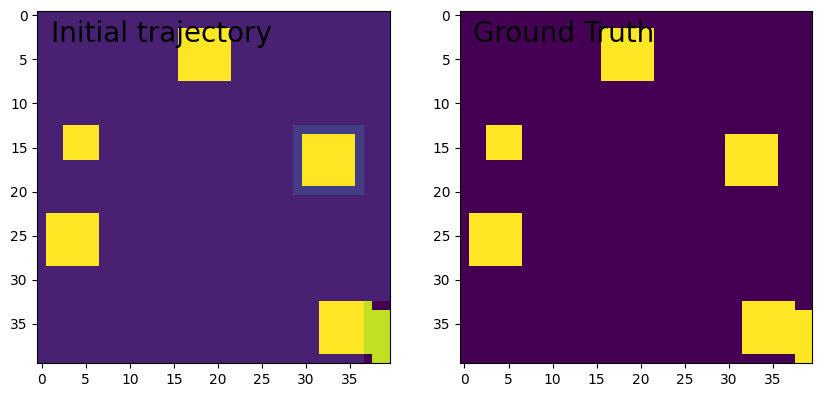

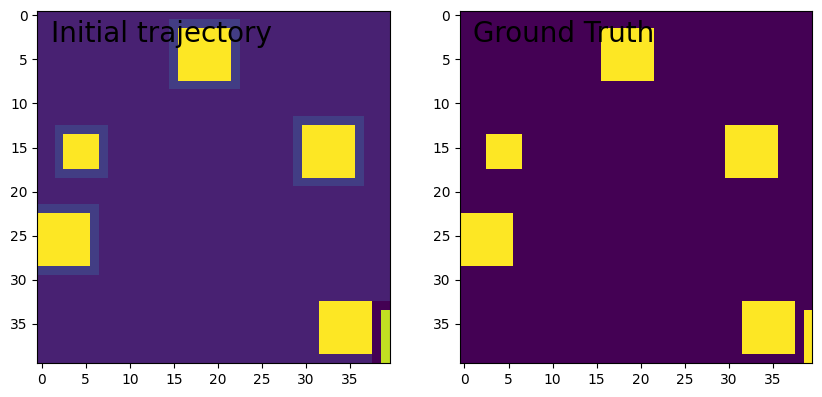

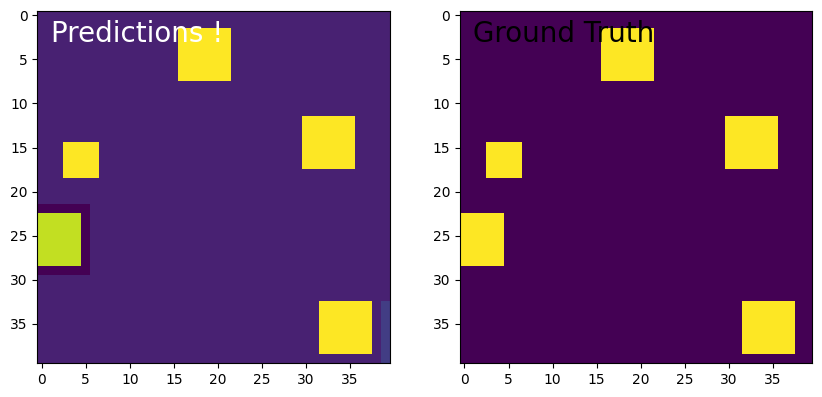

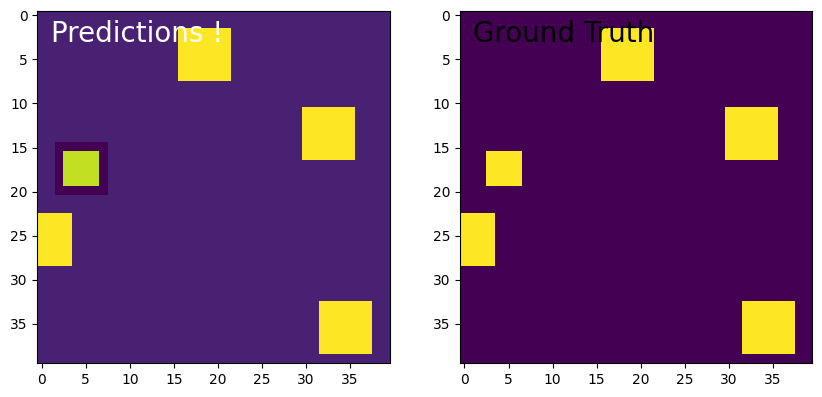

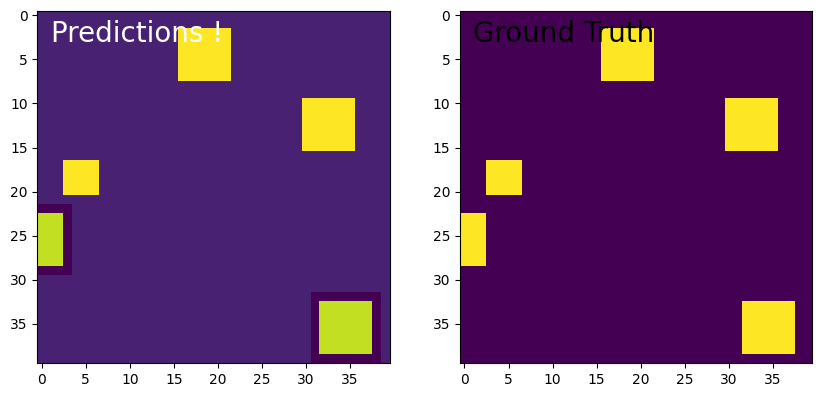

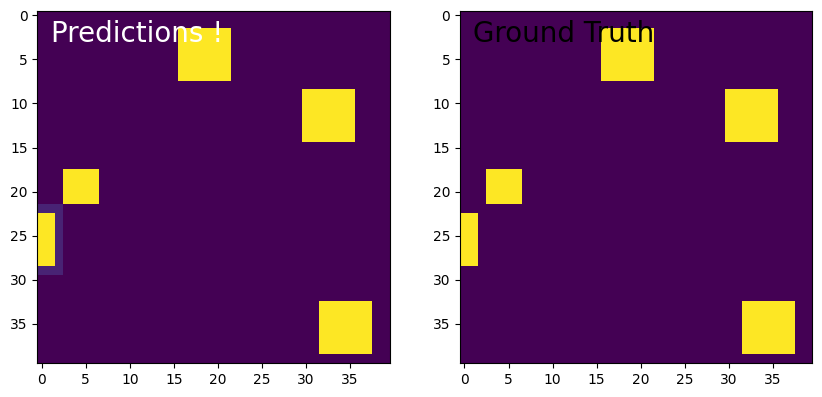

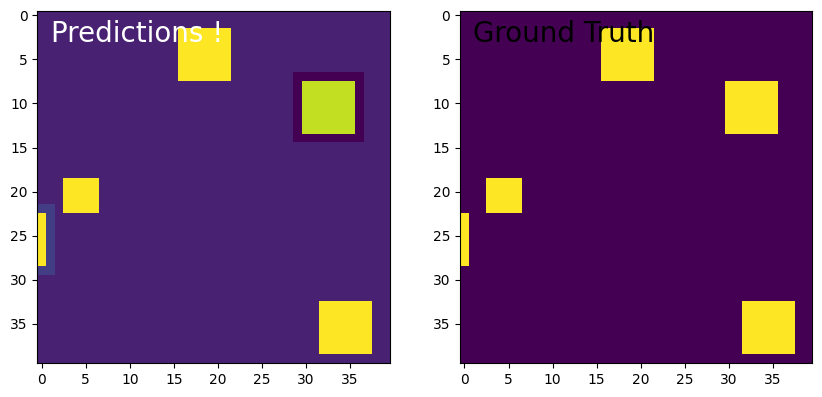

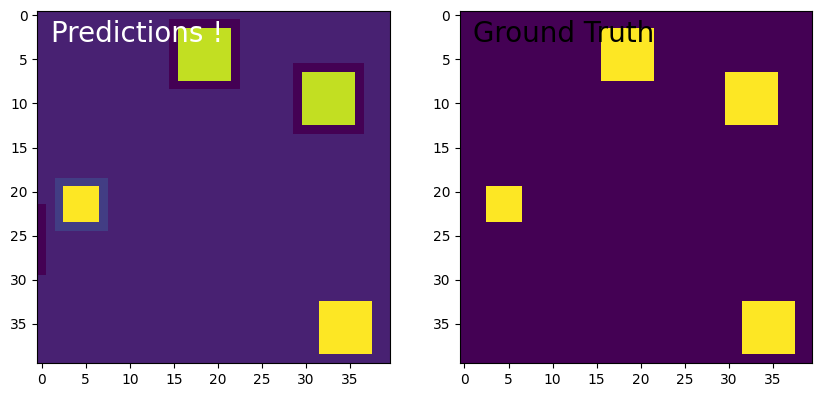

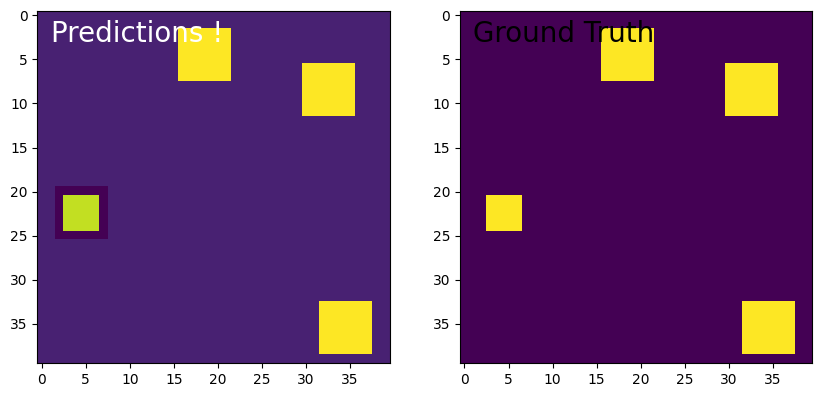

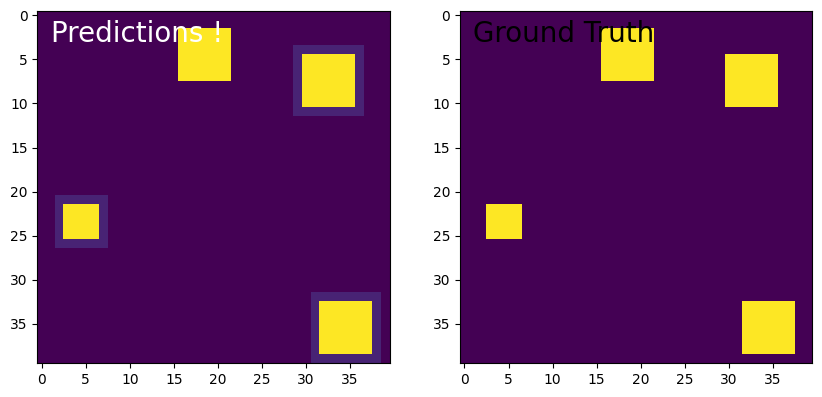

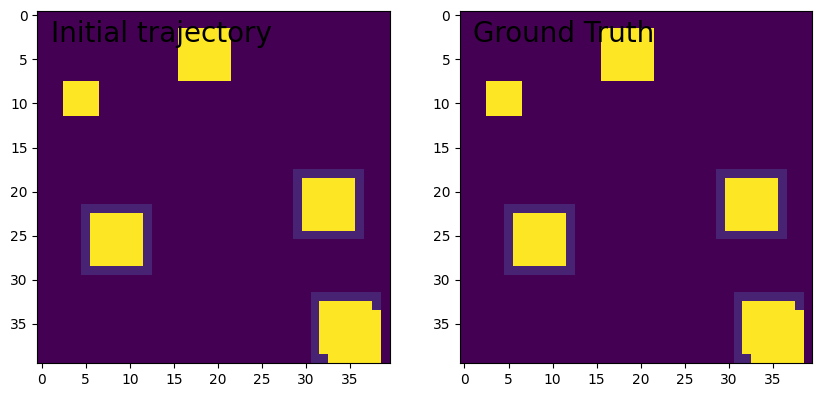

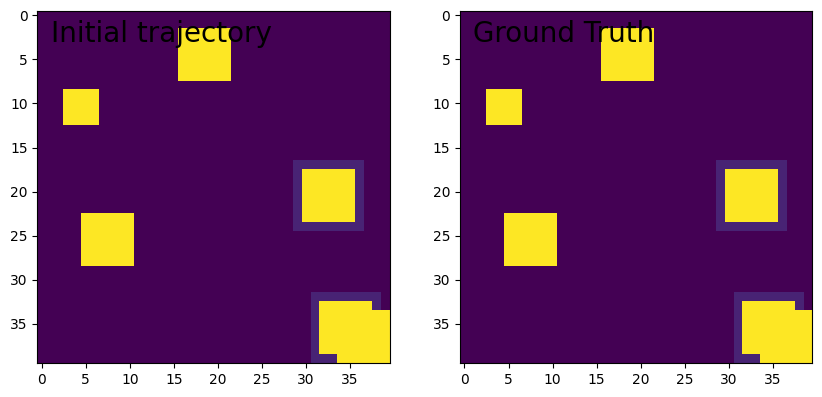

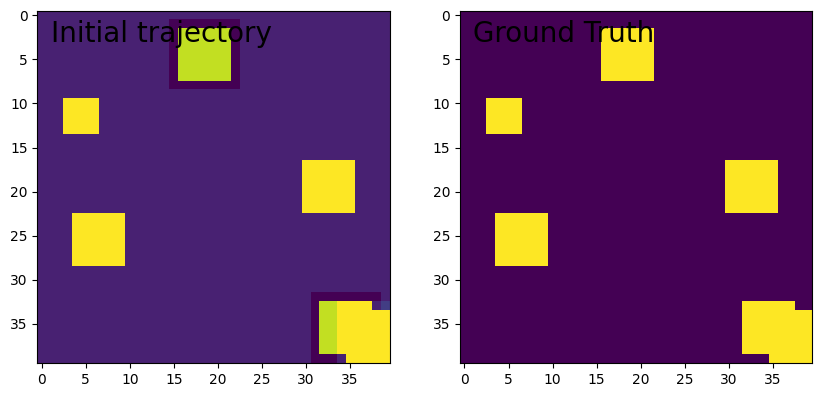

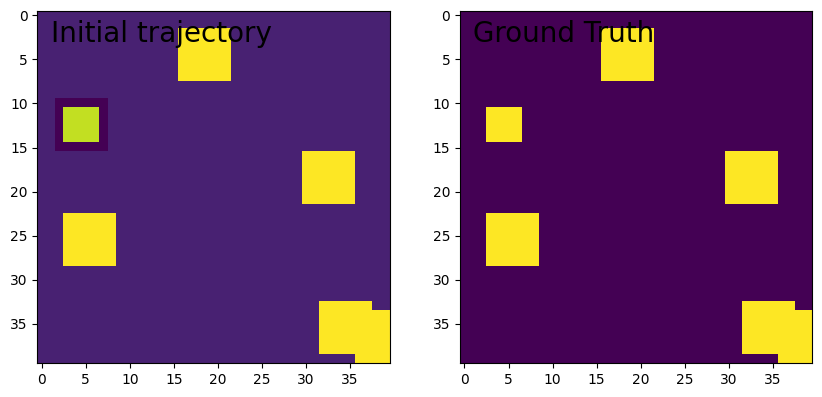

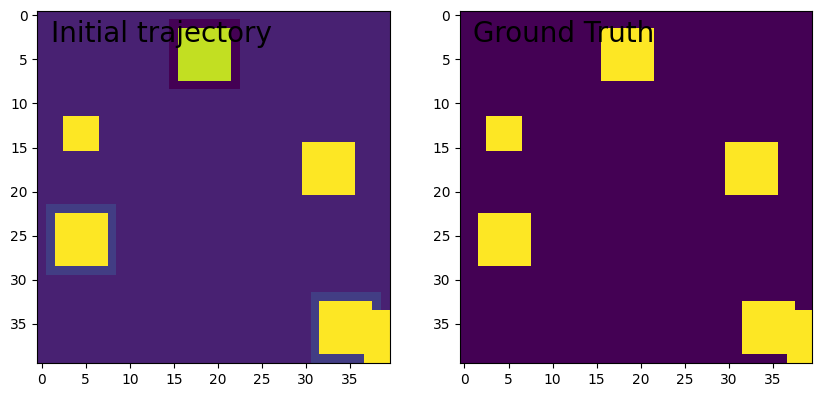

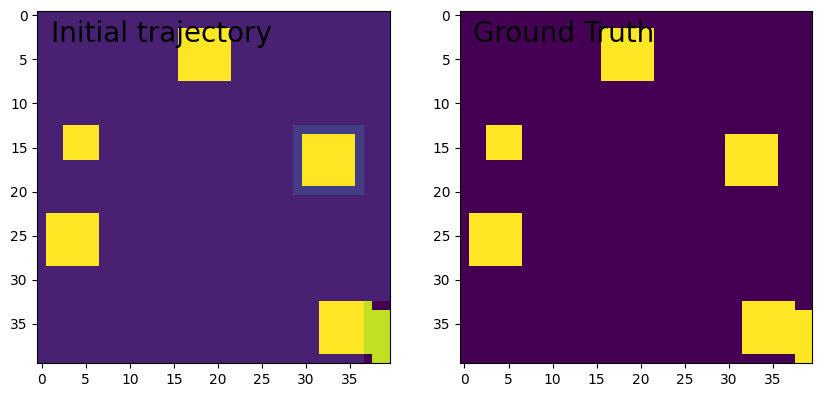

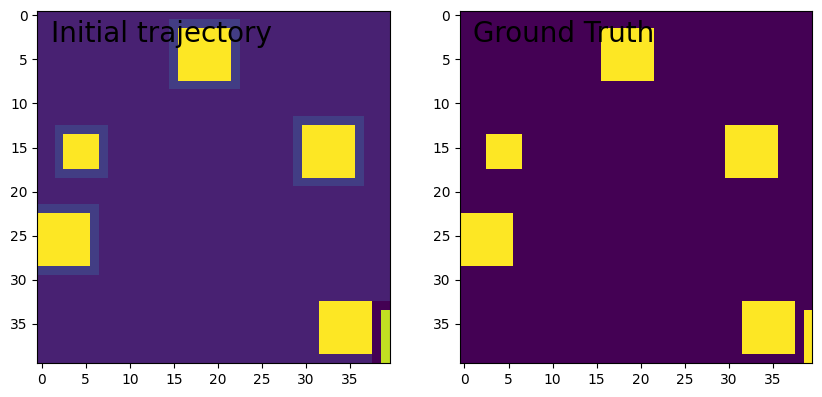

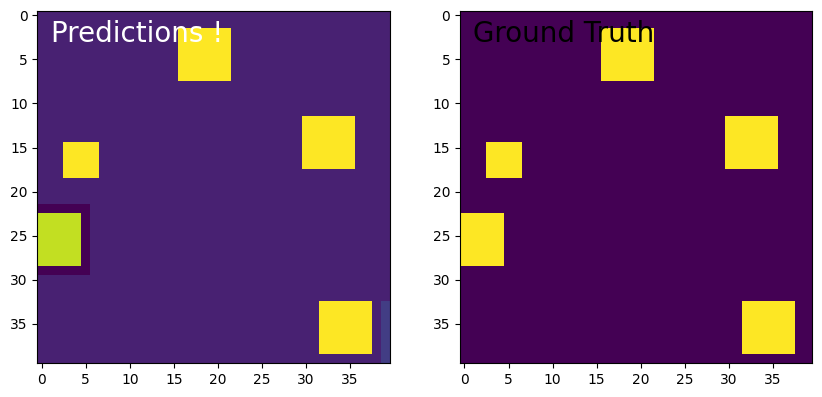

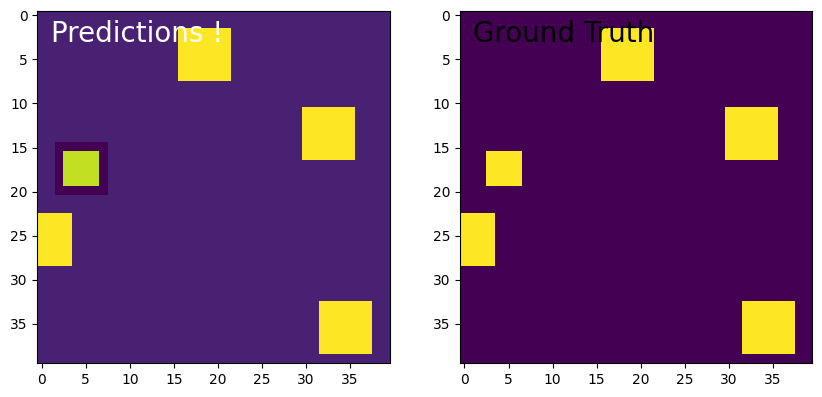

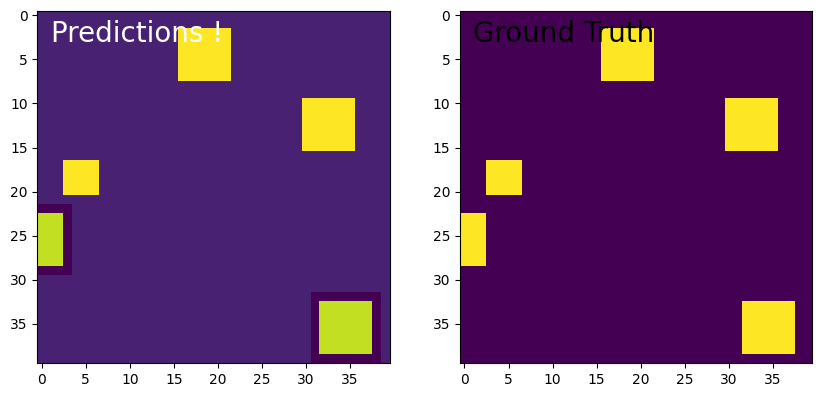

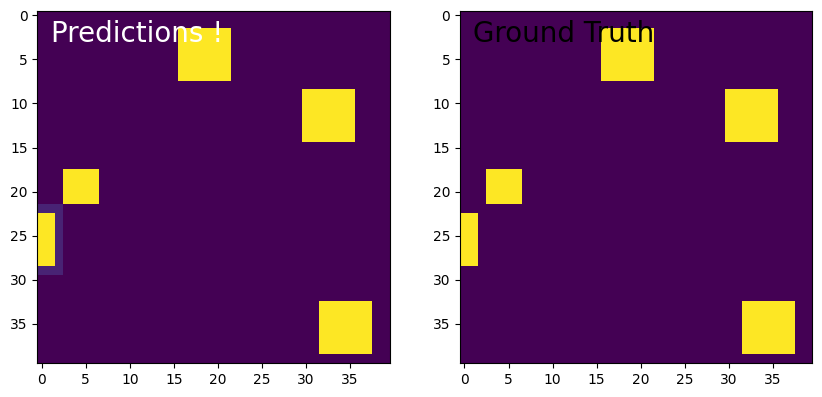

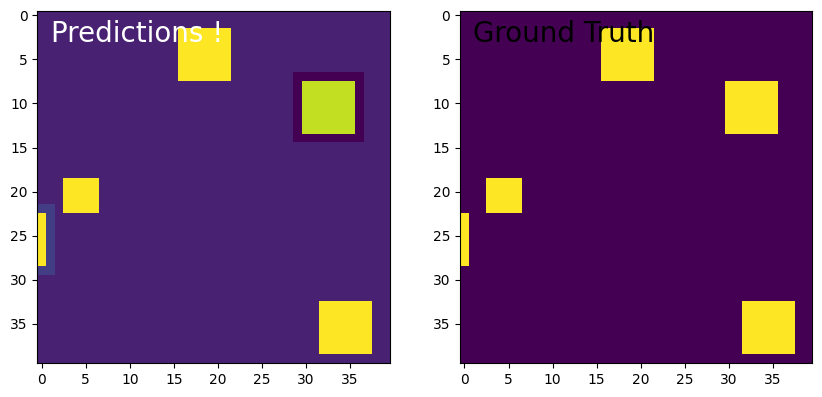

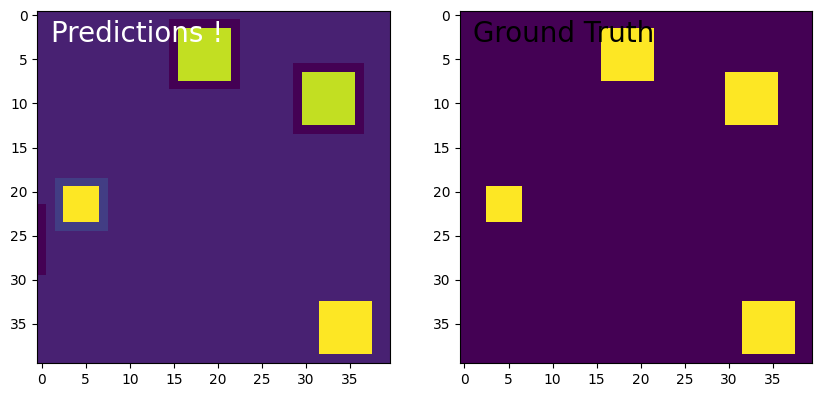

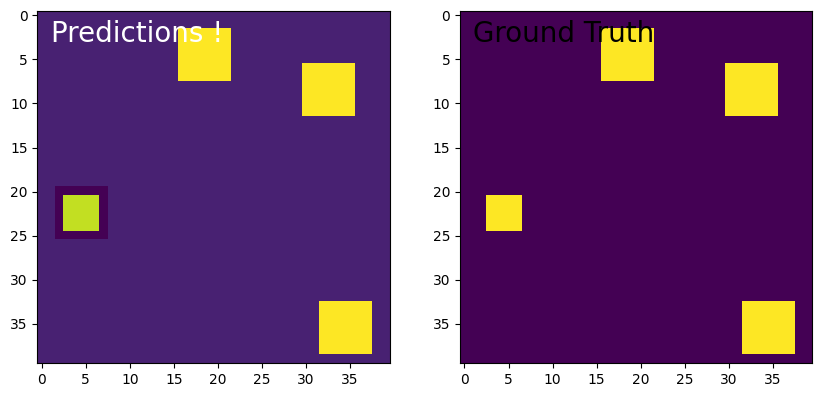

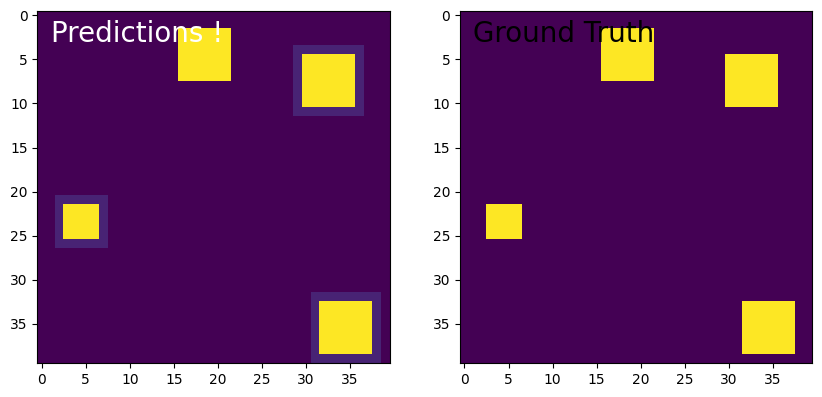

In [16]:
movie_index = 1004
track = noisy_movies[movie_index][:15, ::, ::, ::]

for j in range(16):
  new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
  new = new_pos[::, -1, ::, ::, ::]
  track = np.concatenate((track, new), axis=0)


  # And then compare the predictions
  # to the ground truth
  track2 = noisy_movies[movie_index][::, ::, ::, ::]
  for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
      ax.text(1, 3, "Predictions !", fontsize=20, color="w")
    else:
      ax.text(1, 3, "Initial trajectory", fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, "Ground Truth", fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
      toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig("%i_animate.png" % (i+1))